In [1]:
from glob import glob
import pandas as pd
import numpy as np
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

In this notebook, we process 25-26 data, which can be used by our models to predict scoreline. Next for each team, we test which positions and variable info when changed, increase chances of them scoring. And we store this information later to be used by LLM to generate recommendations for the team.

In [2]:
xtrain = pd.read_csv("player_pca_features_final_2425.csv")
ytrain = pd.read_csv("matchinfo_train2425.csv")
xtest = pd.read_csv("player_sumfeatures_final_2526.csv")
ytest = pd.read_csv("ytest_2526.csv")

In [3]:
# for getting optimal features for player at each position, we optimize model performance by selecting difference features
# import mae
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
def get_best_model_performance(X, y, test_train_split=0.2):

    # create XGB model
    xgb = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
    
    # create linear regression model
    lr = LinearRegression()

    # create MLP regressor model
    mlp = MLPRegressor(hidden_layer_sizes=(11), activation='relu', solver='adam', max_iter=500, random_state=42)

    # train each model and evaluate performance
    models = {'XGB': xgb, 'LinearRegression': lr, 'MLP': mlp}
    best_model = None
    best_mae = float('inf')
    best_r2 = float('-inf')
    models_results = {}

    for model_name, model in models.items():
        fmae = []
        fmse = []
        fr2 = []
        # fit model
        for i in range(5):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_train_split, random_state=i)
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            model.fit(X_train, y_train)

            # predict
            y_pred = model.predict(X_test)

            # evaluate
            mse = mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            fmae.append(mae)
            fmse.append(mse)
            fr2.append(r2)
        mae = np.mean(fmae)
        mse = np.mean(fmse)
        r2 = np.mean(fr2)

        print(f"Model: {model_name}, MSE: {mse}, MAE: {mae}, R2: {r2}")
        # append results to dictionary
        models_results[model_name] = {'MSE': mse, 'MAE': mae, 'R2': r2}

        if mae < best_mae:
            best_mae = mae
        if r2 > best_r2:
            best_r2 = r2
            best_model = model_name
            
    return best_mae, models_results

# function to flatten xtrain_merged for each match and team
def flatten_xtrain(xtrain, selected_features, use_coords=True, subinfo=False, use_gk=False, gk_df=None):
    final_xdf = []
    xdf = xtrain[xtrain['starts']==1.0]
    gk_features = ['Save%', 'Cmp%']
    selected_features_names = set()
    for match_id, match_info in xdf.groupby('match_id'):
        team1_name = match_info[match_info['home_away']==1]['team_name'].values[0]
        team2_name = match_info[match_info['home_away']==0]['team_name'].values[0]
        team1_players = match_info[(match_info['team_name']==team1_name)].sort_values(by='order')
        team2_players = match_info[(match_info['team_name']==team2_name)].sort_values(by='order')
        row_data = {'match_id': match_id, 'team1': team1_name, 'team2': team2_name}
        if use_gk and gk_df is not None:
            # add gk features for team1
            gk_row = gk_df[(gk_df['match_id']==match_id) & (gk_df['team_name']==team1_name) & (gk_df['starts']==1.0)]
            if not gk_row.empty:
                gk_row = gk_row.iloc[0]
                for col in gk_features:
                    row_data[f'team1_GK_{col}'] = gk_row[f'GK_{col}']
                    selected_features_names.add(f'team1_GK_{col}')

        for idx, player_row in team1_players.iterrows():
            if use_coords:
                row_data[f'team1_player{player_row["order"]+1}_xcord'] = player_row['x_coords']
                row_data[f'team1_player{player_row["order"]+1}_ycord'] = player_row['y_coords']
                selected_features_names.add(f'team1_player{player_row["order"]+1}_xcord')
                selected_features_names.add(f'team1_player{player_row["order"]+1}_ycord')

            #add familiarity
            row_data[f'team1_player{player_row["order"]+1}_familiarity'] = player_row['familiarity']
            selected_features_names.add(f'team1_player{player_row["order"]+1}_familiarity')
            for feat in selected_features:
                row_data[f'team1_player{player_row["order"]+1}_{feat}'] = player_row[feat]
                selected_features_names.add(f'team1_player{player_row["order"]+1}_{feat}')

        if use_gk and gk_df is not None:
            # add gk features for team1
            gk_row = gk_df[(gk_df['match_id']==match_id) & (gk_df['team_name']==team1_name) & (gk_df['starts']==1.0)]
            if not gk_row.empty:
                gk_row = gk_row.iloc[0]
                for col in gk_features:
                    row_data[f'team1_GK_{col}'] = gk_row[f'GK_{col}']
                    selected_features_names.add(f'team1_GK_{col}')
        for idx, player_row in team2_players.iterrows():
            if use_coords:
                row_data[f'team2_player{player_row["order"]+1}_xcord'] = player_row['x_coords']
                row_data[f'team2_player{player_row["order"]+1}_ycord'] = player_row['y_coords']
                #add to selected features
                selected_features_names.add(f'team2_player{player_row["order"]+1}_xcord')
                selected_features_names.add(f'team2_player{player_row["order"]+1}_ycord')
            #add familiarity
            row_data[f'team2_player{player_row["order"]+1}_familiarity'] = player_row['familiarity']
            selected_features_names.add(f'team2_player{player_row["order"]+1}_familiarity')
            for feat in selected_features:
                row_data[f'team2_player{player_row["order"]+1}_{feat}'] = player_row[feat]
                selected_features_names.add(f'team2_player{player_row["order"]+1}_{feat}')
        

        final_xdf.append(row_data)
    final_xdf = pd.DataFrame(final_xdf)
    lfeatures = list(selected_features_names)
    lfeatures.sort()
    return final_xdf, lfeatures


/mnt/d/mltorch/lib/python3.12/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


AM [ 2.03238432 -0.68129795]
CB [-4.09156909  1.39015186]
CM [ 0.25705013 -0.06793619]
DM [-1.97095965  0.68615281]
FW [ 4.92446877 -1.73996182]
LB [-3.33364212 -1.45059825]
LM [-0.24670563 -2.4182594 ]
LW [ 2.02234622 -3.43292381]
LWB [-2.24591424 -1.87816619]
RB [-1.74359951  3.1959108 ]
RM [1.29926756 2.07059027]
RW [3.71488932 1.45461715]
RWB [-0.6180161   2.87172071]


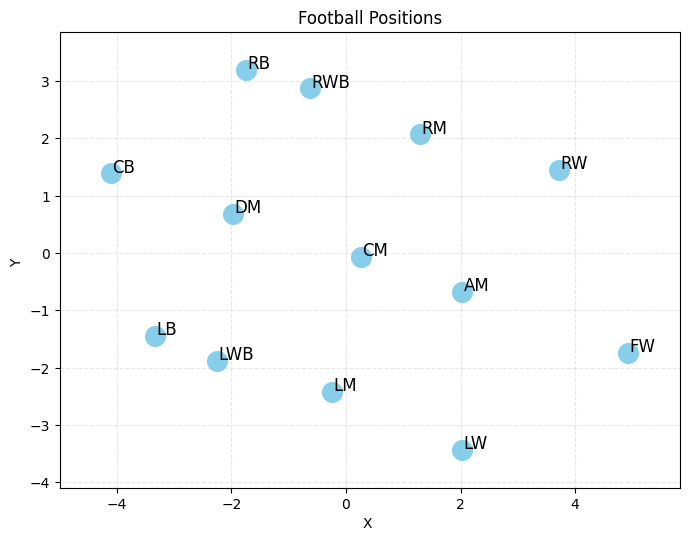

In [4]:
# functions from previous notebook
# get coordinates for each position
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

distances = {
    ('FW','AM'): 4,
    ('FW','LW'): 2,
    ('FW','RW'): 2,
    ('FW','LM'): 5,
    ('FW','RM'): 5,
    ('FW','LWB'): 7,
    ('FW','RWB'): 7,
    ('FW','LB'): 8,
    ('FW','RB'): 8,
    ('FW','CM'): 7,
    ('FW','DM'): 8,
    ('FW','CB'): 9,

    ('AM','LW'): 2,
    ('AM','RW'): 2,
    ('AM','LM'): 2,
    ('AM','RM'): 2,
    ('AM','LWB'): 5,
    ('AM','RWB'): 5,
    ('AM','LB'): 6,
    ('AM','RB'): 6,
    ('AM','CM'): 1,
    ('AM','DM'): 4,
    ('AM','CB'): 7,

    ('CM','LW'): 4,
    ('CM','RW'): 4,
    ('CM','LM'): 2,
    ('CM','RM'): 2,
    ('CM','LWB'): 4,
    ('CM','RWB'): 4,
    ('CM','LB'): 4,
    ('CM','RB'): 4,
    ('CM','DM'): 1,
    ('CM','CB'): 6,

    ('DM','LW'): 6,
    ('DM','RW'): 6,
    ('DM','LM'): 4,
    ('DM','RM'): 4,
    ('DM','LWB'): 2,
    ('DM','RWB'): 2,
    ('DM','LB'): 3,
    ('DM','RB'): 3,
    ('DM','CB'): 2,

    ('CB','LW'): 7,
    ('CB','RW'): 7,
    ('CB','LM'): 6,
    ('CB','RM'): 6,
    ('CB','LWB'): 4,
    ('CB','RWB'): 4,
    ('CB','LB'): 2,
    ('CB','RB'): 2,

    ('LB','LW'): 5,
    ('LB','RW'): 9,
    ('LB','LM'): 2,
    ('LB','RM'): 6,
    ('LB','LWB'): 1,
    ('LB','RWB'): 5,
    ('LB','RB'): 4,

    ('RB','LW'): 9,
    ('RB','RW'): 5,
    ('RB','LM'): 6,
    ('RB','RM'): 2,
    ('RB','LWB'): 5,
    ('RB','RWB'): 1,

    ('RWB','LW'): 8,
    ('RWB','RW'): 4,
    ('RWB','LM'): 5,
    ('RWB','RM'): 1,
    ('RWB','LWB'): 4,

    ('LWB','LW'): 4,
    ('LWB','RW'): 8,
    ('LWB','LM'): 1,
    ('LWB','RM'): 5,

    ('LM','LW'): 1,
    ('LM','RW'): 7,
    ('LM','RM'): 4,

    ('RM','LW'): 7,
    ('RM','RW'): 1,

    ('RW','LW'): 4
}

def positions_to_coords(dist_dict, n_dim=2, random_state=42):
    # 1. 获取所有位置
    positions = sorted({p for pair in dist_dict.keys() for p in pair})
    n_pos = len(positions)
    pos_index = {p:i for i,p in enumerate(positions)}
    
    # 2. 构建完整距离矩阵（未知距离用较大值或平均值）
    dist_matrix = np.zeros((n_pos,n_pos))
    for i in range(n_pos):
        for j in range(n_pos):
            if i == j:
                dist_matrix[i,j] = 0
            else:
                key1 = (positions[i], positions[j])
                key2 = (positions[j], positions[i])
                if key1 in dist_dict:
                    dist_matrix[i,j] = dist_dict[key1]
                elif key2 in dist_dict:
                    dist_matrix[i,j] = dist_dict[key2]
                else:
                    dist_matrix[i,j] = 1.0 

    mds = MDS(n_components=n_dim, dissimilarity='precomputed', random_state=random_state)
    coords = mds.fit_transform(dist_matrix)
    
    # 4. 输出字典
    pos_coords = {p: coords[pos_index[p]] for p in positions}
    return pos_coords

coords = positions_to_coords(distances, n_dim=2)
for k,v in coords.items():
    print(k, v)
# 提取所有 x, y
xs = [x for x, y in coords.values()]
ys = [y for x, y in coords.values()]

# 创建图
plt.figure(figsize=(8,6))
plt.title("Football Positions")
plt.xlabel("X ")
plt.ylabel("Y ")

# 画每个位置
for pos, (x, y) in coords.items():
    plt.scatter(x, y, s=200, c='skyblue')
    plt.text(x+0.02, y+0.02, pos, fontsize=12)

# 自动设置坐标范围并加边距
x_margin = (max(xs)-min(xs))*0.1
y_margin = (max(ys)-min(ys))*0.1
plt.xlim(min(xs)-x_margin, max(xs)+x_margin)
plt.ylim(min(ys)-y_margin, max(ys)+y_margin)

plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()

mpos = {5: [0.4,0.25,0.15,0.12,0.08 ], 4: [0.5,0.25,0.15,0.1], 3:[0.5,0.3,0.2], 2:[0.7,0.3]}

# add formations to xtrain
def get_team_formation(row):
    match_id = row['match_id']
    team_name = row['team_name']
    match_info = ytrain[ytrain['match_id'] == match_id]
    if not match_info.empty:
        if team_name == match_info['team1'].values[0]:
            return match_info['team1_formation'].values[0]
        elif team_name == match_info['team2'].values[0]:
            return match_info['team2_formation'].values[0]
    return None

# add home score and away score to ytrain
def get_home_away_score(row):
    scoreline = row['scoreline']
    scores = scoreline.split('-')
    if len(scores) != 2:
        scores = scoreline.split('–')
        if len(scores) != 2:
            return None, None
    
    homeaway = row['match_id'].split('_')[-1]
    if homeaway == 'H':
        home_score = int(scores[0].strip())
        away_score = int(scores[1].strip())
    else:
        away_score = int(scores[0].strip())
        home_score = int(scores[1].strip())

    return home_score, away_score

formations_positions = {
    "4-5-1": ["GK", "RB", "CB", "CB", "LB", "RM", "CM", "CM", "CM", "LM", "FW"],
    "5-4-1": ["GK", "RB", "CB", "CB", "CB", "LB", "RM", "CM", "CM", "LM", "FW"],
    "3-2-4-1": ["GK", "CB", "CB", "CB", "DM", "DM", "RM", "CM", "CM", "LM", "FW"],
    "4-1-4-1": ["GK", "RB", "CB", "CB", "LB", "DM", "RM", "CM", "CM", "LM", "FW"],
    "4-2-3-1": ["GK", "RB", "CB", "CB", "LB", "DM", "DM", "RM", "AM", "LM", "FW"],
    "3-1-4-2": ["GK", "CB", "CB", "CB", "DM", "RM", "CM", "CM", "LM", "FW", "FW"],
    "5-3-2": ["GK", "RB", "CB", "CB", "CB", "LB", "CM", "CM", "CM", "FW", "FW"],
    "4-3-1-2": ["GK", "RB", "CB", "CB", "LB", "CM", "CM", "CM", "AM", "FW", "FW"],
    "4-4-1-1": ["GK", "RB", "CB", "CB", "LB", "RM", "CM", "CM", "LM", "AM", "FW"],
    "4-1-2-1-2": ["GK", "RB", "CB", "CB", "LB", "DM", "CM", "CM", "AM", "FW", "FW"],
    "3-5-2": ["GK", "CB", "CB", "CB", "RWB", "CM", "CM", "CM", "LWB", "FW", "FW"],
    "4-3-3": ["GK", "RB", "CB", "CB", "LB", "CM", "CM", "CM", "RW", "FW", "LW"],
    "4-2-2-2": ["GK", "RB", "CB", "CB", "LB", "DM", "DM", "RM", "LM", "FW", "FW"],
    "4-4-2": ["GK", "RB", "CB", "CB", "LB", "RM", "CM", "CM", "LM", "FW", "FW"],
    "3-4-3": ["GK", "CB", "CB", "CB", "RM", "CM", "CM", "LM", "RW", "FW", "LW"],
    "3-4-1-2": ["GK", "CB", "CB", "CB", "RM", "CM", "CM", "LM", "AM", "FW", "FW"]
}

def get_role_familiarity(row):
    pos = row['new_POS']
    team_name = row['team_name']
    player_name = row['player_name']
    position_weights = playerinfo[team_name][player_name].get('position_weights', {})

    if ',' in pos:
        pos_list = [p.strip() for p in pos.split(',')]
    else:
        pos_list = [pos]

    familiarity = 0.0
    for p in pos_list:
        familiarity += position_weights.get(p, 0.0)
    return familiarity

def get_pos_coords(row):
    pos = row['new_POS']

    if ',' in pos:
        pos_list = [p.strip() for p in pos.split(',')]
    else:
        pos_list = [pos]

    if pos == 'GK':
        return (0.0, 0.0)  # GK no weights 
    
    xcoords = 0.0
    ycoords = 0.0
    if len(pos_list) == 1:
        p = pos_list[0]
        if p not in coords:
            print(p)
            return (0.0, 0.0)
        xcoords = coords[p][0]
        ycoords = coords[p][1]
        return (xcoords, ycoords)
    for idx,p in enumerate(pos_list):
        if p not in coords:
            print(p)
            continue
        v = mpos[len(pos_list)][idx]
        xcoords = coords[p][0] * v + xcoords
        ycoords = coords[p][1] * v + ycoords
    return xcoords, ycoords

    # add home or away info to xdf
def get_home_away(row):
    match_id = row['match_id']
    team_name = row['team_name']
    match_info = match_id.split('_')
    team1 = match_info[0]
    team2 = match_info[1]
    homeaway = match_info[-1]
    if team_name == team1 and homeaway == 'H':
        return 1
    elif team_name == team2 and homeaway == 'A':
        return 1
    elif team_name == team1 and homeaway == 'A':
        return 0
    elif team_name == team2 and homeaway == 'H':
        return 0
    return None

In [5]:
with open('playerinfo_processed.json', 'r') as f:
    # read player info
    playerinfo = json.load(f)

In [6]:
xtrain['formation'] = xtrain.apply(lambda row: get_team_formation(row), axis=1)
xtrain.dropna(inplace=True)
xtrain['x_coords'] = xtrain.apply(lambda row: get_pos_coords(row)[0], axis=1)
xtrain['y_coords'] = xtrain.apply(lambda row: get_pos_coords(row)[1], axis=1)
# role familiarity

xtrain['familiarity'] = xtrain.apply(lambda row: get_role_familiarity(row), axis=1)
xtrain.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,player_name,team_name,match_id,Pos,Minutes,Starts,new_POS,formation,x_coords,y_coords,familiarity
0,0.168534,-0.258025,-0.002957,-0.014741,0.036560,0.119996,0.014278,Ben White,Arsenal,Arsenal_Wolves_1_20240817_H,RB,90.0,1,RB,4-3-3,-1.743600,3.195911,0.797401
1,1.219420,0.973380,-0.279193,-0.170504,0.123143,0.202416,-0.033560,Bukayo Saka,Arsenal,Arsenal_Wolves_1_20240817_H,RW,79.0,1,RW,4-3-3,3.714889,1.454617,0.639116
2,-0.098128,-0.362798,-0.289863,0.585192,-0.193722,0.039448,-0.083642,David Raya,Arsenal,Arsenal_Wolves_1_20240817_H,GK,90.0,1,GK,4-3-3,0.000000,0.000000,1.000000
3,0.830315,0.008400,-0.082664,-0.084396,0.118838,0.326469,0.051253,Declan Rice,Arsenal,Arsenal_Wolves_1_20240817_H,LM,84.0,1,LM,4-3-3,-0.246706,-2.418259,0.453965
4,-0.017742,0.252378,0.102859,0.051054,0.087101,-0.092282,0.096185,Gabriel Jesus,Arsenal,Arsenal_Wolves_1_20240817_H,FW,6.0,0,FW,4-3-3,4.924469,-1.739962,0.904538


In [7]:
xdf = []

# order each player in xtrain according to formation positions and append features to xdf for each match and team

for match_id, match_info in xtrain.groupby('match_id'):
    for team_name, team_info in match_info.groupby('team_name'):
        formation = team_info['formation'].values[0]
        if formation not in formations_positions:
            print(f"Formation {formation} not found for team {team_name} in match {match_id}")
            continue
        formation_positions = formations_positions[formation]
        team_players = team_info.copy()
        team_players_start = team_players[team_players['Starts']==1]
        team_subs = team_players[team_players['Starts']==0]
        player_pos = {}
        if len(team_players_start) < len(formation_positions):
            print(f"Not enough starting players for team {team_name} in match {match_id}")
            continue
        team_players = team_players_start
        for idx, pos in enumerate(formation_positions):
            # find player closest to position pos
            pos_coord = coords.get(pos, None)
            if pos_coord is None:
                if pos == 'GK':
                    # add GK row to xdf
                    gk_player = team_players[team_players['Pos']=='GK']
                    if gk_player.empty:
                        print(f"No GK found for team {team_name} in match {match_id}")
                        continue
                    selected_player = gk_player.iloc[0]
                    row_data = {
                        'match_id': match_id,
                        'team_name': team_name,
                        'position': pos,
                        'player_name': selected_player['player_name'],
                        'PCA1': selected_player['PCA1'],
                        'PCA2': selected_player['PCA2'],
                        'PCA3': selected_player['PCA3'],
                        'PCA4': selected_player['PCA4'],
                        'PCA5': selected_player['PCA5'],
                        'PCA6': selected_player['PCA6'],
                        'PCA7': selected_player['PCA7'],
                        'x_coords': selected_player['x_coords'],
                        'y_coords': selected_player['y_coords'],
                        'familiarity': selected_player['familiarity'],
                        'order': idx,
                        'minutes':selected_player['Minutes'],
                        'starts':1
                    }
                    player_pos[selected_player['player_name']] = (pos,idx)
                    xdf.append(row_data)
                    # remove selected player from team_players to avoid duplicate selection
                    team_players = team_players[team_players['player_name'] != selected_player['player_name']]
                continue
            px, py = pos_coord
            team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
            team_players_sorted = team_players.sort_values(by=['dist_to_pos', 'player_name'])
            if team_players_sorted.empty:
                print(f"No players found for team {team_name} in match {match_id}")
                continue
            selected_player = team_players_sorted.iloc[0]
            row_data = {
                'match_id': match_id,
                'team_name': team_name,
                'position': pos,
                'player_name': selected_player['player_name'],
                'PCA1': selected_player['PCA1'],
                'PCA2': selected_player['PCA2'],
                'PCA3': selected_player['PCA3'],
                'PCA4': selected_player['PCA4'],
                'PCA5': selected_player['PCA5'],
                'PCA6': selected_player['PCA6'],
                'PCA7': selected_player['PCA7'],
                'x_coords': selected_player['x_coords'],
                'y_coords': selected_player['y_coords'],
                'familiarity': selected_player['familiarity'],
                'order': idx,
                'minutes':selected_player['Minutes'],
                'starts':1
            }
            xdf.append(row_data)
            # remove selected player from team_players to avoid duplicate selection
            player_pos[selected_player['player_name']] = (pos,idx)
            team_players = team_players[team_players['player_name'] != selected_player['player_name']]
        # to get position index, calculate distance of coordinates from position coordinates, sort by distance, name of player

        # add info about substitute
        team_subs = team_info.copy()
        team_subs = team_subs[(team_subs['Starts']==0)&(team_subs['Minutes']>0.0)]
        team_subs = team_subs.sort_values(by='Minutes',ascending=False)
        team_players_start = team_info.copy()
        team_players_start = team_players_start[team_players_start['Starts']==1]
        sub_poss = {}
        for idx, row in team_subs.iterrows():
            subsub = False
            sub_outmins = 90-float(row['Minutes'])
            subout_players = team_players_start[team_players_start['Minutes']==sub_outmins]['player_name'].values
            print(subout_players, subout_players.shape, sub_outmins, team_players_start['Minutes'].values)
            if subout_players.shape[0]==0:
                subout_players = team_players_start[team_players_start['Minutes']!=90.0]['player_name'].values
                if subout_players.shape[0]==0:
                    # subbetout from subs
                    subout_players = np.array(list(sub_poss.keys()))
                    subsub=True
        

            name = subout_players[0]
            if subsub:
                best_pos = sub_poss[name][0]
            else:
                best_pos = player_pos[subout_players[0]][0]

            if subout_players.shape[0]>1:
                dmin = None
                for i in subout_players:
                    if subsub:
                        pos, _ = sub_poss[i]
                    else:
                        pos, _ = player_pos[i]

                    if pos == "GK":
                        posx,posy = 0.0,0.0
                    else:
                        posx,posy = coords.get(pos, None)
                    dtmin = np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2)
                    if dmin is None:
                        dmin = dtmin
                    elif dtmin<dmin:
                        dmin=dtmin
                        best_pos=pos
                        name=i
            # remove player for team_players_start

            row_data = {
                'match_id': match_id,
                'team_name': team_name,
                'position': best_pos,
                'player_name': row['player_name'],
                'PCA1': row['PCA1'],
                'PCA2': row['PCA2'],
                'PCA3': row['PCA3'],
                'PCA4': row['PCA4'],
                'PCA5': row['PCA5'],
                'PCA6': row['PCA6'],
                'PCA7': row['PCA7'],
                'x_coords': row['x_coords'],
                'y_coords': row['y_coords'],
                'familiarity': row['familiarity'],
                'order': idx+11,
                'minutes':row['Minutes'],
                'starts':0
            }
            sub_poss[row['player_name']]=best_pos,idx+11
            xdf.append(row_data)
            if subsub:
                sub_poss.pop(name)
            else:
                team_players_start = team_players_start[team_players_start['player_name'] !=name]

xdf = pd.DataFrame(xdf)
xdf['home_away'] = xdf.apply(lambda row: get_home_away(row), axis=1)

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Gabriel Martinelli'] (1,) 81.0 [90. 90. 90. 81. 90. 90. 90. 90. 90. 90. 90.]
['Amadou Onana'] (1,) 36.0 [36. 90. 90. 90. 45. 84. 90. 90. 79. 90. 90.]
['Ian Maatsen'] (1,) 45.0 [90. 90. 90. 45. 84. 90. 90. 79. 90. 90.]
['Ollie Watkins'] (1,) 79.0 [90. 90. 90. 84. 90. 90. 79. 90. 90.]
['Jacob Ramsey'] (1,) 84.0 [90. 90. 90. 84. 90. 90. 90. 90.]
['Gabriel Martinelli'] (1,) 64.0 [90. 87. 90. 90. 90. 64. 78. 90. 90. 90. 90.]
['Jurriën Timber'] (1,) 78.0 [90. 87. 90. 90. 90. 78. 90. 90. 90. 90.]
['Bukayo Saka'] (1,) 87.0 [90. 87. 90. 90. 90. 90. 90. 90. 90.]
['Matty Cash'] (1,) 15.0 [75. 90. 90. 64. 90. 75. 15. 90. 64. 90. 90.]
['John McGinn' 'Ollie Watkins'] (2,) 64.0 [75. 90. 90. 64. 90. 75. 90. 64. 90. 90.]
['Ollie Watkins'] (1,) 64.0 [75. 90. 90. 90. 75. 90. 64. 90. 90.]
['Amadou Onana' 'Lucas Digne'] (2,) 75.0 [75. 90. 90. 90. 75. 90. 90. 90.]
['Lucas Digne'] (1,) 75.0 [90. 90. 90. 75. 90. 90. 90.]
['Declan Rice'] (1,) 73.0 [85. 85. 90. 73. 85. 90. 90. 90. 90. 90. 90.]
['Ben White' 'B

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Noni Madueke' 'Roméo Lavia'] (2,) 67.0 [67. 90. 90. 81. 90. 90. 87. 90. 90. 67. 90.]
['Roméo Lavia'] (1,) 67.0 [90. 90. 81. 90. 90. 87. 90. 90. 67. 90.]
['Malo Gusto'] (1,) 81.0 [90. 90. 81. 90. 90. 87. 90. 90. 90.]
['Nicolas Jackson'] (1,) 87.0 [90. 90. 90. 90. 87. 90. 90. 90.]
['Gabriel Martinelli'] (1,) 78.0 [90. 90. 90. 78. 90. 90. 89. 90. 90. 90. 90.]
['Martin Ødegaard'] (1,) 89.0 [90. 90. 90. 90. 90. 89. 90. 90. 90. 90.]
['Jadon Sancho' 'Christopher Nkunku'] (2,) 75.0 [75. 85. 75. 90. 90. 90. 90. 90. 81. 90. 85.]
['Christopher Nkunku'] (1,) 75.0 [85. 75. 90. 90. 90. 90. 90. 81. 90. 85.]
['Reece James'] (1,) 81.0 [85. 90. 90. 90. 90. 90. 81. 90. 85.]
['Benoît Badiashile' 'Wesley Fofana'] (2,) 85.0 [85. 90. 90. 90. 90. 90. 90. 85.]
['Wesley Fofana'] (1,) 85.0 [90. 90. 90. 90. 90. 90. 85.]
['Bukayo Saka'] (1,) 23.0 [23. 90. 85. 90. 90. 85. 57. 90. 57. 90. 90.]
['Kai Havertz' 'Myles Lewis-Skelly'] (2,) 57.0 [90. 85. 90. 90. 85. 57. 90. 57. 90. 90.]
['Myles Lewis-Skelly'] (1,) 57.0 

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Ethan Nwaneri' 'Raheem Sterling'] (2,) 45.0 [60. 90. 90. 45. 90. 70. 90. 90. 74. 45. 90.]
['Raheem Sterling'] (1,) 45.0 [60. 90. 90. 90. 70. 90. 90. 74. 45. 90.]
['Ben White'] (1,) 60.0 [60. 90. 90. 90. 70. 90. 90. 74. 90.]
['Jorginho'] (1,) 70.0 [90. 90. 90. 70. 90. 90. 74. 90.]
['Myles Lewis-Skelly'] (1,) 74.0 [90. 90. 90. 90. 90. 74. 90.]
['Beto' 'Tim Iroegbunam'] (2,) 64.0 [90. 64. 90. 74. 86. 90. 90. 90. 90. 74. 64.]
['Tim Iroegbunam'] (1,) 64.0 [90. 90. 74. 86. 90. 90. 90. 90. 74. 64.]
['Iliman Ndiaye' 'Nathan Patterson'] (2,) 74.0 [90. 90. 74. 86. 90. 90. 90. 90. 74.]
['Nathan Patterson'] (1,) 74.0 [90. 90. 86. 90. 90. 90. 90. 74.]
['Jack Harrison'] (1,) 86.0 [90. 90. 86. 90. 90. 90. 90.]
['Leandro Trossard'] (1,) 59.0 [90. 90. 90. 90. 73. 90. 73. 59. 78. 90. 90.]
['Jorginho' 'Kai Havertz'] (2,) 73.0 [90. 90. 90. 90. 73. 90. 73. 78. 90. 90.]
['Kai Havertz'] (1,) 73.0 [90. 90. 90. 90. 90. 73. 78. 90. 90.]
['Martin Ødegaard'] (1,) 78.0 [90. 90. 90. 90. 90. 78. 90. 90.]
['Adama T

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Jack Clarke'] (1,) 34.0 [45. 90. 90. 90. 90. 80. 34. 90. 80. 31. 89.]
['Julio Enciso'] (1,) 45.0 [45. 90. 90. 90. 90. 80. 90. 80. 31. 89.]
['George Hirst' 'Jens Cajuste'] (2,) 80.0 [90. 90. 90. 90. 80. 90. 80. 31. 89.]
['Jens Cajuste'] (1,) 80.0 [90. 90. 90. 90. 90. 80. 31. 89.]
['Sam Morsy'] (1,) 89.0 [90. 90. 90. 90. 90. 31. 89.]
['Raheem Sterling'] (1,) 68.0 [90. 90. 90. 90. 90. 88. 90. 75. 68. 75. 90.]
['Myles Lewis-Skelly' 'Thomas Partey'] (2,) 75.0 [90. 90. 90. 90. 90. 88. 90. 75. 75. 90.]
['Thomas Partey'] (1,) 75.0 [90. 90. 90. 90. 90. 88. 90. 75. 90.]
['Leandro Trossard'] (1,) 88.0 [90. 90. 90. 90. 90. 88. 90. 90.]
['James Justin'] (1,) 42.0 [74. 42. 90. 84. 90. 90. 90. 90. 90. 84. 90.]
['Jordan Ayew'] (1,) 74.0 [74. 90. 84. 90. 90. 90. 90. 90. 84. 90.]
['Bobby De Cordova-Reid' 'Wilfred Ndidi'] (2,) 84.0 [90. 84. 90. 90. 90. 90. 90. 84. 90.]
['Wilfred Ndidi'] (1,) 84.0 [90. 90. 90. 90. 90. 90. 84. 90.]
['Gabriel Martinelli'] (1,) 73.0 [90. 90. 90. 90. 73. 90. 90. 89. 90. 84.

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Leandro Trossard' 'Martin Ødegaard'] (2,) 83.0 [90. 90. 90. 90. 90. 89. 83. 83. 89. 90. 90.]
['Martin Ødegaard'] (1,) 83.0 [90. 90. 90. 90. 90. 89. 83. 89. 90. 90.]
['Kai Havertz' 'Myles Lewis-Skelly'] (2,) 89.0 [90. 90. 90. 90. 90. 89. 89. 90. 90.]
['Myles Lewis-Skelly'] (1,) 89.0 [90. 90. 90. 90. 90. 89. 90. 90.]
['Omar Marmoush' 'Phil Foden'] (2,) 71.0 [90. 90. 90. 90. 90. 90. 90. 71. 71. 90. 90.]
['Phil Foden'] (1,) 71.0 [90. 90. 90. 90. 90. 90. 90. 71. 90. 90.]
['Bukayo Saka'] (1,) 45.0 [45. 90. 90. 90. 86. 89. 90. 44. 73. 90. 90.]
['Riccardo Calafiori'] (1,) 73.0 [90. 90. 90. 86. 89. 90. 44. 73. 90. 90.]
['Gabriel Martinelli'] (1,) 86.0 [90. 90. 90. 86. 89. 90. 44. 90. 90.]
['Jurriën Timber'] (1,) 89.0 [90. 90. 90. 89. 90. 44. 90. 90.]
['Rodri'] (1,) 20.0 [77. 90. 90. 90. 69. 90. 90. 20. 90. 77. 90.]
['Jeremy Doku'] (1,) 69.0 [77. 90. 90. 90. 69. 90. 90. 90. 77. 90.]
['Kyle Walker' 'Sávio'] (2,) 77.0 [77. 90. 90. 90. 90. 90. 90. 77. 90.]
['Sávio'] (1,) 77.0 [90. 90. 90. 90. 90.

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Joe Willock'] (1,) 64.0 [90. 90. 84. 89. 90. 90. 64. 90. 90. 90. 90.]
['Anthony Gordon'] (1,) 84.0 [90. 90. 84. 89. 90. 90. 90. 90. 90. 90.]
['Bruno Guimarães'] (1,) 89.0 [90. 90. 89. 90. 90. 90. 90. 90. 90.]
['William Saliba'] (1,) 45.0 [90. 75. 90. 90. 90. 90. 87. 89. 90. 90. 45.]
['Bukayo Saka'] (1,) 75.0 [90. 75. 90. 90. 90. 90. 87. 89. 90. 90.]
['Leandro Trossard'] (1,) 87.0 [90. 90. 90. 90. 90. 87. 89. 90. 90.]
['Martin Ødegaard'] (1,) 89.0 [90. 90. 90. 90. 90. 89. 90. 90.]
['Jacob Murphy'] (1,) 62.0 [90. 90. 63. 90. 90. 75. 62. 90. 90. 63. 90.]
['Callum Wilson' 'Sven Botman'] (2,) 63.0 [90. 90. 63. 90. 90. 75. 90. 90. 63. 90.]
['Sven Botman'] (1,) 63.0 [90. 90. 90. 90. 75. 90. 90. 63. 90.]
['Harvey Barnes'] (1,) 75.0 [90. 90. 90. 90. 75. 90. 90. 90.]
['Jorginho'] (1,) 45.0 [82. 90. 90. 90. 45. 87. 90. 82. 90. 66. 90.]
['Riccardo Calafiori'] (1,) 66.0 [82. 90. 90. 90. 87. 90. 82. 90. 66. 90.]
['Bukayo Saka' 'Martin Ødegaard'] (2,) 82.0 [82. 90. 90. 90. 87. 90. 82. 90. 90.]
['Ma

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Ross Stewart'] (1,) 69.0 [90. 85. 90. 90. 78. 78. 90. 90. 69. 90. 90.]
['Jay Robinson' 'Kamaldeen Sulemana'] (2,) 78.0 [90. 85. 90. 90. 78. 78. 90. 90. 90. 90.]
['Kamaldeen Sulemana'] (1,) 78.0 [90. 85. 90. 90. 78. 90. 90. 90. 90.]
['Lesley Ugochukwu'] (1,) 85.0 [90. 85. 90. 90. 90. 90. 90. 90.]
['Gabriel Jesus' 'Raheem Sterling'] (2,) 59.0 [90. 90. 90. 59. 90. 60. 90. 59. 89. 83. 90.]
['Raheem Sterling'] (1,) 59.0 [90. 90. 90. 90. 60. 90. 59. 89. 83. 90.]
['Jorginho'] (1,) 60.0 [90. 90. 90. 90. 60. 90. 89. 83. 90.]
['Thomas Partey'] (1,) 83.0 [90. 90. 90. 90. 90. 89. 83. 90.]
['Riccardo Calafiori'] (1,) 89.0 [90. 90. 90. 90. 90. 89. 90.]
['Ross Stewart'] (1,) 26.0 [90. 90. 90. 90. 90. 90. 73. 26. 73. 90. 89.]
['Mateus Fernandes' 'Ryan Manning'] (2,) 73.0 [90. 90. 90. 90. 90. 90. 73. 73. 90. 89.]
['Ryan Manning'] (1,) 73.0 [90. 90. 90. 90. 90. 90. 73. 90. 89.]
['Yukinari Sugawara'] (1,) 89.0 [90. 90. 90. 90. 90. 90. 90. 89.]
['Raheem Sterling'] (1,) 60.0 [90. 86. 90. 90. 90. 76. 90. 

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Declan Rice' 'Riccardo Calafiori'] (2,) 55.0 [90. 55. 80. 90. 90. 90. 90. 90. 55. 90. 85.]
[] (0,) 73.0 [90. 80. 90. 90. 90. 90. 90. 55. 90. 85.]
[] (0,) 80.0 [90. 90. 90. 90. 90. 90. 55. 90. 85.]
['William Saliba'] (1,) 85.0 [90. 90. 90. 90. 90. 90. 90. 85.]
['Jean-Clair Todibo'] (1,) 61.0 [90. 90. 90. 90. 90. 87. 81. 61. 90. 90. 90.]
['Jarrod Bowen'] (1,) 81.0 [90. 90. 90. 90. 90. 87. 81. 90. 90. 90.]
['Edson Álvarez'] (1,) 87.0 [90. 90. 90. 90. 90. 87. 90. 90. 90.]
['Oleksandr Zinchenko'] (1,) 68.0 [90. 79. 90. 84. 90. 90. 90. 90. 68. 90. 90.]
['Bukayo Saka'] (1,) 79.0 [90. 79. 90. 84. 90. 90. 90. 90. 90. 90.]
['Declan Rice'] (1,) 84.0 [90. 90. 84. 90. 90. 90. 90. 90. 90.]
['Jean-Ricner Bellegarde'] (1,) 56.0 [83. 90. 56. 90. 83. 83. 90. 90. 74. 90. 90.]
['Rodrigo Gomes'] (1,) 74.0 [83. 90. 90. 83. 83. 90. 90. 74. 90. 90.]
['Rayan Aït-Nouri' 'João Gomes' 'Jørgen Strand Larsen'] (3,) 83.0 [83. 90. 90. 83. 83. 90. 90. 90. 90.]
['João Gomes' 'Jørgen Strand Larsen'] (2,) 83.0 [90. 90.

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Julian Araujo'] (1,) 29.0 [90. 90. 63. 90. 29. 63. 90. 90. 90. 80. 80.]
['Enes Ünal' 'Justin Kluivert'] (2,) 63.0 [90. 90. 63. 90. 63. 90. 90. 90. 80. 80.]
['Justin Kluivert'] (1,) 63.0 [90. 90. 90. 63. 90. 90. 90. 80. 80.]
['Milos Kerkez' 'Ryan Christie'] (2,) 80.0 [90. 90. 90. 90. 90. 90. 80. 80.]
['Ryan Christie'] (1,) 80.0 [90. 90. 90. 90. 90. 90. 80.]
['Leon Bailey' 'Ollie Watkins'] (2,) 64.0 [70. 90. 90. 87. 64. 90. 90. 86. 64. 90. 90.]
['Ollie Watkins'] (1,) 64.0 [70. 90. 90. 87. 90. 90. 86. 64. 90. 90.]
['Boubacar Kamara'] (1,) 70.0 [70. 90. 90. 87. 90. 90. 86. 90. 90.]
['Morgan Rogers'] (1,) 86.0 [90. 90. 87. 90. 90. 86. 90. 90.]
['John McGinn'] (1,) 87.0 [90. 90. 87. 90. 90. 90. 90.]
['Yehor Yarmoliuk'] (1,) 63.0 [90. 90. 79. 70. 90. 90. 90. 90. 90. 63. 70.]
['Kevin Schade' 'Yoane Wissa'] (2,) 70.0 [90. 90. 79. 70. 90. 90. 90. 90. 90. 70.]
['Yoane Wissa'] (1,) 70.0 [90. 90. 79. 90. 90. 90. 90. 90. 70.]
['Keane Lewis-Potter'] (1,) 79.0 [90. 90. 79. 90. 90. 90. 90. 90.]
['Leo

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Emiliano Martínez'] (1,) 45.0 [61. 45. 90. 65. 90. 90. 90. 65. 83. 90. 90.]
['Boubacar Kamara'] (1,) 61.0 [61. 90. 65. 90. 90. 90. 65. 83. 90. 90.]
['Jaden Philogene Bidace' 'Morgan Rogers'] (2,) 65.0 [90. 65. 90. 90. 90. 65. 83. 90. 90.]
['Morgan Rogers'] (1,) 65.0 [90. 90. 90. 90. 65. 83. 90. 90.]
['Ollie Watkins'] (1,) 83.0 [90. 90. 90. 90. 83. 90. 90.]
['Wesley Fofana'] (1,) 59.0 [70. 85. 90. 90. 90. 90. 70. 90. 90. 85. 59.]
['Jadon Sancho' 'Nicolas Jackson'] (2,) 70.0 [70. 85. 90. 90. 90. 90. 70. 90. 90. 85.]
['Nicolas Jackson'] (1,) 70.0 [85. 90. 90. 90. 90. 70. 90. 90. 85.]
['Cole Palmer' 'Roméo Lavia'] (2,) 85.0 [85. 90. 90. 90. 90. 90. 90. 85.]
['Roméo Lavia'] (1,) 85.0 [90. 90. 90. 90. 90. 90. 85.]
['Jacob Ramsey'] (1,) 45.0 [90. 90. 90. 45. 90. 90. 69. 77. 77. 58. 90.]
['Tyrone Mings'] (1,) 58.0 [90. 90. 90. 90. 90. 69. 77. 77. 58. 90.]
['Matty Cash'] (1,) 69.0 [90. 90. 90. 90. 90. 69. 77. 77. 90.]
['Morgan Rogers' 'Ollie Watkins'] (2,) 77.0 [90. 90. 90. 90. 90. 77. 77. 90

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Amadou Onana'] (1,) 45.0 [45. 90. 90. 68. 89. 90. 68. 90. 83. 90. 90.]
['Jacob Ramsey' 'Lucas Digne'] (2,) 68.0 [90. 90. 68. 89. 90. 68. 90. 83. 90. 90.]
['Lucas Digne'] (1,) 68.0 [90. 90. 89. 90. 68. 90. 83. 90. 90.]
['Ollie Watkins'] (1,) 83.0 [90. 90. 89. 90. 90. 83. 90. 90.]
['John McGinn'] (1,) 89.0 [90. 90. 89. 90. 90. 90. 90.]
['Vitaliy Mykolenko'] (1,) 25.0 [90. 90. 90. 63. 80. 63. 90. 90. 90. 80. 25.]
['Idrissa Gana Gueye' 'Jack Harrison'] (2,) 63.0 [90. 90. 90. 63. 80. 63. 90. 90. 90. 80.]
['Jack Harrison'] (1,) 63.0 [90. 90. 90. 80. 63. 90. 90. 90. 80.]
['Iliman Ndiaye' 'Tim Iroegbunam'] (2,) 80.0 [90. 90. 90. 80. 90. 90. 90. 80.]
['Tim Iroegbunam'] (1,) 80.0 [90. 90. 90. 90. 90. 90. 80.]
['Marco Asensio'] (1,) 59.0 [90. 90. 90. 70. 60. 59. 90. 90. 70. 90. 82.]
['John McGinn'] (1,) 60.0 [90. 90. 90. 70. 60. 90. 90. 70. 90. 82.]
['Ian Maatsen' 'Ollie Watkins'] (2,) 70.0 [90. 90. 90. 70. 90. 90. 70. 90. 82.]
['Ollie Watkins'] (1,) 70.0 [90. 90. 90. 90. 90. 70. 90. 82.]
['You

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Leon Bailey' 'Morgan Rogers'] (2,) 63.0 [90. 90. 90. 90. 90. 63. 83. 63. 83. 90. 83.]
['Morgan Rogers'] (1,) 63.0 [90. 90. 90. 90. 90. 83. 63. 83. 90. 83.]
['Lucas Digne' 'Ollie Watkins' 'Youri Tielemans'] (3,) 83.0 [90. 90. 90. 90. 90. 83. 83. 90. 83.]
['Ollie Watkins' 'Youri Tielemans'] (2,) 83.0 [90. 90. 90. 90. 90. 83. 90. 83.]
['Youri Tielemans'] (1,) 83.0 [90. 90. 90. 90. 90. 90. 83.]
['Chiedozie Ogbene' 'Kalvin Phillips'] (2,) 68.0 [90. 89. 90. 68. 90. 89. 90. 68. 90. 90. 89.]
['Kalvin Phillips'] (1,) 68.0 [90. 89. 90. 90. 89. 90. 68. 90. 90. 89.]
['Liam Delap' 'Jack Clarke' 'Sam Morsy'] (3,) 89.0 [90. 89. 90. 90. 89. 90. 90. 90. 89.]
['Jack Clarke' 'Sam Morsy'] (2,) 89.0 [90. 90. 90. 89. 90. 90. 90. 89.]
['Sam Morsy'] (1,) 89.0 [90. 90. 90. 90. 90. 90. 89.]
['John McGinn'] (1,) 18.0 [90. 90. 90. 18. 90. 75. 90. 90. 75. 90. 90.]
['Lucas Digne' 'Ross Barkley'] (2,) 75.0 [90. 90. 90. 90. 75. 90. 90. 75. 90. 90.]
['Ross Barkley'] (1,) 75.0 [90. 90. 90. 90. 90. 90. 75. 90. 90.]
['

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Diogo Jota' 'Trent Alexander-Arnold'] (2,) 65.0 [80. 90. 90. 90. 65. 90. 90. 90. 90. 65. 90.]
[] (0,) 67.0 [80. 90. 90. 90. 90. 90. 90. 90. 65. 90.]
[] (0,) 80.0 [90. 90. 90. 90. 90. 90. 90. 65. 90.]
[] (0,) 88.0 [90. 90. 90. 90. 90. 90. 90. 90.]
['Jáder Durán'] (1,) 79.0 [90. 90. 90. 90. 90. 79. 90. 90. 89. 90. 90.]
['Morgan Rogers'] (1,) 89.0 [90. 90. 90. 90. 90. 90. 90. 89. 90. 90.]
['John Stones'] (1,) 45.0 [90. 90. 90. 45. 90. 90. 83. 90. 90. 90. 72.]
['İlkay Gündoğan'] (1,) 72.0 [90. 90. 90. 90. 90. 83. 90. 90. 90. 72.]
['Mateo Kovačić'] (1,) 83.0 [90. 90. 90. 90. 90. 83. 90. 90. 90.]
['Jacob Ramsey' 'Matty Cash'] (2,) 60.0 [75. 90. 90. 90. 60. 90. 75. 60. 85. 90. 90.]
['Matty Cash'] (1,) 60.0 [75. 90. 90. 90. 90. 75. 60. 85. 90. 90.]
['Amadou Onana' 'Marcus Rashford'] (2,) 75.0 [75. 90. 90. 90. 90. 75. 85. 90. 90.]
['Marcus Rashford'] (1,) 75.0 [90. 90. 90. 90. 75. 85. 90. 90.]
['Morgan Rogers'] (1,) 85.0 [90. 90. 90. 90. 85. 90. 90.]
['James Mcatee'] (1,) 73.0 [90. 73. 90. 89

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Youri Tielemans'] (1,) 45.0 [90. 68. 90. 90. 79. 31. 90. 68. 68. 90. 45.]
['Boubacar Kamara' 'Matty Cash' 'Morgan Rogers'] (3,) 68.0 [90. 68. 90. 90. 79. 31. 90. 68. 68. 90.]
['Matty Cash' 'Morgan Rogers'] (2,) 68.0 [90. 90. 90. 79. 31. 90. 68. 68. 90.]
['Morgan Rogers'] (1,) 68.0 [90. 90. 90. 79. 31. 90. 68. 90.]
['John McGinn'] (1,) 79.0 [90. 90. 90. 79. 31. 90. 90.]
['Anthony Gordon' 'Jacob Murphy' 'Kieran Trippier'] (3,) 78.0 [90. 89. 78. 89. 90. 90. 78. 90. 78. 90. 90.]
['Jacob Murphy' 'Kieran Trippier'] (2,) 78.0 [90. 89. 89. 90. 90. 78. 90. 78. 90. 90.]
['Kieran Trippier'] (1,) 78.0 [90. 89. 89. 90. 90. 90. 78. 90. 90.]
['Alexander Isak' 'Bruno Guimarães'] (2,) 89.0 [90. 89. 89. 90. 90. 90. 90. 90.]
['Bruno Guimarães'] (1,) 89.0 [90. 89. 90. 90. 90. 90. 90.]
['John McGinn' 'Marco Asensio'] (2,) 71.0 [81. 90. 90. 90. 71. 71. 90. 81. 81. 90. 90.]
['Marco Asensio'] (1,) 71.0 [81. 90. 90. 90. 71. 90. 81. 81. 90. 90.]
['Boubacar Kamara' 'Morgan Rogers' 'Ollie Watkins'] (3,) 81.0 [8

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['James Bree'] (1,) 45.0 [90. 90. 72. 78. 45. 90. 90. 90. 90. 89. 90.]
['Cameron Archer'] (1,) 72.0 [90. 90. 72. 78. 90. 90. 90. 90. 89. 90.]
['Flynn Downes'] (1,) 78.0 [90. 90. 78. 90. 90. 90. 90. 89. 90.]
['Ryan Manning'] (1,) 89.0 [90. 90. 90. 90. 90. 90. 89. 90.]
['Jacob Ramsey' 'Marcus Rashford'] (2,) 65.0 [88. 90. 90. 90. 65. 90. 65. 84. 84. 90. 90.]
['Marcus Rashford'] (1,) 65.0 [88. 90. 90. 90. 90. 65. 84. 84. 90. 90.]
['Matty Cash' 'Morgan Rogers'] (2,) 84.0 [88. 90. 90. 90. 90. 84. 84. 90. 90.]
['Morgan Rogers'] (1,) 84.0 [88. 90. 90. 90. 90. 84. 90. 90.]
['Amadou Onana'] (1,) 88.0 [88. 90. 90. 90. 90. 90. 90.]
['Paul Onuachu'] (1,) 45.0 [90. 90. 60. 90. 90. 60. 90. 88. 45. 81. 90.]
['Cameron Archer' 'Kamaldeen Sulemana'] (2,) 60.0 [90. 90. 60. 90. 90. 60. 90. 88. 81. 90.]
['Kamaldeen Sulemana'] (1,) 60.0 [90. 90. 90. 90. 60. 90. 88. 81. 90.]
['Ryan Manning'] (1,) 81.0 [90. 90. 90. 90. 90. 88. 81. 90.]
['Mateus Fernandes'] (1,) 88.0 [90. 90. 90. 90. 90. 88. 90.]
['Matty Cash'

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Tyrone Mings'] (1,) 37.0 [90. 90. 90. 72. 65. 90. 90. 72. 65. 37. 90.]
['Leon Bailey' 'Ollie Watkins'] (2,) 65.0 [90. 90. 90. 72. 65. 90. 90. 72. 65. 90.]
['Ollie Watkins'] (1,) 65.0 [90. 90. 90. 72. 90. 90. 72. 65. 90.]
['Jacob Ramsey' 'Morgan Rogers'] (2,) 72.0 [90. 90. 90. 72. 90. 90. 72. 90.]
['Morgan Rogers'] (1,) 72.0 [90. 90. 90. 90. 90. 72. 90.]
['Carlos Soler' 'Emerson Palmieri'] (2,) 74.0 [89. 90. 90. 90. 74. 88. 74. 90. 90. 90. 90.]
['Emerson Palmieri'] (1,) 74.0 [89. 90. 90. 90. 88. 74. 90. 90. 90. 90.]
['Edson Álvarez'] (1,) 88.0 [89. 90. 90. 90. 88. 90. 90. 90. 90.]
['Mohammed Kudus'] (1,) 89.0 [89. 90. 90. 90. 90. 90. 90. 90.]
['Andrés García' 'Jacob Ramsey' 'Lucas Digne' 'Ollie Watkins'] (4,) 45.0 [45. 90. 90. 90. 45. 90. 82. 45. 90. 45. 90.]
['Jacob Ramsey' 'Lucas Digne' 'Ollie Watkins'] (3,) 45.0 [90. 90. 90. 45. 90. 82. 45. 90. 45. 90.]
['Lucas Digne' 'Ollie Watkins'] (2,) 45.0 [90. 90. 90. 90. 82. 45. 90. 45. 90.]
['Ollie Watkins'] (1,) 45.0 [90. 90. 90. 90. 82. 9

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Kristoffer Ajer' 'Vitaly Janelt'] (2,) 71.0 [90. 90. 90. 90. 84. 71. 90. 84. 90. 71. 90.]
['Vitaly Janelt'] (1,) 71.0 [90. 90. 90. 90. 84. 90. 84. 90. 71. 90.]
['Kevin Schade' 'Mikkel Damsgaard'] (2,) 84.0 [90. 90. 90. 90. 84. 90. 84. 90. 90.]
['Mikkel Damsgaard'] (1,) 84.0 [90. 90. 90. 90. 90. 84. 90. 90.]
['Marcos Senesi' 'Tyler Adams'] (2,) 64.0 [90. 74. 90. 90. 90. 74. 90. 64. 90. 80. 64.]
['Tyler Adams'] (1,) 64.0 [90. 74. 90. 90. 90. 74. 90. 90. 80. 64.]
['Adam Smith' 'Justin Kluivert'] (2,) 74.0 [90. 74. 90. 90. 90. 74. 90. 90. 80.]
['Justin Kluivert'] (1,) 74.0 [90. 90. 90. 90. 74. 90. 90. 80.]
['Milos Kerkez'] (1,) 80.0 [90. 90. 90. 90. 90. 90. 80.]
['Georginio Rutter' 'João Pedro'] (2,) 63.0 [90. 58. 85. 63. 90. 90. 63. 90. 90. 90. 74.]
['João Pedro'] (1,) 63.0 [90. 58. 85. 90. 90. 63. 90. 90. 90. 74.]
['Yasin Ayari'] (1,) 74.0 [90. 58. 85. 90. 90. 90. 90. 90. 74.]
['Danny Welbeck'] (1,) 85.0 [90. 58. 85. 90. 90. 90. 90. 90.]
['Ryan Christie'] (1,) 25.0 [90. 90. 76. 45. 90.

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Pedro Neto'] (1,) 45.0 [61. 60. 90. 90. 90. 90. 78. 45. 90. 90. 90.]
['Axel Disasi'] (1,) 60.0 [61. 60. 90. 90. 90. 90. 78. 90. 90. 90.]
['Noni Madueke'] (1,) 61.0 [61. 90. 90. 90. 90. 78. 90. 90. 90.]
['Nicolas Jackson'] (1,) 78.0 [90. 90. 90. 90. 78. 90. 90. 90.]
['Enes Ünal' 'Max Aarons'] (2,) 61.0 [90. 90. 84. 90. 61. 90. 71. 90. 61. 90. 90.]
['Max Aarons'] (1,) 61.0 [90. 90. 84. 90. 90. 71. 90. 61. 90. 90.]
['Justin Kluivert'] (1,) 71.0 [90. 90. 84. 90. 90. 71. 90. 90. 90.]
['Dango Ouattara'] (1,) 84.0 [90. 90. 84. 90. 90. 90. 90. 90.]
['Will Hughes'] (1,) 52.0 [87. 90. 90. 90. 90. 81. 90. 90. 90. 90. 52.]
['Jean-Philippe Mateta'] (1,) 81.0 [87. 90. 90. 90. 90. 81. 90. 90. 90. 90.]
['Eberechi Eze'] (1,) 87.0 [87. 90. 90. 90. 90. 90. 90. 90. 90.]
['Alex Scott'] (1,) 45.0 [90. 83. 45. 90. 68. 90. 90. 90. 90. 90. 60.]
['Tyler Adams'] (1,) 60.0 [90. 83. 90. 68. 90. 90. 90. 90. 90. 60.]
['Dango Ouattara'] (1,) 68.0 [90. 83. 90. 68. 90. 90. 90. 90. 90.]
['Adam Smith'] (1,) 83.0 [90. 8

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['David Brooks'] (1,) 62.0 [90. 90. 62. 90. 81. 90. 81. 90. 90. 72. 90.]
['Philip Billing'] (1,) 72.0 [90. 90. 90. 81. 90. 81. 90. 90. 72. 90.]
['Evanilson' 'James Hill'] (2,) 81.0 [90. 90. 90. 81. 90. 81. 90. 90. 90.]
['James Hill'] (1,) 81.0 [90. 90. 90. 90. 81. 90. 90. 90.]
['Andreas Pereira' 'Raúl Jiménez'] (2,) 67.0 [90. 89. 67. 90. 90. 90. 77. 90. 67. 89. 90.]
['Raúl Jiménez'] (1,) 67.0 [90. 89. 90. 90. 90. 77. 90. 67. 89. 90.]
['Harry Wilson'] (1,) 77.0 [90. 89. 90. 90. 90. 77. 90. 89. 90.]
['Alex Iwobi' 'Saša Lukić'] (2,) 89.0 [90. 89. 90. 90. 90. 90. 89. 90.]
['Saša Lukić'] (1,) 89.0 [90. 90. 90. 90. 90. 89. 90.]
['Marcos Senesi'] (1,) 45.0 [90. 90. 64. 88. 90. 90. 90. 90. 45. 90. 90.]
['Alex Scott'] (1,) 64.0 [90. 90. 64. 88. 90. 90. 90. 90. 90. 90.]
['Antoine Semenyo'] (1,) 88.0 [90. 90. 88. 90. 90. 90. 90. 90. 90.]
['Rodrigo Muniz' 'Ryan Sessegnon'] (2,) 56.0 [90. 90. 68. 90. 90. 90. 56. 56. 58. 84. 90.]
['Ryan Sessegnon'] (1,) 56.0 [90. 90. 68. 90. 90. 90. 56. 58. 84. 90.]

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Luke Thomas' 'Oliver Skipp' 'Patson Daka'] (3,) 71.0 [90. 90. 90. 90. 90. 85. 71. 71. 71. 88. 90.]
['Oliver Skipp' 'Patson Daka'] (2,) 71.0 [90. 90. 90. 90. 90. 85. 71. 71. 88. 90.]
['Patson Daka'] (1,) 71.0 [90. 90. 90. 90. 90. 85. 71. 88. 90.]
['Kasey McAteer'] (1,) 85.0 [90. 90. 90. 90. 90. 85. 88. 90.]
['Victor Bernth Kristiansen'] (1,) 88.0 [90. 90. 90. 90. 90. 88. 90.]
['Justin Kluivert'] (1,) 45.0 [90. 62. 90. 80. 90. 45. 90. 90. 90. 62. 73.]
['Adam Smith' 'Milos Kerkez'] (2,) 62.0 [90. 62. 90. 80. 90. 90. 90. 90. 62. 73.]
['Milos Kerkez'] (1,) 62.0 [90. 90. 80. 90. 90. 90. 90. 62. 73.]
['Ryan Christie'] (1,) 73.0 [90. 90. 80. 90. 90. 90. 90. 73.]
['Evanilson'] (1,) 80.0 [90. 90. 80. 90. 90. 90. 90.]
['Jamie Vardy'] (1,) 73.0 [81. 87. 90. 90. 73. 90. 90. 81. 90. 90. 90.]
['Facundo Buonanotte' 'Stephy Mavididi'] (2,) 81.0 [81. 87. 90. 90. 90. 90. 81. 90. 90. 90.]
['Stephy Mavididi'] (1,) 81.0 [87. 90. 90. 90. 90. 81. 90. 90. 90.]
['Jordan Ayew'] (1,) 87.0 [87. 90. 90. 90. 90. 9

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Nathan Aké'] (1,) 72.0 [90. 90. 90. 90. 90. 90. 90. 90. 72. 90. 84.]
['İlkay Gündoğan'] (1,) 84.0 [90. 90. 90. 90. 90. 90. 90. 90. 90. 84.]
['Justin Kluivert'] (1,) 45.0 [90. 90. 90. 82. 90. 68. 45. 72. 90. 82. 90.]
['Julian Araujo'] (1,) 68.0 [90. 90. 90. 82. 90. 68. 72. 90. 82. 90.]
['Evanilson' 'Milos Kerkez'] (2,) 82.0 [90. 90. 90. 82. 90. 72. 90. 82. 90.]
['Milos Kerkez'] (1,) 82.0 [90. 90. 90. 90. 72. 90. 82. 90.]
['Kevin De Bruyne'] (1,) 68.0 [89. 90. 82. 90. 68. 90. 66. 90. 89. 90. 89.]
['Erling Haaland'] (1,) 82.0 [89. 90. 82. 90. 90. 66. 90. 89. 90. 89.]
['Bernardo Silva' 'Omar Marmoush' 'İlkay Gündoğan'] (3,) 89.0 [89. 90. 90. 90. 66. 90. 89. 90. 89.]
['Omar Marmoush' 'İlkay Gündoğan'] (2,) 89.0 [90. 90. 90. 66. 90. 89. 90. 89.]
['İlkay Gündoğan'] (1,) 89.0 [90. 90. 90. 66. 90. 90. 89.]
['Adam Smith'] (1,) 45.0 [90. 45. 88. 90. 90. 70. 90. 77. 90. 90. 88.]
['Evanilson'] (1,) 70.0 [90. 88. 90. 90. 70. 90. 77. 90. 90. 88.]
['Justin Kluivert'] (1,) 77.0 [90. 88. 90. 90. 90. 7

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Ryan Christie'] (1,) 63.0 [90. 90. 71. 90. 85. 71. 90. 90. 84. 90. 63.]
['Evanilson' 'Justin Kluivert'] (2,) 71.0 [90. 90. 71. 90. 85. 71. 90. 90. 84. 90.]
['Justin Kluivert'] (1,) 71.0 [90. 90. 90. 85. 71. 90. 90. 84. 90.]
['Marcus Tavernier'] (1,) 84.0 [90. 90. 90. 85. 90. 90. 84. 90.]
['Julian Araujo'] (1,) 85.0 [90. 90. 90. 85. 90. 90. 90.]
['Jacob Murphy' 'Valentino Livramento'] (2,) 57.0 [69. 90. 88. 90. 90. 90. 57. 90. 68. 90. 57.]
['Valentino Livramento'] (1,) 57.0 [69. 90. 88. 90. 90. 90. 90. 68. 90. 57.]
['Lloyd Kelly'] (1,) 68.0 [69. 90. 88. 90. 90. 90. 90. 68. 90.]
['Sean Longstaff'] (1,) 69.0 [69. 90. 88. 90. 90. 90. 90. 90.]
['Anthony Gordon'] (1,) 88.0 [90. 88. 90. 90. 90. 90. 90.]
['Adam Smith' 'Alex Scott' 'Luis Sinisterra'] (3,) 62.0 [90. 62. 62. 90. 68. 90. 90. 83. 62. 90. 90.]
['Alex Scott' 'Luis Sinisterra'] (2,) 62.0 [90. 62. 90. 68. 90. 90. 83. 62. 90. 90.]
['Luis Sinisterra'] (1,) 62.0 [90. 90. 68. 90. 90. 83. 62. 90. 90.]
['Dango Ouattara'] (1,) 68.0 [90. 90.

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Lesley Ugochukwu' 'Maxwel Cornet' 'Ryan Fraser'] (3,) 45.0 [90. 45. 75. 90. 90. 90. 69. 45. 45. 90. 90.]
['Maxwel Cornet' 'Ryan Fraser'] (2,) 45.0 [90. 75. 90. 90. 90. 69. 45. 45. 90. 90.]
['Ryan Fraser'] (1,) 45.0 [90. 75. 90. 90. 90. 69. 45. 90. 90.]
['Mateus Fernandes'] (1,) 69.0 [90. 75. 90. 90. 90. 69. 90. 90.]
['Tyler Dibling'] (1,) 75.0 [90. 75. 90. 90. 90. 90. 90.]
['Justin Kluivert'] (1,) 63.0 [90. 90. 84. 90. 84. 90. 63. 84. 90. 76. 90.]
['Ryan Christie'] (1,) 76.0 [90. 90. 84. 90. 84. 90. 84. 90. 76. 90.]
['Antoine Semenyo' 'Evanilson' 'Marcus Tavernier'] (3,) 84.0 [90. 90. 84. 90. 84. 90. 84. 90. 90.]
['Evanilson' 'Marcus Tavernier'] (2,) 84.0 [90. 90. 90. 84. 90. 84. 90. 90.]
['Marcus Tavernier'] (1,) 84.0 [90. 90. 90. 90. 84. 90. 90.]
['Pape Matar Sarr'] (1,) 56.0 [90. 61. 90. 90. 90. 90. 90. 79. 56. 90. 79.]
['Ben Davies'] (1,) 61.0 [90. 61. 90. 90. 90. 90. 90. 79. 90. 79.]
['James Maddison' 'Yves Bissouma'] (2,) 79.0 [90. 90. 90. 90. 90. 90. 79. 90. 79.]
['Yves Bissou

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Oliver Scarles'] (1,) 45.0 [90. 83. 90. 90. 53. 90. 83. 90. 90. 45. 53.]
['Edson Álvarez' 'Tomáš Souček'] (2,) 53.0 [90. 83. 90. 90. 53. 90. 83. 90. 90. 53.]
['Tomáš Souček'] (1,) 53.0 [90. 83. 90. 90. 90. 83. 90. 90. 53.]
['Mohammed Kudus' 'Jean-Clair Todibo'] (2,) 83.0 [90. 83. 90. 90. 90. 83. 90. 90.]
['Jean-Clair Todibo'] (1,) 83.0 [90. 90. 90. 90. 83. 90. 90.]
['David Brooks'] (1,) 63.0 [90. 90. 63. 76. 90. 76. 81. 90. 90. 90. 90.]
['Evanilson' 'Justin Kluivert'] (2,) 76.0 [90. 90. 76. 90. 76. 81. 90. 90. 90. 90.]
['Justin Kluivert'] (1,) 76.0 [90. 90. 90. 76. 81. 90. 90. 90. 90.]
['Marcos Senesi'] (1,) 81.0 [90. 90. 90. 81. 90. 90. 90. 90.]
['Rodrigo Gomes'] (1,) 45.0 [90. 90. 81. 63. 90. 90. 90. 90. 90. 45. 63.]
['Jean-Ricner Bellegarde' 'Toti Gomes'] (2,) 63.0 [90. 90. 81. 63. 90. 90. 90. 90. 90. 63.]
['Toti Gomes'] (1,) 63.0 [90. 90. 81. 90. 90. 90. 90. 90. 63.]
['André'] (1,) 81.0 [90. 90. 81. 90. 90. 90. 90. 90.]
['James Hill' 'Ryan Christie'] (2,) 59.0 [90. 90. 88. 90. 30

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

["Matt O'Riley" 'Yankuba Minteh'] (2,) 64.0 [90. 76. 76. 90. 89. 60. 90. 88. 64. 90. 64.]
['Yankuba Minteh'] (1,) 64.0 [90. 76. 76. 90. 89. 60. 90. 88. 90. 64.]
['Carlos Baleba' 'Danny Welbeck'] (2,) 76.0 [90. 76. 76. 90. 89. 60. 90. 88. 90.]
['Danny Welbeck'] (1,) 76.0 [90. 76. 90. 89. 60. 90. 88. 90.]
['Mats Wieffer'] (1,) 88.0 [90. 90. 89. 60. 90. 88. 90.]
['Jan Paul van Hecke'] (1,) 89.0 [90. 90. 89. 60. 90. 90.]
['Mikkel Damsgaard'] (1,) 62.0 [90. 90. 90. 85. 75. 90. 62. 90. 90. 75. 75.]
['Mads Roerslev' 'Yehor Yarmoliuk' 'Yoane Wissa'] (3,) 75.0 [90. 90. 90. 85. 75. 90. 90. 90. 75. 75.]
['Yehor Yarmoliuk' 'Yoane Wissa'] (2,) 75.0 [90. 90. 90. 85. 90. 90. 90. 75. 75.]
['Yoane Wissa'] (1,) 75.0 [90. 90. 90. 85. 90. 90. 90. 75.]
['Keane Lewis-Potter'] (1,) 85.0 [90. 90. 90. 85. 90. 90. 90.]
['Nicolas Jackson'] (1,) 82.0 [90. 90. 90. 90. 90. 90. 89. 90. 82. 90. 90.]
['Yehor Yarmoliuk'] (1,) 65.0 [90. 90. 90. 90. 82. 90. 82. 90. 90. 65. 90.]
['Kristoffer Ajer' 'Mikkel Damsgaard'] (2,)

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Mikkel Damsgaard' 'Yoane Wissa'] (2,) 71.0 [40. 90. 90. 90. 90. 90. 71. 90. 90. 85. 71.]
['Yoane Wissa'] (1,) 71.0 [40. 90. 90. 90. 90. 90. 90. 90. 85. 71.]
['Vitaly Janelt'] (1,) 85.0 [40. 90. 90. 90. 90. 90. 90. 90. 85.]
['Abdoulaye Doucouré' 'Jesper Lindstrøm'] (2,) 71.0 [71. 90. 90. 90. 90. 90. 90. 90. 71. 90. 90.]
['Jesper Lindstrøm'] (1,) 71.0 [90. 90. 90. 90. 90. 90. 90. 71. 90. 90.]
['Kevin Schade'] (1,) 75.0 [90. 90. 90. 75. 80. 90. 90. 90. 90. 90. 90.]
['Kristoffer Ajer'] (1,) 80.0 [90. 90. 90. 80. 90. 90. 90. 90. 90. 90.]
['Idrissa Gana Gueye' 'Jesper Lindstrøm'] (2,) 74.0 [90. 90. 74. 90. 90. 90. 90. 90. 74. 90. 90.]
['Jesper Lindstrøm'] (1,) 74.0 [90. 90. 90. 90. 90. 90. 90. 74. 90. 90.]
['Mikkel Damsgaard' 'Yoane Wissa'] (2,) 71.0 [90. 86. 90. 72. 90. 90. 71. 90. 90. 89. 71.]
['Yoane Wissa'] (1,) 71.0 [90. 86. 90. 72. 90. 90. 90. 90. 89. 71.]
['Keane Lewis-Potter'] (1,) 72.0 [90. 86. 90. 72. 90. 90. 90. 90. 89.]
['Bryan Mbeumo'] (1,) 86.0 [90. 86. 90. 90. 90. 90. 90. 89

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Kevin Schade'] (1,) 71.0 [90. 90. 90. 71. 90. 90. 84. 90. 90. 90. 89.]
['Mikkel Damsgaard'] (1,) 84.0 [90. 90. 90. 90. 90. 84. 90. 90. 90. 89.]
['Yoane Wissa'] (1,) 89.0 [90. 90. 90. 90. 90. 90. 90. 90. 89.]
['Conor Chaplin'] (1,) 56.0 [90. 84. 61. 90. 90. 56. 90. 61. 90. 90. 90.]
['Liam Delap' 'Jack Taylor'] (2,) 61.0 [90. 84. 61. 90. 90. 90. 61. 90. 90. 90.]
['Jack Taylor'] (1,) 61.0 [90. 84. 90. 90. 90. 61. 90. 90. 90.]
['Axel Tuanzebe'] (1,) 84.0 [90. 84. 90. 90. 90. 90. 90. 90.]
['Mikkel Damsgaard'] (1,) 76.0 [77. 90. 90. 80. 90. 90. 76. 90. 90. 90. 90.]
['Christian Nørgaard'] (1,) 77.0 [77. 90. 90. 80. 90. 90. 90. 90. 90. 90.]
['Keane Lewis-Potter'] (1,) 80.0 [90. 90. 80. 90. 90. 90. 90. 90. 90.]
['Chiedozie Ogbene'] (1,) 34.0 [90. 90. 34. 72. 90. 72. 68. 89. 90. 90. 72.]
['Conor Chaplin' 'George Hirst' 'Sammie Szmodics'] (3,) 72.0 [90. 90. 72. 90. 72. 68. 89. 90. 90. 72.]
['George Hirst' 'Sammie Szmodics'] (2,) 72.0 [90. 90. 90. 72. 68. 89. 90. 90. 72.]
['Sammie Szmodics'] (1,

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Kostas Tsimikas' 'Luis Díaz'] (2,) 64.0 [79. 90. 86. 79. 90. 64. 64. 90. 90. 90. 90.]
['Luis Díaz'] (1,) 64.0 [79. 90. 86. 79. 90. 64. 90. 90. 90. 90.]
['Alexis Mac Allister' 'Dominik Szoboszlai'] (2,) 79.0 [79. 90. 86. 79. 90. 90. 90. 90. 90.]
['Dominik Szoboszlai'] (1,) 79.0 [90. 86. 79. 90. 90. 90. 90. 90.]
['Cody Gakpo'] (1,) 86.0 [90. 86. 90. 90. 90. 90. 90.]
['Keane Lewis-Potter' 'Mathias Jensen'] (2,) 65.0 [90. 90. 90. 65. 90. 90. 90. 65. 90. 72. 72.]
['Mathias Jensen'] (1,) 65.0 [90. 90. 90. 90. 90. 90. 65. 90. 72. 72.]
['Vitaly Janelt' 'Yoane Wissa'] (2,) 72.0 [90. 90. 90. 90. 90. 90. 90. 72. 72.]
['Yoane Wissa'] (1,) 72.0 [90. 90. 90. 90. 90. 90. 90. 72.]
['Diogo Jota' 'Luis Díaz' 'Trent Alexander-Arnold'] (3,) 71.0 [90. 90. 90. 71. 90. 90. 71. 82. 89. 71. 90.]
['Luis Díaz' 'Trent Alexander-Arnold'] (2,) 71.0 [90. 90. 90. 90. 90. 71. 82. 89. 71. 90.]
['Trent Alexander-Arnold'] (1,) 71.0 [90. 90. 90. 90. 90. 82. 89. 71. 90.]
['Mohamed Salah'] (1,) 82.0 [90. 90. 90. 90. 90. 8

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Keane Lewis-Potter'] (1,) 65.0 [90. 90. 90. 65. 73. 90. 90. 90. 90. 86. 73.]
['Kevin Schade' 'Vitaly Janelt'] (2,) 73.0 [90. 90. 90. 73. 90. 90. 90. 90. 86. 73.]
['Vitaly Janelt'] (1,) 73.0 [90. 90. 90. 90. 90. 90. 90. 86. 73.]
['Sepp van den Berg'] (1,) 86.0 [90. 90. 90. 90. 90. 90. 90. 86.]
['Rasmus Højlund'] (1,) 73.0 [90. 89. 90. 90. 87. 90. 90. 87. 90. 90. 73.]
['Casemiro' 'Jonny Evans'] (2,) 87.0 [90. 89. 90. 90. 87. 90. 90. 87. 90. 90.]
['Jonny Evans'] (1,) 87.0 [90. 89. 90. 90. 90. 90. 87. 90. 90.]
['Alejandro Garnacho'] (1,) 89.0 [90. 89. 90. 90. 90. 90. 90. 90.]
['Fabio Carvalho' 'Thiago'] (2,) 72.0 [90. 90. 90. 72. 90. 90. 90. 90. 72. 89. 86.]
['Thiago'] (1,) 72.0 [90. 90. 90. 90. 90. 90. 90. 72. 89. 86.]
['Yoane Wissa'] (1,) 86.0 [90. 90. 90. 90. 90. 90. 90. 89. 86.]
['Yehor Yarmoliuk'] (1,) 89.0 [90. 90. 90. 90. 90. 90. 90. 89.]
['Jacob Murphy' 'Joelinton'] (2,) 59.0 [72. 90. 90. 90. 90. 72. 59. 59. 82. 90. 90.]
['Joelinton'] (1,) 59.0 [72. 90. 90. 90. 90. 72. 59. 82. 90

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Keane Lewis-Potter'] (1,) 45.0 [90. 90. 45. 67. 90. 83. 83. 90. 90. 90. 90.]
['Kevin Schade'] (1,) 67.0 [90. 90. 67. 90. 83. 83. 90. 90. 90. 90.]
['Michael Kayode' 'Mikkel Damsgaard'] (2,) 83.0 [90. 90. 90. 83. 83. 90. 90. 90. 90.]
['Mikkel Damsgaard'] (1,) 83.0 [90. 90. 90. 83. 90. 90. 90. 90.]
['Callum Hudson-Odoi'] (1,) 45.0 [90. 45. 90. 60. 90. 74. 90. 90. 90. 74. 84.]
['Elliot Anderson'] (1,) 60.0 [90. 90. 60. 90. 74. 90. 90. 90. 74. 84.]
['Morgan Gibbs-White' 'Ola Aina'] (2,) 74.0 [90. 90. 90. 74. 90. 90. 90. 74. 84.]
['Ola Aina'] (1,) 74.0 [90. 90. 90. 90. 90. 90. 74. 84.]
['Ryan Yates'] (1,) 84.0 [90. 90. 90. 90. 90. 90. 84.]
['Mathias Jensen'] (1,) 70.0 [80. 90. 90. 80. 90. 90. 70. 90. 90. 90. 90.]
['Christian Nørgaard' 'Kevin Schade'] (2,) 80.0 [80. 90. 90. 80. 90. 90. 90. 90. 90. 90.]
['Kevin Schade'] (1,) 80.0 [90. 90. 80. 90. 90. 90. 90. 90. 90.]
['James Bree' 'Nathan Wood-Gordon'] (2,) 45.0 [90. 90. 90. 45. 90. 86. 54. 90. 45. 54. 90.]
['Nathan Wood-Gordon'] (1,) 45.0 [

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Georginio Rutter'] (1,) 72.0 [90. 90. 83. 83. 72. 73. 90. 90. 90. 90. 88.]
['Jack Hinshelwood'] (1,) 73.0 [90. 90. 83. 83. 73. 90. 90. 90. 90. 88.]
['Carlos Baleba' 'Danny Welbeck'] (2,) 83.0 [90. 90. 83. 83. 90. 90. 90. 90. 88.]
['Danny Welbeck'] (1,) 83.0 [90. 90. 83. 90. 90. 90. 90. 88.]
['Yankuba Minteh'] (1,) 88.0 [90. 90. 90. 90. 90. 90. 88.]
['Noni Madueke'] (1,) 20.0 [20. 90. 90. 90. 90. 90. 64. 90. 64. 64. 90.]
['Malo Gusto' 'Moisés Caicedo' 'Pedro Neto'] (3,) 64.0 [90. 90. 90. 90. 90. 64. 90. 64. 64. 90.]
['Moisés Caicedo' 'Pedro Neto'] (2,) 64.0 [90. 90. 90. 90. 90. 90. 64. 64. 90.]
['Pedro Neto'] (1,) 64.0 [90. 90. 90. 90. 90. 90. 64. 90.]
['Adam Webster' 'Mats Wieffer'] (2,) 56.0 [56. 90. 90. 80. 70. 70. 90. 90. 90. 56. 90.]
['Mats Wieffer'] (1,) 56.0 [90. 90. 80. 70. 70. 90. 90. 90. 56. 90.]
['Ferdi Kadioglu' 'Georginio Rutter'] (2,) 70.0 [90. 90. 80. 70. 70. 90. 90. 90. 90.]
['Georginio Rutter'] (1,) 70.0 [90. 90. 80. 70. 90. 90. 90. 90.]
['Danny Welbeck'] (1,) 80.0 [9

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Abdoulaye Doucouré'] (1,) 62.0 [62. 65. 75. 90. 90. 84. 90. 90. 90. 90. 90.]
['Dominic Calvert-Lewin'] (1,) 75.0 [65. 75. 90. 90. 84. 90. 90. 90. 90. 90.]
['Jack Harrison'] (1,) 84.0 [65. 90. 90. 84. 90. 90. 90. 90. 90.]
['Brajan Gruda'] (1,) 45.0 [90. 45. 89. 90. 90. 90. 83. 90. 90. 73. 74.]
['Tariq Lamptey'] (1,) 73.0 [90. 89. 90. 90. 90. 83. 90. 90. 73. 74.]
['Yasin Ayari'] (1,) 74.0 [90. 89. 90. 90. 90. 83. 90. 90. 74.]
['Joël Veltman'] (1,) 83.0 [90. 89. 90. 90. 90. 83. 90. 90.]
['Carlos Baleba'] (1,) 89.0 [90. 89. 90. 90. 90. 90. 90.]
['Dominic Calvert-Lewin'] (1,) 12.0 [77. 12. 90. 77. 90. 90. 90. 61. 90. 90. 90.]
['Jesper Lindstrøm'] (1,) 61.0 [77. 90. 77. 90. 90. 90. 61. 90. 90. 90.]
['Abdoulaye Doucouré' 'Iliman Ndiaye'] (2,) 77.0 [77. 90. 77. 90. 90. 90. 90. 90. 90.]
['Iliman Ndiaye'] (1,) 77.0 [90. 77. 90. 90. 90. 90. 90. 90.]
['Jan Paul van Hecke'] (1,) 71.0 [90. 90. 90. 71. 79. 90. 90. 85. 80. 90. 79.]
['João Pedro' 'Simon Adingra'] (2,) 79.0 [90. 90. 90. 79. 90. 90. 85

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Georginio Rutter'] (1,) 66.0 [90. 90. 84. 66. 67. 90. 90. 90. 90. 67. 90.]
['Jack Hinshelwood' 'Yankuba Minteh'] (2,) 67.0 [90. 90. 84. 67. 90. 90. 90. 90. 67. 90.]
['Yankuba Minteh'] (1,) 67.0 [90. 90. 84. 90. 90. 90. 90. 67. 90.]
['Danny Welbeck'] (1,) 84.0 [90. 90. 84. 90. 90. 90. 90. 90.]
['Liam Delap' 'Sammie Szmodics' 'Wes Burns'] (3,) 58.0 [90. 58. 90. 90. 90. 90. 90. 84. 84. 58. 58.]
['Sammie Szmodics' 'Wes Burns'] (2,) 58.0 [90. 90. 90. 90. 90. 90. 84. 84. 58. 58.]
['Wes Burns'] (1,) 58.0 [90. 90. 90. 90. 90. 90. 84. 84. 58.]
['Omari Hutchinson' 'Sam Morsy'] (2,) 84.0 [90. 90. 90. 90. 90. 90. 84. 84.]
['Sam Morsy'] (1,) 84.0 [90. 90. 90. 90. 90. 90. 84.]
['Carlos Baleba'] (1,) 45.0 [90. 45. 70. 90. 90. 69. 88. 90. 90. 90. 70.]
['João Pedro'] (1,) 69.0 [90. 70. 90. 90. 69. 88. 90. 90. 90. 70.]
['Evan Ferguson' 'Yasin Ayari'] (2,) 70.0 [90. 70. 90. 90. 88. 90. 90. 90. 70.]
['Yasin Ayari'] (1,) 70.0 [90. 90. 90. 88. 90. 90. 90. 70.]
['Kaoru Mitoma'] (1,) 88.0 [90. 90. 90. 88. 9

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Simon Adingra'] (1,) 64.0 [90. 90. 72. 90. 83. 90. 90. 90. 64. 83. 72.]
['Brajan Gruda' 'Yasin Ayari'] (2,) 72.0 [90. 90. 72. 90. 83. 90. 90. 90. 83. 72.]
['Yasin Ayari'] (1,) 72.0 [90. 90. 90. 83. 90. 90. 90. 83. 72.]
['Danny Welbeck' 'Yankuba Minteh'] (2,) 83.0 [90. 90. 90. 83. 90. 90. 90. 83.]
['Yankuba Minteh'] (1,) 83.0 [90. 90. 90. 90. 90. 90. 83.]
['Cody Gakpo' 'Dominik Szoboszlai' 'Federico Chiesa'] (3,) 62.0 [90. 90. 62. 76. 62. 62. 90. 90. 90. 90. 90.]
['Dominik Szoboszlai' 'Federico Chiesa'] (2,) 62.0 [90. 90. 76. 62. 62. 90. 90. 90. 90. 90.]
['Federico Chiesa'] (1,) 62.0 [90. 90. 76. 62. 90. 90. 90. 90. 90.]
['Conor Bradley'] (1,) 76.0 [90. 90. 76. 90. 90. 90. 90. 90.]
['Yasin Ayari'] (1,) 45.0 [90. 90. 65. 90. 56. 90. 90. 89. 90. 64. 45.]
['Jack Hinshelwood'] (1,) 56.0 [90. 90. 65. 90. 56. 90. 90. 89. 90. 64.]
['Simon Adingra'] (1,) 64.0 [90. 90. 65. 90. 90. 90. 89. 90. 64.]
['Georginio Rutter'] (1,) 65.0 [90. 90. 65. 90. 90. 90. 89. 90.]
['Kaoru Mitoma'] (1,) 89.0 [90. 

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['James Milner'] (1,) 72.0 [89. 78. 90. 72. 90. 90. 90. 90. 89. 90. 89.]
['Danny Welbeck'] (1,) 78.0 [89. 78. 90. 90. 90. 90. 90. 89. 90. 89.]
['Billy Gilmour' 'Kaoru Mitoma' 'Yankuba Minteh'] (3,) 89.0 [89. 90. 90. 90. 90. 90. 89. 90. 89.]
['Kaoru Mitoma' 'Yankuba Minteh'] (2,) 89.0 [90. 90. 90. 90. 90. 89. 90. 89.]
['Yankuba Minteh'] (1,) 89.0 [90. 90. 90. 90. 90. 90. 89.]
['Mason Mount'] (1,) 45.0 [64. 89. 90. 78. 90. 90. 78. 90. 90. 45. 90.]
['Marcus Rashford'] (1,) 64.0 [64. 89. 90. 78. 90. 90. 78. 90. 90. 90.]
['Bruno Fernandes' 'Harry Maguire'] (2,) 78.0 [89. 90. 78. 90. 90. 78. 90. 90. 90.]
['Harry Maguire'] (1,) 78.0 [89. 90. 90. 90. 78. 90. 90. 90.]
['Amad Diallo'] (1,) 89.0 [89. 90. 90. 90. 90. 90. 90.]
['Mats Wieffer'] (1,) 53.0 [90. 90. 90. 68. 90. 90. 53. 89. 90. 68. 89.]
['Jack Hinshelwood' 'Simon Adingra'] (2,) 68.0 [90. 90. 90. 68. 90. 90. 89. 90. 68. 89.]
['Simon Adingra'] (1,) 68.0 [90. 90. 90. 90. 90. 89. 90. 68. 89.]
["Matt O'Riley" 'Yankuba Minteh'] (2,) 89.0 [90.

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Anthony Elanga' 'James Ward-Prowse' 'Álex Moreno'] (3,) 45.0 [45. 90. 71. 58. 45. 90. 82. 90. 90. 90. 45.]
['James Ward-Prowse' 'Álex Moreno'] (2,) 45.0 [90. 71. 58. 45. 90. 82. 90. 90. 90. 45.]
['Álex Moreno'] (1,) 45.0 [90. 71. 58. 90. 82. 90. 90. 90. 45.]
['Elliot Anderson'] (1,) 58.0 [90. 71. 58. 90. 82. 90. 90. 90.]
['Chris Wood'] (1,) 71.0 [90. 71. 90. 82. 90. 90. 90.]
['João Pedro' "Matt O'Riley" 'Tariq Lamptey'] (3,) 71.0 [90. 78. 87. 90. 90. 71. 90. 71. 90. 71. 90.]
["Matt O'Riley" 'Tariq Lamptey'] (2,) 71.0 [90. 78. 87. 90. 90. 90. 71. 90. 71. 90.]
['Tariq Lamptey'] (1,) 71.0 [90. 78. 87. 90. 90. 90. 90. 71. 90.]
['Danny Welbeck'] (1,) 78.0 [90. 78. 87. 90. 90. 90. 90. 90.]
['Georginio Rutter'] (1,) 87.0 [90. 87. 90. 90. 90. 90. 90.]
['Flynn Downes' 'Yukinari Sugawara'] (2,) 65.0 [90. 89. 87. 65. 90. 90. 90. 90. 90. 90. 65.]
['Yukinari Sugawara'] (1,) 65.0 [90. 89. 87. 90. 90. 90. 90. 90. 90. 65.]
['Cameron Archer'] (1,) 87.0 [90. 89. 87. 90. 90. 90. 90. 90. 90.]
['Adam Arm

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Rodrigo Bentancur' 'Timo Werner'] (2,) 78.0 [90. 90. 90. 90. 90. 90. 84. 90. 90. 78. 78.]
['Timo Werner'] (1,) 78.0 [90. 90. 90. 90. 90. 90. 84. 90. 90. 78.]
['James Maddison'] (1,) 84.0 [90. 90. 90. 90. 90. 90. 84. 90. 90.]
['Mats Wieffer'] (1,) 55.0 [90. 67. 90. 67. 90. 90. 67. 84. 90. 55. 90.]
['Brajan Gruda' 'Georginio Rutter' 'Joël Veltman'] (3,) 67.0 [90. 67. 90. 67. 90. 90. 67. 84. 90. 90.]
['Georginio Rutter' 'Joël Veltman'] (2,) 67.0 [90. 90. 67. 90. 90. 67. 84. 90. 90.]
['Joël Veltman'] (1,) 67.0 [90. 90. 90. 90. 67. 84. 90. 90.]
['Kaoru Mitoma'] (1,) 84.0 [90. 90. 90. 90. 84. 90. 90.]
['Konstantinos Mavropanos'] (1,) 45.0 [90. 90. 89. 70. 90. 45. 70. 90. 55. 90. 90.]
['Niclas Füllkrug'] (1,) 55.0 [90. 90. 89. 70. 90. 70. 90. 55. 90. 90.]
['Emerson Palmieri' 'Lucas Paquetá'] (2,) 70.0 [90. 90. 89. 70. 90. 70. 90. 90. 90.]
['Lucas Paquetá'] (1,) 70.0 [90. 90. 89. 90. 70. 90. 90. 90.]
['Edson Álvarez'] (1,) 89.0 [90. 90. 89. 90. 90. 90. 90.]
['Simon Adingra' 'Solly March'] (2

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Mario Lemina' 'Toti Gomes'] (2,) 45.0 [90. 90. 90. 90. 89. 89. 45. 90. 90. 90. 45.]
[] (0,) 46.0 [90. 90. 90. 90. 89. 89. 90. 90. 90. 45.]
['Jørgen Strand Larsen'] (1,) 89.0 [90. 90. 90. 90. 89. 90. 90. 90. 45.]
[] (0,) 89.0 [90. 90. 90. 90. 90. 90. 90. 45.]
[] (0,) 89.0 [90. 90. 90. 90. 90. 90. 90.]
['Nicolas Jackson'] (1,) 80.0 [85. 90. 90. 90. 90. 90. 90. 90. 80. 90. 90.]
['Jadon Sancho'] (1,) 85.0 [85. 90. 90. 90. 90. 90. 90. 90. 90. 90.]
['Cheick Doucouré'] (1,) 68.0 [86. 68. 90. 90. 90. 90. 90. 90. 90. 90. 90.]
['Eberechi Eze'] (1,) 86.0 [86. 90. 90. 90. 90. 90. 90. 90. 90. 90.]
['Pedro Neto'] (1,) 57.0 [85. 90. 90. 90. 73. 90. 90. 90. 57. 90. 90.]
['Malo Gusto'] (1,) 73.0 [85. 90. 90. 90. 73. 90. 90. 90. 90. 90.]
['Noni Madueke'] (1,) 85.0 [85. 90. 90. 90. 90. 90. 90. 90. 90.]
['Will Hughes'] (1,) 49.0 [90. 90. 90. 87. 90. 90. 68. 90. 90. 90. 49.]
['Jean-Philippe Mateta'] (1,) 68.0 [90. 90. 90. 87. 90. 90. 68. 90. 90. 90.]
['Daichi Kamada'] (1,) 87.0 [90. 90. 90. 87. 90. 90. 9

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Iliman Ndiaye'] (1,) 45.0 [90. 63. 90. 45. 62. 90. 90. 90. 90. 63. 90.]
['Jack Harrison'] (1,) 62.0 [90. 63. 90. 62. 90. 90. 90. 90. 63. 90.]
['Beto' 'Nathan Patterson'] (2,) 63.0 [90. 63. 90. 90. 90. 90. 90. 63. 90.]
['Nathan Patterson'] (1,) 63.0 [90. 90. 90. 90. 90. 90. 63. 90.]
['Nicolas Jackson'] (1,) 72.0 [90. 90. 90. 90. 90. 90. 90. 72. 90. 90. 90.]
['Adama Traoré'] (1,) 66.0 [90. 66. 89. 73. 90. 90. 90. 90. 73. 90. 90.]
['Andreas Pereira' 'Raúl Jiménez'] (2,) 73.0 [90. 89. 73. 90. 90. 90. 90. 73. 90. 90.]
['Raúl Jiménez'] (1,) 73.0 [90. 89. 90. 90. 90. 90. 73. 90. 90.]
['Alex Iwobi'] (1,) 89.0 [90. 89. 90. 90. 90. 90. 90. 90.]
['Noni Madueke' 'Reece James'] (2,) 45.0 [45. 90. 90. 90. 90. 90. 77. 90. 45. 90. 90.]
[] (0,) 47.0 [90. 90. 90. 90. 90. 77. 90. 45. 90. 90.]
[] (0,) 77.0 [90. 90. 90. 90. 90. 90. 45. 90. 90.]
[] (0,) 88.0 [90. 90. 90. 90. 90. 90. 90. 90.]
['Saša Lukić'] (1,) 71.0 [90. 83. 90. 90. 90. 90. 77. 83. 77. 90. 71.]
['Kenny Tete' 'Ryan Sessegnon'] (2,) 77.0 [9

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['João Félix' 'Moisés Caicedo'] (2,) 80.0 [84. 90. 90. 90. 80. 90. 90. 80. 89. 90. 90.]
['Moisés Caicedo'] (1,) 80.0 [84. 90. 90. 90. 90. 90. 80. 89. 90. 90.]
['Noni Madueke'] (1,) 84.0 [84. 90. 90. 90. 90. 90. 89. 90. 90.]
['Nicolas Jackson'] (1,) 89.0 [90. 90. 90. 90. 90. 89. 90. 90.]
['Harry Winks'] (1,) 10.0 [90. 78. 90. 90. 10. 78. 70. 90. 90. 70. 90.]
['Kasey McAteer' 'Wilfred Ndidi'] (2,) 70.0 [90. 78. 90. 90. 78. 70. 90. 90. 70. 90.]
['Wilfred Ndidi'] (1,) 70.0 [90. 78. 90. 90. 78. 90. 90. 70. 90.]
['Bilal El Khannouss' 'Jamie Vardy'] (2,) 78.0 [90. 78. 90. 90. 78. 90. 90. 90.]
['Jamie Vardy'] (1,) 78.0 [90. 90. 90. 78. 90. 90. 90.]
['Cole Palmer' 'Wesley Fofana'] (2,) 72.0 [90. 88. 72. 90. 90. 90. 90. 90. 90. 90. 72.]
['Wesley Fofana'] (1,) 72.0 [90. 88. 90. 90. 90. 90. 90. 90. 90. 72.]
['Christopher Nkunku'] (1,) 88.0 [90. 88. 90. 90. 90. 90. 90. 90. 90.]
['Boubakary Soumaré'] (1,) 65.0 [83. 72. 65. 90. 90. 90. 90. 83. 82. 90. 90.]
['Bilal El Khannouss'] (1,) 72.0 [83. 72. 90

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Christopher Nkunku'] (1,) 57.0 [57. 90. 90. 90. 90. 79. 90. 66. 90. 66. 90.]
['Nicolas Jackson' 'Roméo Lavia'] (2,) 66.0 [90. 90. 90. 90. 79. 90. 66. 90. 66. 90.]
['Roméo Lavia'] (1,) 66.0 [90. 90. 90. 90. 79. 90. 90. 66. 90.]
['Marc Cucurella'] (1,) 79.0 [90. 90. 90. 90. 79. 90. 90. 90.]
['Sávio'] (1,) 45.0 [90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 45.]
['Nicolas Jackson'] (1,) 60.0 [90. 72. 90. 90. 90. 90. 90. 60. 72. 90. 90.]
['Jadon Sancho' 'Reece James'] (2,) 72.0 [90. 72. 90. 90. 90. 90. 90. 72. 90. 90.]
['Reece James'] (1,) 72.0 [90. 90. 90. 90. 90. 90. 72. 90. 90.]
['Abdukodir Khusanov'] (1,) 53.0 [53. 90. 90. 90. 90. 90. 90. 90. 73. 90. 90.]
['Omar Marmoush'] (1,) 73.0 [90. 90. 90. 90. 90. 90. 90. 73. 90. 90.]
['Malo Gusto'] (1,) 45.0 [69. 90. 90. 45. 90. 90. 90. 90. 90. 69. 90.]
['Noni Madueke' 'Roméo Lavia'] (2,) 69.0 [69. 90. 90. 90. 90. 90. 90. 90. 69. 90.]
['Roméo Lavia'] (1,) 69.0 [90. 90. 90. 90. 90. 90. 90. 69. 90.]
['Marcus Rashford'] (1,) 72.0 [72. 90. 90. 90. 90. 9

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Sven Botman'] (1,) 54.0 [89. 64. 89. 90. 90. 90. 90. 90. 90. 54. 90.]
['Anthony Gordon'] (1,) 64.0 [89. 64. 89. 90. 90. 90. 90. 90. 90. 90.]
['Alexander Isak' 'Bruno Guimarães'] (2,) 89.0 [89. 89. 90. 90. 90. 90. 90. 90. 90.]
['Bruno Guimarães'] (1,) 89.0 [89. 90. 90. 90. 90. 90. 90. 90.]
['Noni Madueke'] (1,) 66.0 [66. 90. 90. 77. 90. 77. 90. 90. 90. 71. 90.]
['Roméo Lavia'] (1,) 71.0 [90. 90. 77. 90. 77. 90. 90. 90. 71. 90.]
['Malo Gusto' 'Nicolas Jackson'] (2,) 77.0 [90. 90. 77. 90. 77. 90. 90. 90. 90.]
['Nicolas Jackson'] (1,) 77.0 [90. 90. 90. 77. 90. 90. 90. 90.]
['Harvey Barnes' 'Miguel Almirón' 'Sandro Tonali'] (3,) 67.0 [90. 90. 90. 90. 67. 88. 88. 67. 90. 67. 90.]
['Miguel Almirón' 'Sandro Tonali'] (2,) 67.0 [90. 90. 90. 90. 88. 88. 67. 90. 67. 90.]
['Sandro Tonali'] (1,) 67.0 [90. 90. 90. 90. 88. 88. 90. 67. 90.]
['Joelinton' 'Lewis Hall'] (2,) 88.0 [90. 90. 90. 90. 88. 88. 90. 90.]
['Lewis Hall'] (1,) 88.0 [90. 90. 90. 90. 88. 90. 90.]
['Jadon Sancho'] (1,) 61.0 [85. 61. 

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Adam Armstrong' 'Ryan Fraser'] (2,) 61.0 [61. 72. 38. 78. 90. 90. 90. 78. 90. 61. 90.]
['Ryan Fraser'] (1,) 61.0 [72. 38. 78. 90. 90. 90. 78. 90. 61. 90.]
['Cameron Archer'] (1,) 72.0 [72. 38. 78. 90. 90. 90. 78. 90. 90.]
['James Bree' 'Mateus Fernandes'] (2,) 78.0 [38. 78. 90. 90. 90. 78. 90. 90.]
['Mateus Fernandes'] (1,) 78.0 [38. 90. 90. 90. 78. 90. 90.]
['Jadon Sancho' 'Pedro Neto'] (2,) 67.0 [67. 82. 90. 89. 90. 90. 90. 90. 82. 67. 90.]
['Pedro Neto'] (1,) 67.0 [82. 90. 89. 90. 90. 90. 90. 82. 67. 90.]
['Christopher Nkunku' 'Moisés Caicedo'] (2,) 82.0 [82. 90. 89. 90. 90. 90. 90. 82. 90.]
['Moisés Caicedo'] (1,) 82.0 [90. 89. 90. 90. 90. 90. 82. 90.]
['James Bree'] (1,) 45.0 [90. 90. 82. 45. 90. 90. 58. 90. 58. 90. 88.]
['Kyle Walker-Peters' 'Paul Onuachu'] (2,) 58.0 [90. 90. 82. 90. 90. 58. 90. 58. 90. 88.]
['Paul Onuachu'] (1,) 58.0 [90. 90. 82. 90. 90. 90. 58. 90. 88.]
['Flynn Downes'] (1,) 82.0 [90. 90. 82. 90. 90. 90. 90. 88.]
['Yukinari Sugawara'] (1,) 88.0 [90. 90. 90. 9

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Jadon Sancho' 'Nicolas Jackson'] (2,) 51.0 [60. 51. 89. 90. 90. 90. 90. 90. 51. 60. 90.]
['Nicolas Jackson'] (1,) 51.0 [60. 89. 90. 90. 90. 90. 90. 51. 60. 90.]
['Noni Madueke' 'Reece James'] (2,) 60.0 [60. 89. 90. 90. 90. 90. 90. 60. 90.]
['Reece James'] (1,) 60.0 [89. 90. 90. 90. 90. 90. 60. 90.]
['Cole Palmer'] (1,) 89.0 [89. 90. 90. 90. 90. 90. 90.]
['Emerson Palmieri' 'Vladimír Coufal'] (2,) 71.0 [90. 86. 90. 90. 76. 76. 71. 90. 90. 90. 71.]
['Vladimír Coufal'] (1,) 71.0 [90. 86. 90. 90. 76. 76. 90. 90. 90. 71.]
['Andy Irving' 'Carlos Soler'] (2,) 76.0 [90. 86. 90. 90. 76. 76. 90. 90. 90.]
['Carlos Soler'] (1,) 76.0 [90. 86. 90. 90. 76. 90. 90. 90.]
['Aaron Cresswell'] (1,) 86.0 [90. 86. 90. 90. 90. 90. 90.]
['Jadon Sancho' 'Wesley Fofana'] (2,) 56.0 [90. 56. 63. 83. 90. 90. 90. 63. 90. 90. 56.]
['Wesley Fofana'] (1,) 56.0 [90. 63. 83. 90. 90. 90. 63. 90. 90. 56.]
['Cole Palmer' 'Nicolas Jackson'] (2,) 63.0 [90. 63. 83. 90. 90. 90. 63. 90. 90.]
['Nicolas Jackson'] (1,) 63.0 [90.

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Hwang Hee-chan'] (1,) 58.0 [66. 67. 58. 67. 90. 90. 90. 89. 90. 90. 90.]
['Rayan Aït-Nouri'] (1,) 66.0 [66. 67. 67. 90. 90. 90. 89. 90. 90. 90.]
['Matheus Cunha' 'Jean-Ricner Bellegarde'] (2,) 67.0 [67. 67. 90. 90. 90. 89. 90. 90. 90.]
['Jean-Ricner Bellegarde'] (1,) 67.0 [67. 90. 90. 90. 89. 90. 90. 90.]
['Mario Lemina'] (1,) 89.0 [90. 90. 90. 89. 90. 90. 90.]
['Jefferson Lerma' 'Justin Devenny'] (2,) 45.0 [90. 90. 90. 90. 90. 45. 45. 90. 85. 59. 85.]
['Justin Devenny'] (1,) 45.0 [90. 90. 90. 90. 90. 45. 90. 85. 59. 85.]
['Tyrick Mitchell'] (1,) 59.0 [90. 90. 90. 90. 90. 90. 85. 59. 85.]
['Maxence Lacroix' 'Will Hughes'] (2,) 85.0 [90. 90. 90. 90. 90. 90. 85. 85.]
['Will Hughes'] (1,) 85.0 [90. 90. 90. 90. 90. 90. 85.]
['Jesper Lindstrøm'] (1,) 78.0 [90. 85. 90. 90. 90. 90. 90. 90. 78. 90. 90.]
['Carlos Alcaraz'] (1,) 85.0 [90. 85. 90. 90. 90. 90. 90. 90. 90. 90.]
['Daichi Kamada'] (1,) 61.0 [90. 72. 88. 61. 90. 90. 90. 90. 90. 90. 90.]
['Eddie Nketiah'] (1,) 72.0 [90. 72. 88. 90. 9

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Cheick Doucouré'] (1,) 45.0 [75. 80. 45. 90. 90. 89. 90. 90. 90. 90. 90.]
['Eberechi Eze'] (1,) 75.0 [75. 80. 90. 90. 89. 90. 90. 90. 90. 90.]
['Trevoh Chalobah'] (1,) 80.0 [80. 90. 90. 89. 90. 90. 90. 90. 90.]
['Ismaila Sarr'] (1,) 89.0 [90. 90. 89. 90. 90. 90. 90. 90.]
['Jack Clarke' 'Jens Cajuste' 'Wes Burns'] (3,) 65.0 [78. 90. 90. 90. 65. 90. 65. 90. 90. 90. 65.]
['Jens Cajuste' 'Wes Burns'] (2,) 65.0 [78. 90. 90. 90. 90. 65. 90. 90. 90. 65.]
['Wes Burns'] (1,) 65.0 [78. 90. 90. 90. 90. 90. 90. 90. 65.]
['Liam Delap'] (1,) 78.0 [78. 90. 90. 90. 90. 90. 90. 90.]
['Eddie Nketiah' 'Tyrick Mitchell'] (2,) 71.0 [89. 71. 86. 90. 90. 90. 90. 90. 90. 90. 71.]
['Tyrick Mitchell'] (1,) 71.0 [89. 86. 90. 90. 90. 90. 90. 90. 90. 71.]
['Adam Wharton'] (1,) 86.0 [89. 86. 90. 90. 90. 90. 90. 90. 90.]
['Eberechi Eze'] (1,) 89.0 [89. 90. 90. 90. 90. 90. 90. 90.]
['Jaden Philogene Bidace' 'Jack Clarke'] (2,) 66.0 [66. 74. 83. 90. 90. 66. 90. 83. 90. 90. 90.]
['Jack Clarke'] (1,) 66.0 [74. 83. 90.

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Conor Bradley'] (1,) 45.0 [90. 84. 90. 45. 90. 60. 60. 68. 90. 67. 90.]
['Dominik Szoboszlai' 'Ibrahima Konaté'] (2,) 60.0 [90. 84. 90. 90. 60. 60. 68. 90. 67. 90.]
['Ibrahima Konaté'] (1,) 60.0 [90. 84. 90. 90. 60. 68. 90. 67. 90.]
['Luis Díaz'] (1,) 68.0 [90. 84. 90. 90. 68. 90. 67. 90.]
['Andrew Robertson'] (1,) 84.0 [90. 84. 90. 90. 90. 67. 90.]
['Daniel Muñoz'] (1,) 16.0 [90. 90. 87. 59. 16. 90. 90. 90. 90. 90. 59.]
['Adam Wharton' 'Tyrick Mitchell'] (2,) 59.0 [90. 90. 87. 59. 90. 90. 90. 90. 90. 59.]
['Tyrick Mitchell'] (1,) 59.0 [90. 90. 87. 90. 90. 90. 90. 90. 59.]
['Trevoh Chalobah'] (1,) 87.0 [90. 90. 87. 90. 90. 90. 90. 90.]
['Alexis Mac Allister'] (1,) 45.0 [45. 78. 90. 88. 90. 90. 78. 72. 90. 90. 90.]
['Mohamed Salah'] (1,) 72.0 [78. 90. 88. 90. 90. 78. 72. 90. 90. 90.]
['Alisson' 'Kostas Tsimikas'] (2,) 78.0 [78. 90. 88. 90. 90. 78. 90. 90. 90.]
['Kostas Tsimikas'] (1,) 78.0 [90. 88. 90. 90. 78. 90. 90. 90.]
['Curtis Jones'] (1,) 88.0 [90. 88. 90. 90. 90. 90. 90.]
['Ebe

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Kobbie Mainoo' 'Noussair Mazraoui'] (2,) 69.0 [90. 90. 90. 90. 90. 90. 69. 90. 81. 86. 69.]
['Noussair Mazraoui'] (1,) 69.0 [90. 90. 90. 90. 90. 90. 90. 81. 86. 69.]
['Lisandro Martínez'] (1,) 81.0 [90. 90. 90. 90. 90. 90. 90. 81. 86.]
['Manuel Ugarte'] (1,) 86.0 [90. 90. 90. 90. 90. 90. 90. 86.]
['Adam Wharton' 'Jean-Philippe Mateta'] (2,) 45.0 [89. 65. 45. 90. 90. 90. 90. 45. 90. 90. 90.]
['Jean-Philippe Mateta'] (1,) 45.0 [89. 65. 90. 90. 90. 90. 45. 90. 90. 90.]
['Eddie Nketiah'] (1,) 65.0 [89. 65. 90. 90. 90. 90. 90. 90. 90.]
['Eberechi Eze'] (1,) 89.0 [89. 90. 90. 90. 90. 90. 90. 90.]
['Joshua Zirkzee'] (1,) 60.0 [90. 75. 90. 90. 75. 90. 60. 90. 90. 90. 90.]
['Amad Diallo' 'Christian Eriksen'] (2,) 75.0 [90. 75. 90. 90. 75. 90. 90. 90. 90. 90.]
['Christian Eriksen'] (1,) 75.0 [90. 90. 90. 75. 90. 90. 90. 90. 90.]
['Eberechi Eze'] (1,) 64.0 [64. 83. 90. 90. 90. 90. 90. 90. 90. 90. 76.]
['Will Hughes'] (1,) 76.0 [83. 90. 90. 90. 90. 90. 90. 90. 90. 76.]
['Trevoh Chalobah'] (1,) 8

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Nicolás Domínguez'] (1,) 65.0 [90. 90. 90. 75. 90. 90. 80. 90. 65. 90. 90.]
['Ibrahim Sangaré'] (1,) 75.0 [90. 90. 90. 75. 90. 90. 80. 90. 90. 90.]
['Murillo'] (1,) 80.0 [90. 90. 90. 90. 90. 80. 90. 90. 90.]
['Eddie Nketiah'] (1,) 65.0 [90. 65. 90. 87. 90. 90. 90. 90. 90. 73. 73.]
['Tyrick Mitchell' 'Will Hughes'] (2,) 73.0 [90. 90. 87. 90. 90. 90. 90. 90. 73. 73.]
['Will Hughes'] (1,) 73.0 [90. 90. 87. 90. 90. 90. 90. 90. 73.]
['Daichi Kamada'] (1,) 87.0 [90. 90. 87. 90. 90. 90. 90. 90.]
['Anthony Elanga'] (1,) 62.0 [62. 83. 83. 77. 90. 90. 90. 90. 90. 90. 77.]
['Elliot Anderson' 'Álex Moreno'] (2,) 77.0 [83. 83. 77. 90. 90. 90. 90. 90. 90. 77.]
['Álex Moreno'] (1,) 77.0 [83. 83. 90. 90. 90. 90. 90. 90. 77.]
['Callum Hudson-Odoi' 'Chris Wood'] (2,) 83.0 [83. 83. 90. 90. 90. 90. 90. 90.]
['Chris Wood'] (1,) 83.0 [83. 90. 90. 90. 90. 90. 90.]
['Eberechi Eze' 'Will Hughes'] (2,) 85.0 [85. 90. 90. 90. 90. 89. 90. 90. 90. 90. 85.]
['Will Hughes'] (1,) 85.0 [90. 90. 90. 90. 89. 90. 90. 90

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Jean-Philippe Mateta' 'Jefferson Lerma' 'Tyrick Mitchell'] (3,) 60.0 [90. 90. 90. 90. 77. 60. 60. 90. 90. 60. 86.]
['Jefferson Lerma' 'Tyrick Mitchell'] (2,) 60.0 [90. 90. 90. 90. 77. 60. 90. 90. 60. 86.]
['Tyrick Mitchell'] (1,) 60.0 [90. 90. 90. 90. 77. 90. 90. 60. 86.]
['Ismaila Sarr'] (1,) 77.0 [90. 90. 90. 90. 77. 90. 90. 86.]
['Will Hughes'] (1,) 86.0 [90. 90. 90. 90. 90. 90. 86.]
['Dejan Kulusevski'] (1,) 18.0 [90. 90. 90. 18. 90. 90. 90. 90. 57. 45. 90.]
['Rodrigo Bentancur'] (1,) 45.0 [90. 90. 90. 90. 90. 90. 90. 57. 45. 90.]
['Pedro Porro'] (1,) 57.0 [90. 90. 90. 90. 90. 90. 90. 57. 90.]
['Jefferson Lerma'] (1,) 21.0 [90. 90. 87. 90. 90. 66. 90. 21. 90. 90. 90.]
['Ismaila Sarr'] (1,) 66.0 [90. 90. 87. 90. 90. 66. 90. 90. 90. 90.]
['Adam Wharton'] (1,) 87.0 [90. 90. 87. 90. 90. 90. 90. 90. 90.]
['Dejan Kulusevski' 'James Maddison' 'Mikey Moore'] (3,) 61.0 [90. 90. 61. 90. 90. 90. 61. 90. 61. 90. 86.]
['James Maddison' 'Mikey Moore'] (2,) 61.0 [90. 90. 90. 90. 90. 61. 90. 61.

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Will Hughes'] (1,) 79.0 [83. 90. 90. 90. 90. 89. 90. 90. 90. 90. 79.]
['Eddie Nketiah'] (1,) 83.0 [83. 90. 90. 90. 90. 89. 90. 90. 90. 90.]
['Ismaila Sarr'] (1,) 89.0 [90. 90. 90. 90. 89. 90. 90. 90. 90.]
['Pablo Sarabia'] (1,) 61.0 [90. 90. 90. 90. 90. 90. 90. 61. 90. 62. 62.]
['Tommy Doyle' 'Toti Gomes'] (2,) 62.0 [90. 90. 90. 90. 90. 90. 90. 90. 62. 62.]
['Toti Gomes'] (1,) 62.0 [90. 90. 90. 90. 90. 90. 90. 90. 62.]
['Will Hughes'] (1,) 45.0 [80. 90. 90. 90. 90. 62. 90. 70. 90. 80. 45.]
['Ismaila Sarr'] (1,) 62.0 [80. 90. 90. 90. 90. 62. 90. 70. 90. 80.]
['Joel Ward'] (1,) 70.0 [80. 90. 90. 90. 90. 90. 70. 90. 80.]
['Eddie Nketiah' 'Romain Esse'] (2,) 80.0 [80. 90. 90. 90. 90. 90. 90. 80.]
['Romain Esse'] (1,) 80.0 [90. 90. 90. 90. 90. 90. 80.]
['André' 'Nasser Djiga'] (2,) 45.0 [90. 45. 90. 90. 90. 90. 66. 45. 66. 80. 90.]
['Nasser Djiga'] (1,) 45.0 [90. 90. 90. 90. 90. 66. 45. 66. 80. 90.]
['Jørgen Strand Larsen' 'Pablo Sarabia'] (2,) 66.0 [90. 90. 90. 90. 90. 66. 66. 80. 90.]
[

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Liam Delap' 'Conor Chaplin' 'Sam Morsy'] (3,) 67.0 [89. 67. 90. 90. 67. 90. 81. 90. 90. 90. 67.]
['Conor Chaplin' 'Sam Morsy'] (2,) 67.0 [89. 90. 90. 67. 90. 81. 90. 90. 90. 67.]
['Sam Morsy'] (1,) 67.0 [89. 90. 90. 90. 81. 90. 90. 90. 67.]
['Jack Taylor'] (1,) 81.0 [89. 90. 90. 90. 81. 90. 90. 90.]
['Julio Enciso'] (1,) 89.0 [89. 90. 90. 90. 90. 90. 90.]
['Iliman Ndiaye'] (1,) 81.0 [90. 90. 90. 90. 90. 81. 90. 90. 90. 90. 90.]
["Dara O'Shea" 'Wes Burns'] (2,) 62.0 [78. 90. 90. 62. 70. 70. 90. 90. 90. 90. 62.]
['Wes Burns'] (1,) 62.0 [78. 90. 90. 70. 70. 90. 90. 90. 90. 62.]
['Jack Clarke' 'Kalvin Phillips'] (2,) 70.0 [78. 90. 90. 70. 70. 90. 90. 90. 90.]
['Kalvin Phillips'] (1,) 70.0 [78. 90. 90. 70. 90. 90. 90. 90.]
['Liam Delap'] (1,) 78.0 [78. 90. 90. 90. 90. 90. 90.]
['Jesper Lindstrøm'] (1,) 74.0 [90. 87. 90. 90. 90. 81. 90. 90. 74. 90. 87.]
['James Garner'] (1,) 81.0 [90. 87. 90. 90. 90. 81. 90. 90. 90. 87.]
['Beto' 'Vitaliy Mykolenko'] (2,) 87.0 [90. 87. 90. 90. 90. 90. 90. 9

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Jack Harrison'] (1,) 68.0 [85. 78. 77. 90. 68. 90. 77. 90. 90. 90. 90.]
['Carlos Alcaraz' 'James Garner'] (2,) 77.0 [85. 78. 77. 90. 90. 77. 90. 90. 90. 90.]
['James Garner'] (1,) 77.0 [85. 78. 90. 90. 77. 90. 90. 90. 90.]
['Beto'] (1,) 78.0 [85. 78. 90. 90. 90. 90. 90. 90.]
['Abdoulaye Doucouré'] (1,) 85.0 [85. 90. 90. 90. 90. 90. 90.]
['Diogo Jota'] (1,) 74.0 [90. 90. 90. 90. 74. 90. 90. 85. 89. 90. 90.]
['Luis Díaz'] (1,) 85.0 [90. 90. 90. 90. 90. 90. 85. 89. 90. 90.]
['Mohamed Salah'] (1,) 89.0 [90. 90. 90. 90. 90. 90. 89. 90. 90.]
['Dominic Calvert-Lewin'] (1,) 69.0 [90. 69. 90. 80. 90. 90. 90. 90. 90. 89. 90.]
['Iliman Ndiaye'] (1,) 80.0 [90. 90. 80. 90. 90. 90. 90. 90. 89. 90.]
['Séamus Coleman'] (1,) 89.0 [90. 90. 90. 90. 90. 90. 90. 89. 90.]
['Jeremy Doku'] (1,) 74.0 [90. 90. 74. 90. 90. 84. 84. 90. 90. 90. 90.]
['Mateo Kovačić' 'Nathan Aké'] (2,) 84.0 [90. 90. 90. 90. 84. 84. 90. 90. 90. 90.]
['Nathan Aké'] (1,) 84.0 [90. 90. 90. 90. 84. 90. 90. 90. 90.]
['James Tarkowski']

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Matthijs de Ligt' 'Noussair Mazraoui'] (2,) 55.0 [90. 90. 90. 65. 65. 90. 90. 79. 90. 55. 55.]
['Noussair Mazraoui'] (1,) 55.0 [90. 90. 90. 65. 65. 90. 90. 79. 90. 55.]
['Bruno Fernandes' 'Casemiro'] (2,) 65.0 [90. 90. 90. 65. 65. 90. 90. 79. 90.]
['Casemiro'] (1,) 65.0 [90. 90. 90. 65. 90. 90. 79. 90.]
['Kobbie Mainoo'] (1,) 79.0 [90. 90. 90. 90. 90. 79. 90.]
['Jesper Lindstrøm'] (1,) 53.0 [80. 90. 90. 90. 90. 80. 90. 90. 53. 90. 90.]
['Abdoulaye Doucouré' 'James Garner'] (2,) 80.0 [80. 90. 90. 90. 90. 80. 90. 90. 90. 90.]
['James Garner'] (1,) 80.0 [90. 90. 90. 90. 80. 90. 90. 90. 90.]
['Casemiro'] (1,) 61.0 [90. 90. 61. 90. 90. 90. 90. 90. 69. 90. 69.]
['Noussair Mazraoui' 'Rasmus Højlund'] (2,) 69.0 [90. 90. 90. 90. 90. 90. 90. 69. 90. 69.]
['Rasmus Højlund'] (1,) 69.0 [90. 90. 90. 90. 90. 90. 90. 90. 69.]
['Carlos Alcaraz' 'Iliman Ndiaye'] (2,) 75.0 [90. 87. 75. 90. 75. 90. 90. 90. 90. 90. 90.]
['Iliman Ndiaye'] (1,) 75.0 [90. 87. 90. 75. 90. 90. 90. 90. 90. 90.]
['Beto'] (1,) 8

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Harvey Barnes'] (1,) 61.0 [90. 90. 90. 90. 61. 68. 90. 70. 90. 90. 70.]
['Jacob Murphy'] (1,) 68.0 [90. 90. 90. 90. 68. 90. 70. 90. 90. 70.]
['Kieran Trippier' 'Sandro Tonali'] (2,) 70.0 [90. 90. 90. 90. 90. 70. 90. 90. 70.]
['Sandro Tonali'] (1,) 70.0 [90. 90. 90. 90. 90. 90. 90. 70.]
['Jack Harrison'] (1,) 45.0 [74. 90. 67. 67. 90. 45. 90. 90. 90. 90. 90.]
['Ashley Young' 'Idrissa Gana Gueye'] (2,) 67.0 [74. 90. 67. 67. 90. 90. 90. 90. 90. 90.]
['Idrissa Gana Gueye'] (1,) 67.0 [74. 90. 67. 90. 90. 90. 90. 90. 90.]
['Armando Broja'] (1,) 74.0 [74. 90. 90. 90. 90. 90. 90. 90.]
['Ramón Sosa'] (1,) 67.0 [90. 75. 81. 90. 90. 75. 81. 90. 90. 90. 67.]
['Chris Wood' 'Morgan Gibbs-White'] (2,) 75.0 [90. 75. 81. 90. 90. 75. 81. 90. 90. 90.]
['Morgan Gibbs-White'] (1,) 75.0 [90. 81. 90. 90. 75. 81. 90. 90. 90.]
['Elliot Anderson' 'Neco Williams'] (2,) 81.0 [90. 81. 90. 90. 81. 90. 90. 90.]
['Neco Williams'] (1,) 81.0 [90. 90. 90. 81. 90. 90. 90.]
['Armando Broja'] (1,) 63.0 [63. 90. 90. 66. 8

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Jesper Lindstrøm'] (1,) 69.0 [90. 90. 90. 80. 87. 90. 90. 69. 90. 90. 90.]
['Iliman Ndiaye'] (1,) 80.0 [90. 90. 90. 80. 87. 90. 90. 90. 90. 90.]
["Jake O'Brien"] (1,) 87.0 [90. 90. 90. 87. 90. 90. 90. 90. 90.]
['Radu Drăgușin'] (1,) 45.0 [90. 90. 90. 90. 90. 90. 90. 72. 90. 45. 90.]
['Pape Matar Sarr'] (1,) 72.0 [90. 90. 90. 90. 90. 90. 90. 72. 90. 90.]
['Abdoulaye Doucouré' 'Jack Harrison'] (2,) 56.0 [56. 71. 90. 89. 56. 90. 90. 90. 90. 90. 90.]
['Jack Harrison'] (1,) 56.0 [71. 90. 89. 56. 90. 90. 90. 90. 90. 90.]
['Dominic Calvert-Lewin'] (1,) 71.0 [71. 90. 89. 90. 90. 90. 90. 90. 90.]
['Idrissa Gana Gueye'] (1,) 89.0 [90. 89. 90. 90. 90. 90. 90. 90.]
['Dejan Kulusevski' 'Wilson Odobert'] (2,) 66.0 [90. 90. 66. 72. 90. 78. 90. 90. 90. 66. 72.]
['Wilson Odobert'] (1,) 66.0 [90. 90. 72. 90. 78. 90. 90. 90. 66. 72.]
['Destiny Udogie' 'Yves Bissouma'] (2,) 72.0 [90. 90. 72. 90. 78. 90. 90. 90. 72.]
['Yves Bissouma'] (1,) 72.0 [90. 90. 90. 78. 90. 90. 90. 72.]
['James Maddison'] (1,) 78

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Gonçalo Guedes'] (1,) 56.0 [90. 90. 90. 90. 56. 90. 84. 90. 90. 76. 76.]
['Matt Doherty' 'Santiago Bueno'] (2,) 76.0 [90. 90. 90. 90. 90. 84. 90. 90. 76. 76.]
['Santiago Bueno'] (1,) 76.0 [90. 90. 90. 90. 90. 84. 90. 90. 76.]
['João Gomes'] (1,) 84.0 [90. 90. 90. 90. 90. 84. 90. 90.]
['Abdoulaye Doucouré' 'Jesper Lindstrøm'] (2,) 62.0 [62. 90. 90. 90. 90. 89. 90. 90. 62. 90. 90.]
['Jesper Lindstrøm'] (1,) 62.0 [90. 90. 90. 90. 89. 90. 90. 62. 90. 90.]
['James Garner'] (1,) 89.0 [90. 90. 90. 90. 89. 90. 90. 90. 90.]
['Marshall Munetsi'] (1,) 45.0 [90. 89. 90. 82. 90. 90. 73. 45. 90. 89. 90.]
['Jørgen Strand Larsen'] (1,) 73.0 [90. 89. 90. 82. 90. 90. 73. 90. 89. 90.]
['Jean-Ricner Bellegarde'] (1,) 82.0 [90. 89. 90. 82. 90. 90. 90. 89. 90.]
['André' 'Nélson Semedo'] (2,) 89.0 [90. 89. 90. 90. 90. 90. 89. 90.]
['Nélson Semedo'] (1,) 89.0 [90. 90. 90. 90. 90. 89. 90.]
['Issa Diop'] (1,) 45.0 [90. 62. 90. 90. 90. 90. 45. 90. 78. 90. 62.]
['Alex Iwobi' 'Tom Cairney'] (2,) 62.0 [90. 62. 90

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Adama Traoré' 'Emile Smith Rowe'] (2,) 68.0 [68. 90. 85. 90. 90. 90. 68. 90. 90. 79. 90.]
['Emile Smith Rowe'] (1,) 68.0 [90. 85. 90. 90. 90. 68. 90. 90. 79. 90.]
['Rodrigo Muniz'] (1,) 79.0 [90. 85. 90. 90. 90. 90. 90. 79. 90.]
['Andreas Pereira'] (1,) 85.0 [90. 85. 90. 90. 90. 90. 90. 90.]
['Bobby De Cordova-Reid'] (1,) 62.0 [70. 90. 90. 62. 90. 70. 90. 90. 84. 90. 90.]
['Facundo Buonanotte' 'Jamie Vardy'] (2,) 70.0 [70. 90. 90. 90. 70. 90. 90. 84. 90. 90.]
['Jamie Vardy'] (1,) 70.0 [90. 90. 90. 70. 90. 90. 84. 90. 90.]
['Victor Bernth Kristiansen'] (1,) 84.0 [90. 90. 90. 90. 90. 84. 90. 90.]
['Kenny Tete'] (1,) 54.0 [90. 68. 90. 90. 86. 90. 90. 54. 67. 90. 90.]
['Raúl Jiménez'] (1,) 67.0 [90. 68. 90. 90. 86. 90. 90. 67. 90. 90.]
['Andreas Pereira'] (1,) 68.0 [90. 68. 90. 90. 86. 90. 90. 90. 90.]
['Harry Wilson'] (1,) 86.0 [90. 90. 90. 86. 90. 90. 90. 90.]
['Cody Gakpo' 'Curtis Jones'] (2,) 69.0 [90. 15. 69. 69. 78. 90. 90. 90. 90. 78. 90.]
['Curtis Jones'] (1,) 69.0 [90. 15. 69. 7

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Jeremy Doku'] (1,) 73.0 [90. 90. 84. 73. 90. 90. 90. 90. 81. 90. 84.]
['Omar Marmoush'] (1,) 81.0 [90. 90. 84. 90. 90. 90. 90. 81. 90. 84.]
['Erling Haaland' 'İlkay Gündoğan'] (2,) 84.0 [90. 90. 84. 90. 90. 90. 90. 90. 84.]
['İlkay Gündoğan'] (1,) 84.0 [90. 90. 90. 90. 90. 90. 90. 84.]
['Andreas Pereira' 'Sander Berge'] (2,) 64.0 [90. 90. 76. 64. 90. 90. 90. 76. 76. 64. 90.]
['Sander Berge'] (1,) 64.0 [90. 90. 76. 90. 90. 90. 76. 76. 64. 90.]
['Alex Iwobi' 'Kenny Tete' 'Raúl Jiménez'] (3,) 76.0 [90. 90. 76. 90. 90. 90. 76. 76. 90.]
['Kenny Tete' 'Raúl Jiménez'] (2,) 76.0 [90. 90. 90. 90. 90. 76. 76. 90.]
['Raúl Jiménez'] (1,) 76.0 [90. 90. 90. 90. 90. 76. 90.]
['Jack Grealish' 'Manuel Akanji'] (2,) 61.0 [61. 90. 90. 90. 90. 61. 90. 77. 90. 90. 88.]
['Manuel Akanji'] (1,) 61.0 [90. 90. 90. 90. 61. 90. 77. 90. 90. 88.]
['Phil Foden'] (1,) 77.0 [90. 90. 90. 90. 90. 77. 90. 90. 88.]
['İlkay Gündoğan'] (1,) 88.0 [90. 90. 90. 90. 90. 90. 90. 88.]
['Emile Smith Rowe'] (1,) 63.0 [77. 90. 89.

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Saša Lukić'] (1,) 45.0 [90. 73. 90. 66. 90. 90. 90. 83. 90. 73. 45.]
['Andreas Pereira'] (1,) 66.0 [90. 73. 90. 66. 90. 90. 90. 83. 90. 73.]
['Adama Traoré' 'Raúl Jiménez'] (2,) 73.0 [90. 73. 90. 90. 90. 90. 83. 90. 73.]
['Raúl Jiménez'] (1,) 73.0 [90. 90. 90. 90. 90. 83. 90. 73.]
['Emile Smith Rowe'] (1,) 83.0 [90. 90. 90. 90. 90. 83. 90.]
['Joe Willock' 'Lloyd Kelly'] (2,) 45.0 [90. 82. 90. 90. 90. 90. 45. 73. 73. 45. 90.]
['Lloyd Kelly'] (1,) 45.0 [90. 82. 90. 90. 90. 90. 73. 73. 45. 90.]
['Joelinton' 'Kieran Trippier'] (2,) 73.0 [90. 82. 90. 90. 90. 90. 73. 73. 90.]
['Kieran Trippier'] (1,) 73.0 [90. 82. 90. 90. 90. 90. 73. 90.]
['Anthony Gordon'] (1,) 82.0 [90. 82. 90. 90. 90. 90. 90.]
['Raúl Jiménez'] (1,) 75.0 [90. 89. 89. 90. 90. 90. 81. 75. 90. 82. 90.]
['Emile Smith Rowe'] (1,) 81.0 [90. 89. 89. 90. 90. 90. 81. 90. 82. 90.]
['Saša Lukić'] (1,) 82.0 [90. 89. 89. 90. 90. 90. 90. 82. 90.]
['Adama Traoré' 'Alex Iwobi'] (2,) 89.0 [90. 89. 89. 90. 90. 90. 90. 90.]
['Alex Iwobi'] 

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Andreas Pereira' 'Sander Berge'] (2,) 45.0 [90. 85. 45. 90. 90. 85. 90. 90. 90. 45. 65.]
['Sander Berge'] (1,) 45.0 [90. 85. 90. 90. 85. 90. 90. 90. 45. 65.]
['Willian'] (1,) 65.0 [90. 85. 90. 90. 85. 90. 90. 90. 65.]
['Alex Iwobi' 'Harry Wilson'] (2,) 85.0 [90. 85. 90. 90. 85. 90. 90. 90.]
['Harry Wilson'] (1,) 85.0 [90. 90. 90. 85. 90. 90. 90.]
['Ross Stewart'] (1,) 65.0 [90. 90. 90. 90. 90. 77. 90. 85. 65. 90. 90.]
['Kamaldeen Sulemana'] (1,) 77.0 [90. 90. 90. 90. 90. 77. 90. 85. 90. 90.]
['Mateus Fernandes'] (1,) 85.0 [90. 90. 90. 90. 90. 90. 85. 90. 90.]
['Reiss Nelson' 'Saša Lukić'] (2,) 61.0 [61. 85. 90. 90. 90. 85. 90. 90. 77. 90. 61.]
[] (0,) 69.0 [85. 90. 90. 90. 85. 90. 90. 77. 90. 61.]
['Raúl Jiménez'] (1,) 77.0 [90. 90. 90. 85. 90. 90. 77. 90. 61.]
['Emile Smith Rowe'] (1,) 85.0 [90. 90. 90. 85. 90. 90. 90. 61.]
[] (0,) 85.0 [90. 90. 90. 90. 90. 90. 61.]
['Timo Werner'] (1,) 67.0 [90. 90. 90. 90. 84. 84. 90. 90. 90. 67. 90.]
['James Maddison' 'Pape Matar Sarr'] (2,) 84.0

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Mohammed Kudus'] (1,) 62.0 [62. 90. 71. 90. 80. 80. 90. 90. 90. 90. 90.]
['Carlos Soler'] (1,) 71.0 [90. 71. 90. 80. 80. 90. 90. 90. 90. 90.]
['Emerson Palmieri' 'Guido Rodríguez'] (2,) 80.0 [90. 90. 80. 80. 90. 90. 90. 90. 90.]
['Guido Rodríguez'] (1,) 80.0 [90. 90. 80. 90. 90. 90. 90. 90.]
['Alex Iwobi' 'Saša Lukić'] (2,) 65.0 [90. 90. 65. 85. 90. 90. 90. 72. 90. 72. 65.]
['Saša Lukić'] (1,) 65.0 [90. 90. 85. 90. 90. 90. 72. 90. 72. 65.]
['Emile Smith Rowe' 'Raúl Jiménez'] (2,) 72.0 [90. 90. 85. 90. 90. 90. 72. 90. 72.]
['Raúl Jiménez'] (1,) 72.0 [90. 90. 85. 90. 90. 90. 90. 72.]
['Andreas Pereira'] (1,) 85.0 [90. 90. 85. 90. 90. 90. 90.]
['Michail Antonio' 'Tomáš Souček'] (2,) 45.0 [90. 90. 90. 81. 56. 69. 90. 90. 90. 45. 45.]
['Tomáš Souček'] (1,) 45.0 [90. 90. 90. 81. 56. 69. 90. 90. 90. 45.]
['Emerson Palmieri'] (1,) 56.0 [90. 90. 90. 81. 56. 69. 90. 90. 90.]
['Guido Rodríguez'] (1,) 69.0 [90. 90. 90. 81. 69. 90. 90. 90.]
['Edson Álvarez'] (1,) 81.0 [90. 90. 90. 81. 90. 90. 90.

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Sammie Szmodics'] (1,) 73.0 [74. 90. 90. 90. 80. 90. 76. 90. 80. 90. 73.]
['Liam Delap'] (1,) 74.0 [74. 90. 90. 90. 80. 90. 76. 90. 80. 90.]
['Conor Chaplin' 'Omari Hutchinson'] (2,) 80.0 [90. 90. 90. 80. 90. 76. 90. 80. 90.]
['Omari Hutchinson'] (1,) 80.0 [90. 90. 90. 90. 76. 90. 80. 90.]
['Stephy Mavididi' 'Wilfred Ndidi'] (2,) 70.0 [90. 90. 90. 90. 90. 90. 79. 70. 85. 70. 90.]
['Wilfred Ndidi'] (1,) 70.0 [90. 90. 90. 90. 90. 90. 79. 85. 70. 90.]
['Ricardo Pereira'] (1,) 79.0 [90. 90. 90. 90. 90. 90. 79. 85. 90.]
['Victor Bernth Kristiansen'] (1,) 85.0 [90. 90. 90. 90. 90. 90. 85. 90.]
['Julio Enciso' 'George Hirst' 'Jack Clarke' 'Jens Cajuste'] (4,) 70.0 [70. 90. 90. 90. 70. 70. 90. 70. 90. 90. 88.]
['George Hirst' 'Jack Clarke' 'Jens Cajuste'] (3,) 70.0 [90. 90. 90. 70. 70. 90. 70. 90. 90. 88.]
['Jack Clarke' 'Jens Cajuste'] (2,) 70.0 [90. 90. 90. 70. 90. 70. 90. 90. 88.]
['Jens Cajuste'] (1,) 70.0 [90. 90. 90. 90. 70. 90. 90. 88.]
['Sam Morsy'] (1,) 88.0 [90. 90. 90. 90. 90. 90.

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Ben Godfrey' 'Jack Clarke' 'Jens Cajuste'] (3,) 63.0 [72. 63. 90. 90. 90. 90. 63. 63. 90. 72. 90.]
['Jack Clarke' 'Jens Cajuste'] (2,) 63.0 [72. 90. 90. 90. 90. 63. 63. 90. 72. 90.]
['Jens Cajuste'] (1,) 63.0 [72. 90. 90. 90. 90. 63. 90. 72. 90.]
['Liam Delap' 'Omari Hutchinson'] (2,) 72.0 [72. 90. 90. 90. 90. 90. 72. 90.]
['Omari Hutchinson'] (1,) 72.0 [90. 90. 90. 90. 90. 72. 90.]
['Erling Haaland' 'Kevin De Bruyne' 'Phil Foden'] (3,) 62.0 [90. 62. 90. 90. 62. 71. 71. 90. 62. 90. 90.]
['Kevin De Bruyne' 'Phil Foden'] (2,) 62.0 [90. 90. 90. 62. 71. 71. 90. 62. 90. 90.]
['Phil Foden'] (1,) 62.0 [90. 90. 90. 71. 71. 90. 62. 90. 90.]
['Manuel Akanji' 'Mateo Kovačić'] (2,) 71.0 [90. 90. 90. 71. 71. 90. 90. 90.]
['Mateo Kovačić'] (1,) 71.0 [90. 90. 90. 71. 90. 90. 90.]
['Massimo Luongo' 'Sammie Szmodics'] (2,) 71.0 [88. 82. 90. 90. 90. 90. 90. 71. 88. 90. 71.]
['Sammie Szmodics'] (1,) 71.0 [88. 82. 90. 90. 90. 90. 90. 88. 90. 71.]
['Liam Delap'] (1,) 82.0 [88. 82. 90. 90. 90. 90. 90. 88.

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Omari Hutchinson'] (1,) 45.0 [90. 90. 61. 90. 90. 61. 90. 45. 90. 77. 77.]
['Conor Chaplin' 'Jens Cajuste'] (2,) 61.0 [90. 90. 61. 90. 90. 61. 90. 90. 77. 77.]
['Jens Cajuste'] (1,) 61.0 [90. 90. 90. 90. 61. 90. 90. 77. 77.]
['Sammie Szmodics' 'Wes Burns'] (2,) 77.0 [90. 90. 90. 90. 90. 90. 77. 77.]
['Wes Burns'] (1,) 77.0 [90. 90. 90. 90. 90. 90. 77.]
['Jacob Murphy' 'Joe Willock' 'Valentino Livramento'] (3,) 63.0 [90. 72. 90. 79. 90. 90. 63. 63. 90. 90. 63.]
['Joe Willock' 'Valentino Livramento'] (2,) 63.0 [90. 72. 90. 79. 90. 90. 63. 90. 90. 63.]
['Valentino Livramento'] (1,) 63.0 [90. 72. 90. 79. 90. 90. 90. 90. 63.]
['Alexander Isak'] (1,) 72.0 [90. 72. 90. 79. 90. 90. 90. 90.]
['Bruno Guimarães'] (1,) 79.0 [90. 90. 79. 90. 90. 90. 90.]
['Jack Clarke'] (1,) 39.0 [70. 70. 90. 36. 90. 90. 39. 85. 90. 90. 90.]
['Julio Enciso' 'Liam Delap'] (2,) 70.0 [70. 70. 90. 36. 90. 90. 85. 90. 90. 90.]
['Liam Delap'] (1,) 70.0 [70. 90. 36. 90. 90. 85. 90. 90. 90.]
['Jack Taylor'] (1,) 85.0 [90

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Anthony Elanga' 'Nicolás Domínguez'] (2,) 66.0 [66. 80. 79. 90. 90. 88. 90. 90. 66. 90. 90.]
['Nicolás Domínguez'] (1,) 66.0 [80. 79. 90. 90. 88. 90. 90. 66. 90. 90.]
['Chris Wood'] (1,) 79.0 [80. 79. 90. 90. 88. 90. 90. 90. 90.]
['Callum Hudson-Odoi'] (1,) 80.0 [80. 90. 90. 88. 90. 90. 90. 90.]
['Morgan Gibbs-White'] (1,) 88.0 [90. 90. 88. 90. 90. 90. 90.]
['Nathan Broadhead'] (1,) 62.0 [88. 90. 90. 90. 90. 90. 76. 87. 62. 90. 90.]
['Jens Cajuste'] (1,) 76.0 [88. 90. 90. 90. 90. 90. 76. 87. 90. 90.]
['Leif Davis'] (1,) 87.0 [88. 90. 90. 90. 90. 90. 87. 90. 90.]
['Julio Enciso'] (1,) 88.0 [88. 90. 90. 90. 90. 90. 90. 90.]
[] (0,) 55.0 [90. 80. 69. 90. 90. 90. 90. 90. 90. 45. 80.]
['Albert Grønbaek'] (1,) 69.0 [90. 69. 90. 90. 90. 90. 90. 90. 45. 80.]
['Welington'] (1,) 80.0 [90. 90. 90. 90. 90. 90. 90. 45. 80.]
[] (0,) 80.0 [90. 90. 90. 90. 90. 90. 90. 45.]
[] (0,) 80.0 [90. 90. 90. 90. 90. 90. 90.]
['Jens Cajuste'] (1,) 60.0 [81. 72. 90. 90. 90. 60. 90. 90. 90. 61. 72.]
['Sammie Szm

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Brennan Johnson'] (1,) 63.0 [90. 63. 90. 64. 90. 90. 90. 84. 73. 90. 73.]
['Destiny Udogie'] (1,) 64.0 [90. 90. 64. 90. 90. 90. 84. 73. 90. 73.]
['Mathys Tel' 'Son Heung-min'] (2,) 73.0 [90. 90. 90. 90. 90. 84. 73. 90. 73.]
['Son Heung-min'] (1,) 73.0 [90. 90. 90. 90. 90. 84. 90. 73.]
['Lucas Bergvall'] (1,) 84.0 [90. 90. 90. 90. 90. 84. 90.]
['Conor Chaplin' 'George Hirst'] (2,) 69.0 [90. 90. 69. 90. 69. 90. 77. 90. 77. 90. 87.]
['George Hirst'] (1,) 69.0 [90. 90. 90. 69. 90. 77. 90. 77. 90. 87.]
['Jens Cajuste' 'Nathan Broadhead'] (2,) 77.0 [90. 90. 90. 90. 77. 90. 77. 90. 87.]
['Nathan Broadhead'] (1,) 77.0 [90. 90. 90. 90. 90. 77. 90. 87.]
['Sam Morsy'] (1,) 87.0 [90. 90. 90. 90. 90. 90. 87.]
['Niclas Füllkrug' 'Oliver Scarles'] (2,) 71.0 [79. 90. 79. 90. 89. 90. 90. 71. 71. 90. 90.]
['Oliver Scarles'] (1,) 71.0 [79. 90. 79. 90. 89. 90. 90. 71. 90. 90.]
['James Ward-Prowse' 'Edson Álvarez'] (2,) 79.0 [79. 90. 79. 90. 89. 90. 90. 90. 90.]
['Edson Álvarez'] (1,) 79.0 [90. 79. 90. 8

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Jean-Ricner Bellegarde' 'Matt Doherty'] (2,) 64.0 [87. 90. 90. 64. 90. 90. 89. 90. 64. 90. 90.]
['Matt Doherty'] (1,) 64.0 [87. 90. 90. 90. 90. 89. 90. 64. 90. 90.]
['Rayan Aït-Nouri'] (1,) 87.0 [87. 90. 90. 90. 90. 89. 90. 90. 90.]
['Jørgen Strand Larsen'] (1,) 89.0 [90. 90. 90. 90. 89. 90. 90. 90.]
['Bilal El Khannouss'] (1,) 63.0 [90. 90. 63. 90. 89. 64. 90. 90. 90. 86. 90.]
['Harry Winks'] (1,) 64.0 [90. 90. 90. 89. 64. 90. 90. 90. 86. 90.]
['Stephy Mavididi'] (1,) 86.0 [90. 90. 90. 89. 90. 90. 90. 86. 90.]
['Conor Coady'] (1,) 89.0 [90. 90. 90. 89. 90. 90. 90. 90.]
['Curtis Jones' 'Darwin Núñez'] (2,) 76.0 [89. 90. 86. 90. 76. 76. 90. 90. 86. 90. 90.]
['Darwin Núñez'] (1,) 76.0 [89. 90. 86. 90. 76. 90. 90. 86. 90. 90.]
['Andrew Robertson' 'Ryan Gravenberch'] (2,) 86.0 [89. 90. 86. 90. 90. 90. 86. 90. 90.]
['Ryan Gravenberch'] (1,) 86.0 [89. 90. 90. 90. 90. 86. 90. 90.]
['Alexis Mac Allister'] (1,) 89.0 [89. 90. 90. 90. 90. 90. 90.]
['Bobby De Cordova-Reid' 'Jamie Vardy'] (2,) 60

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Jeremy Doku'] (1,) 77.0 [90. 90. 77. 89. 90. 90. 90. 90. 90. 84. 89.]
['Sávio'] (1,) 84.0 [90. 90. 89. 90. 90. 90. 90. 90. 84. 89.]
['Joško Gvardiol' 'İlkay Gündoğan'] (2,) 89.0 [90. 90. 89. 90. 90. 90. 90. 90. 89.]
['İlkay Gündoğan'] (1,) 89.0 [90. 90. 90. 90. 90. 90. 90. 89.]
['Wilfred Ndidi'] (1,) 69.0 [90. 87. 82. 90. 90. 90. 90. 90. 90. 69. 90.]
['James Justin'] (1,) 82.0 [90. 87. 82. 90. 90. 90. 90. 90. 90. 90.]
['Jordan Ayew'] (1,) 87.0 [90. 87. 90. 90. 90. 90. 90. 90. 90.]
['Marcus Rashford' 'Diogo Dalot'] (2,) 56.0 [56. 90. 90. 90. 78. 56. 90. 90. 90. 90. 74.]
['Diogo Dalot'] (1,) 56.0 [90. 90. 90. 78. 56. 90. 90. 90. 90. 74.]
['Rasmus Højlund'] (1,) 74.0 [90. 90. 90. 78. 90. 90. 90. 90. 74.]
['Casemiro'] (1,) 78.0 [90. 90. 90. 78. 90. 90. 90. 90.]
['Boubakary Soumaré' 'Patson Daka'] (2,) 63.0 [81. 89. 63. 90. 90. 90. 90. 63. 81. 90. 90.]
['Patson Daka'] (1,) 63.0 [81. 89. 90. 90. 90. 90. 63. 81. 90. 90.]
['James Justin' 'Victor Bernth Kristiansen'] (2,) 81.0 [81. 89. 90. 90

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Patson Daka' 'Victor Bernth Kristiansen'] (2,) 45.0 [73. 73. 90. 90. 90. 90. 90. 45. 45. 90. 90.]
['Victor Bernth Kristiansen'] (1,) 45.0 [73. 73. 90. 90. 90. 90. 90. 45. 90. 90.]
['James Justin' 'Bilal El Khannouss'] (2,) 73.0 [73. 73. 90. 90. 90. 90. 90. 90. 90.]
['Bilal El Khannouss'] (1,) 73.0 [73. 90. 90. 90. 90. 90. 90. 90.]
['Bruno Guimarães' 'Joelinton'] (2,) 64.0 [71. 64. 90. 90. 90. 71. 64. 86. 90. 90. 90.]
['Joelinton'] (1,) 64.0 [71. 90. 90. 90. 71. 64. 86. 90. 90. 90.]
['Alexander Isak' 'Jacob Murphy'] (2,) 71.0 [71. 90. 90. 90. 71. 86. 90. 90. 90.]
['Jacob Murphy'] (1,) 71.0 [90. 90. 90. 71. 86. 90. 90. 90.]
['Kieran Trippier'] (1,) 86.0 [90. 90. 90. 86. 90. 90. 90.]
['Oliver Skipp'] (1,) 59.0 [60. 90. 89. 90. 90. 90. 76. 76. 59. 90. 90.]
['Jordan Ayew'] (1,) 60.0 [60. 90. 89. 90. 90. 90. 76. 76. 90. 90.]
['Kasey McAteer' 'Luke Thomas'] (2,) 76.0 [90. 89. 90. 90. 90. 76. 76. 90. 90.]
['Luke Thomas'] (1,) 76.0 [90. 89. 90. 90. 90. 76. 90. 90.]
['Bilal El Khannouss'] (1,)

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Cameron Archer' 'Mateus Fernandes'] (2,) 67.0 [90. 77. 67. 90. 90. 90. 90. 67. 77. 90. 61.]
['Mateus Fernandes'] (1,) 67.0 [90. 77. 90. 90. 90. 90. 67. 77. 90. 61.]
['Tyler Dibling' 'Ryan Manning'] (2,) 77.0 [90. 77. 90. 90. 90. 90. 77. 90. 61.]
['Ryan Manning'] (1,) 77.0 [90. 90. 90. 90. 90. 77. 90. 61.]
[] (0,) 79.0 [90. 90. 90. 90. 90. 90. 61.]
['Facundo Buonanotte' 'Jamie Vardy'] (2,) 78.0 [78. 90. 90. 85. 90. 78. 90. 90. 90. 90. 90.]
['Jamie Vardy'] (1,) 78.0 [90. 90. 85. 90. 78. 90. 90. 90. 90. 90.]
['Bobby De Cordova-Reid'] (1,) 85.0 [90. 90. 85. 90. 90. 90. 90. 90. 90.]
['Brennan Johnson' 'Pape Matar Sarr' 'Rodrigo Bentancur'] (3,) 77.0 [77. 90. 90. 90. 90. 78. 90. 77. 89. 77. 89.]
['Pape Matar Sarr' 'Rodrigo Bentancur'] (2,) 77.0 [90. 90. 90. 90. 78. 90. 77. 89. 77. 89.]
['Rodrigo Bentancur'] (1,) 77.0 [90. 90. 90. 90. 78. 90. 89. 77. 89.]
['James Maddison'] (1,) 78.0 [90. 90. 90. 90. 78. 90. 89. 89.]
['Pedro Porro' 'Son Heung-min'] (2,) 89.0 [90. 90. 90. 90. 90. 89. 89.]
['

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Edson Álvarez' 'Jean-Clair Todibo' 'Oliver Scarles'] (3,) 65.0 [90. 72. 90. 90. 90. 65. 90. 65. 90. 65. 89.]
['Jean-Clair Todibo' 'Oliver Scarles'] (2,) 65.0 [90. 72. 90. 90. 90. 90. 65. 90. 65. 89.]
['Oliver Scarles'] (1,) 65.0 [90. 72. 90. 90. 90. 90. 90. 65. 89.]
['Mohammed Kudus'] (1,) 72.0 [90. 72. 90. 90. 90. 90. 90. 89.]
['Tomáš Souček'] (1,) 89.0 [90. 90. 90. 90. 90. 90. 89.]
['Jannik Vestergaard' 'Oliver Skipp'] (2,) 45.0 [83. 53. 53. 90. 90. 90. 90. 45. 45. 90. 90.]
['Oliver Skipp'] (1,) 45.0 [83. 53. 53. 90. 90. 90. 90. 45. 90. 90.]
['James Justin' 'Bilal El Khannouss'] (2,) 53.0 [83. 53. 53. 90. 90. 90. 90. 90. 90.]
['Bilal El Khannouss'] (1,) 53.0 [83. 53. 90. 90. 90. 90. 90. 90.]
['Jordan Ayew'] (1,) 83.0 [83. 90. 90. 90. 90. 90. 90.]
['Gonçalo Guedes'] (1,) 73.0 [90. 90. 73. 90. 88. 83. 90. 88. 83. 90. 90.]
['Jørgen Strand Larsen' 'Rodrigo Gomes'] (2,) 83.0 [90. 90. 90. 88. 83. 90. 88. 83. 90. 90.]
['Rodrigo Gomes'] (1,) 83.0 [90. 90. 90. 88. 90. 88. 83. 90. 90.]
['Joã

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Kevin De Bruyne'] (1,) 65.0 [90. 90. 90. 90. 65. 76. 76. 76. 90. 90. 90.]
['Nathan Aké' 'Nicolás González' 'Omar Marmoush'] (3,) 76.0 [90. 90. 90. 90. 76. 76. 76. 90. 90. 90.]
['Nicolás González' 'Omar Marmoush'] (2,) 76.0 [90. 90. 90. 90. 76. 76. 90. 90. 90.]
['Omar Marmoush'] (1,) 76.0 [90. 90. 90. 90. 76. 90. 90. 90.]
['Curtis Jones' 'Luis Díaz'] (2,) 60.0 [90. 90. 90. 85. 60. 90. 60. 90. 90. 85. 90.]
['Luis Díaz'] (1,) 60.0 [90. 90. 90. 85. 90. 60. 90. 90. 85. 90.]
['Cody Gakpo' 'Trent Alexander-Arnold'] (2,) 85.0 [90. 90. 90. 85. 90. 90. 90. 85. 90.]
['Trent Alexander-Arnold'] (1,) 85.0 [90. 90. 90. 90. 90. 90. 85. 90.]
['Kobbie Mainoo'] (1,) 71.0 [90. 90. 90. 90. 90. 71. 90. 90. 82. 90. 85.]
['Matthijs de Ligt'] (1,) 82.0 [90. 90. 90. 90. 90. 90. 90. 82. 90. 85.]
['Rasmus Højlund'] (1,) 85.0 [90. 90. 90. 90. 90. 90. 90. 90. 85.]
['Luis Díaz'] (1,) 65.0 [90. 90. 82. 75. 90. 90. 65. 90. 90. 75. 90.]
['Diogo Jota' 'Trent Alexander-Arnold'] (2,) 75.0 [90. 90. 82. 75. 90. 90. 90. 90

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Diogo Jota'] (1,) 61.0 [86. 90. 61. 90. 90. 90. 86. 90. 76. 76. 90.]
['Ryan Gravenberch' 'Trent Alexander-Arnold'] (2,) 76.0 [86. 90. 90. 90. 90. 86. 90. 76. 76. 90.]
['Trent Alexander-Arnold'] (1,) 76.0 [86. 90. 90. 90. 90. 86. 90. 76. 90.]
['Alexis Mac Allister' 'Luis Díaz'] (2,) 86.0 [86. 90. 90. 90. 90. 86. 90. 90.]
['Luis Díaz'] (1,) 86.0 [90. 90. 90. 90. 86. 90. 90.]
['Callum Wilson' 'Joe Willock' 'Sandro Tonali' 'Valentino Livramento'] (4,) 68.0 [90. 87. 68. 90. 90. 90. 68. 90. 90. 68. 68.]
['Joe Willock' 'Sandro Tonali' 'Valentino Livramento'] (3,) 68.0 [90. 87. 90. 90. 90. 68. 90. 90. 68. 68.]
['Sandro Tonali' 'Valentino Livramento'] (2,) 68.0 [90. 87. 90. 90. 90. 90. 90. 68. 68.]
['Valentino Livramento'] (1,) 68.0 [90. 87. 90. 90. 90. 90. 90. 68.]
['Bruno Guimarães'] (1,) 87.0 [90. 87. 90. 90. 90. 90. 90.]
['Andrew Robertson'] (1,) 64.0 [90. 90. 64. 90. 90. 65. 74. 90. 90. 90. 90.]
['Ibrahima Konaté'] (1,) 65.0 [90. 90. 90. 90. 65. 74. 90. 90. 90. 90.]
['Luis Díaz'] (1,) 74

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Jan Bednarek'] (1,) 18.0 [90. 82. 63. 63. 18. 90. 90. 90. 82. 90. 70.]
['Tyler Dibling' 'Albert Grønbaek'] (2,) 63.0 [90. 82. 63. 63. 90. 90. 90. 82. 90. 70.]
['Albert Grønbaek'] (1,) 63.0 [90. 82. 63. 90. 90. 90. 82. 90. 70.]
['William Smallbone'] (1,) 70.0 [90. 82. 90. 90. 90. 82. 90. 70.]
['Lesley Ugochukwu' 'Ryan Manning'] (2,) 82.0 [90. 82. 90. 90. 90. 82. 90.]
['Ryan Manning'] (1,) 82.0 [90. 90. 90. 90. 82. 90.]
['Alexis Mac Allister' 'Cody Gakpo'] (2,) 67.0 [67. 90. 90. 67. 90. 90. 86. 86. 90. 90. 90.]
['Cody Gakpo'] (1,) 67.0 [90. 90. 67. 90. 90. 86. 86. 90. 90. 90.]
['Luis Díaz' 'Mohamed Salah'] (2,) 86.0 [90. 90. 90. 90. 86. 86. 90. 90. 90.]
['Mohamed Salah'] (1,) 86.0 [90. 90. 90. 90. 86. 90. 90. 90.]
['James Maddison' 'Pape Matar Sarr'] (2,) 57.0 [90. 90. 90. 90. 90. 57. 57. 90. 90. 81. 90.]
['Pape Matar Sarr'] (1,) 57.0 [90. 90. 90. 90. 90. 57. 90. 90. 81. 90.]
['Son Heung-min'] (1,) 81.0 [90. 90. 90. 90. 90. 90. 90. 81. 90.]
['Cody Gakpo' 'Dominik Szoboszlai'] (2,) 67.0

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Diogo Jota' 'Kostas Tsimikas'] (2,) 59.0 [90. 90. 67. 67. 59. 90. 59. 90. 84. 90. 90.]
['Kostas Tsimikas'] (1,) 59.0 [90. 90. 67. 67. 90. 59. 90. 84. 90. 90.]
['Conor Bradley' 'Curtis Jones'] (2,) 67.0 [90. 90. 67. 67. 90. 90. 84. 90. 90.]
['Curtis Jones'] (1,) 67.0 [90. 90. 67. 90. 90. 84. 90. 90.]
['Mohamed Salah'] (1,) 84.0 [90. 90. 90. 90. 84. 90. 90.]
['Oliver Scarles'] (1,) 56.0 [90. 90. 90. 90. 77. 90. 77. 90. 90. 90. 56.]
['Carlos Soler' 'Jean-Clair Todibo'] (2,) 77.0 [90. 90. 90. 90. 77. 90. 77. 90. 90. 90.]
['Jean-Clair Todibo'] (1,) 77.0 [90. 90. 90. 90. 90. 77. 90. 90. 90.]
['Ibrahima Konaté'] (1,) 45.0 [90. 90. 90. 63. 90. 45. 70. 90. 90. 63. 90.]
['Diogo Jota' 'Trent Alexander-Arnold'] (2,) 63.0 [90. 90. 90. 63. 90. 70. 90. 90. 63. 90.]
['Trent Alexander-Arnold'] (1,) 63.0 [90. 90. 90. 90. 70. 90. 90. 63. 90.]
['Luis Díaz'] (1,) 70.0 [90. 90. 90. 90. 70. 90. 90. 90.]
['Gonçalo Guedes' 'Pablo Sarabia'] (2,) 45.0 [90. 90. 90. 60. 45. 90. 82. 90. 89. 45. 90.]
['Pablo Sarab

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Mason Mount'] (1,) 13.0 [89. 90. 90. 90. 90. 90. 90. 13. 78. 77. 77.]
['Noussair Mazraoui' 'Rasmus Højlund'] (2,) 77.0 [89. 90. 90. 90. 90. 90. 90. 78. 77. 77.]
['Rasmus Højlund'] (1,) 77.0 [89. 90. 90. 90. 90. 90. 90. 78. 77.]
['Matthijs de Ligt'] (1,) 78.0 [89. 90. 90. 90. 90. 90. 90. 78.]
['Amad Diallo'] (1,) 89.0 [89. 90. 90. 90. 90. 90. 90.]
['Phil Foden'] (1,) 57.0 [90. 90. 90. 90. 90. 90. 73. 90. 57. 90. 73.]
['Nico O’Reilly' 'İlkay Gündoğan'] (2,) 73.0 [90. 90. 90. 90. 90. 90. 73. 90. 90. 73.]
['İlkay Gündoğan'] (1,) 73.0 [90. 90. 90. 90. 90. 90. 90. 90. 73.]
['Harry Maguire'] (1,) 57.0 [90. 90. 90. 90. 90. 57. 90. 70. 90. 90. 70.]
['Manuel Ugarte' 'Rasmus Højlund'] (2,) 70.0 [90. 90. 90. 90. 90. 90. 70. 90. 90. 70.]
['Rasmus Højlund'] (1,) 70.0 [90. 90. 90. 90. 90. 90. 90. 90. 70.]
['Omar Marmoush' 'Phil Foden'] (2,) 75.0 [90. 90. 86. 90. 86. 90. 75. 75. 90. 90. 86.]
['Phil Foden'] (1,) 75.0 [90. 90. 86. 90. 86. 90. 75. 90. 90. 86.]
['Erling Haaland' 'Joško Gvardiol' 'İlkay 

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Matheus Nunes'] (1,) 60.0 [90. 90. 90. 90. 90. 90. 60. 61. 68. 90. 68.]
['Nicolás González'] (1,) 61.0 [90. 90. 90. 90. 90. 90. 61. 68. 90. 68.]
['Phil Foden' 'Sávio'] (2,) 68.0 [90. 90. 90. 90. 90. 90. 68. 90. 68.]
['Sávio'] (1,) 68.0 [90. 90. 90. 90. 90. 90. 90. 68.]
['Nicolás Domínguez'] (1,) 68.0 [79. 86. 86. 90. 90. 90. 90. 90. 68. 90. 90.]
['Anthony Elanga'] (1,) 79.0 [79. 86. 86. 90. 90. 90. 90. 90. 90. 90.]
['Callum Hudson-Odoi' 'Chris Wood'] (2,) 86.0 [86. 86. 90. 90. 90. 90. 90. 90. 90.]
['Chris Wood'] (1,) 86.0 [86. 90. 90. 90. 90. 90. 90. 90.]
['James Mcatee'] (1,) 45.0 [90. 90. 90. 45. 90. 90. 90. 83. 75. 75. 90.]
['Phil Foden' 'Rico Lewis'] (2,) 75.0 [90. 90. 90. 90. 90. 90. 83. 75. 75. 90.]
['Rico Lewis'] (1,) 75.0 [90. 90. 90. 90. 90. 90. 83. 75. 90.]
['Mateo Kovačić'] (1,) 83.0 [90. 90. 90. 90. 90. 90. 83. 90.]
['Lesley Ugochukwu'] (1,) 45.0 [90. 45. 65. 90. 90. 90. 90. 87. 89. 90. 87.]
['Tyler Dibling'] (1,) 65.0 [90. 65. 90. 90. 90. 90. 87. 89. 90. 87.]
['Kamaldeen

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Nicolás González' 'Omar Marmoush'] (2,) 73.0 [90. 90. 90. 89. 90. 89. 90. 73. 73. 90. 89.]
['Omar Marmoush'] (1,) 73.0 [90. 90. 90. 89. 90. 89. 90. 73. 90. 89.]
['Jeremy Doku' 'Mateo Kovačić' 'Sávio'] (3,) 89.0 [90. 90. 90. 89. 90. 89. 90. 90. 89.]
['Mateo Kovačić' 'Sávio'] (2,) 89.0 [90. 90. 90. 90. 89. 90. 90. 89.]
['Sávio'] (1,) 89.0 [90. 90. 90. 90. 90. 90. 89.]
['Destiny Udogie' 'Mathys Tel' 'Rodrigo Bentancur' 'Wilson Odobert'] (4,) 66.0 [90. 90. 66. 90. 81. 90. 90. 66. 90. 66. 66.]
['Mathys Tel' 'Rodrigo Bentancur' 'Wilson Odobert'] (3,) 66.0 [90. 90. 90. 81. 90. 90. 66. 90. 66. 66.]
['Rodrigo Bentancur' 'Wilson Odobert'] (2,) 66.0 [90. 90. 90. 81. 90. 90. 90. 66. 66.]
['Wilson Odobert'] (1,) 66.0 [90. 90. 90. 81. 90. 90. 90. 66.]
['James Maddison'] (1,) 81.0 [90. 90. 90. 81. 90. 90. 90.]
['Mateo Kovačić' 'Nathan Aké'] (2,) 60.0 [90. 83. 90. 90. 90. 60. 60. 90. 90. 90. 79.]
['Nathan Aké'] (1,) 60.0 [90. 83. 90. 90. 90. 60. 90. 90. 90. 79.]
['Sávio'] (1,) 79.0 [90. 83. 90. 90. 

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Jeremy Doku'] (1,) 66.0 [90. 90. 90. 66. 90. 90. 85. 90. 90. 72. 90.]
['Sávio'] (1,) 72.0 [90. 90. 90. 90. 90. 85. 90. 90. 72. 90.]
['Mateo Kovačić'] (1,) 85.0 [90. 90. 90. 90. 90. 85. 90. 90. 90.]
['André'] (1,) 45.0 [90. 66. 45. 90. 90. 89. 79. 90. 90. 90. 90.]
['Matheus Cunha'] (1,) 66.0 [90. 66. 90. 90. 89. 79. 90. 90. 90. 90.]
['Jørgen Strand Larsen'] (1,) 79.0 [90. 90. 90. 89. 79. 90. 90. 90. 90.]
['João Gomes'] (1,) 89.0 [90. 90. 90. 89. 90. 90. 90. 90.]
['Joshua Zirkzee'] (1,) 32.0 [90. 90. 64. 90. 90. 90. 32. 64. 82. 90. 90.]
['Casemiro' 'Lisandro Martínez'] (2,) 64.0 [90. 90. 64. 90. 90. 90. 64. 82. 90. 90.]
['Lisandro Martínez'] (1,) 64.0 [90. 90. 90. 90. 90. 64. 82. 90. 90.]
['Matthijs de Ligt'] (1,) 82.0 [90. 90. 90. 90. 90. 82. 90. 90.]
['Kieran Trippier'] (1,) 57.0 [90. 90. 84. 90. 90. 90. 84. 90. 57. 90. 90.]
['Anthony Gordon' 'Jacob Murphy'] (2,) 84.0 [90. 90. 84. 90. 90. 90. 84. 90. 90. 90.]
['Jacob Murphy'] (1,) 84.0 [90. 90. 90. 90. 90. 84. 90. 90. 90.]
['Alejandr

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Ola Aina'] (1,) 38.0 [85. 39. 65. 90. 90. 90. 90. 90. 38. 90. 85.]
['Danilo'] (1,) 39.0 [85. 39. 65. 90. 90. 90. 90. 90. 90. 85.]
['Elliot Anderson'] (1,) 65.0 [85. 65. 90. 90. 90. 90. 90. 90. 85.]
['Anthony Elanga' 'Taiwo Awoniyi'] (2,) 85.0 [85. 90. 90. 90. 90. 90. 90. 85.]
['Taiwo Awoniyi'] (1,) 85.0 [90. 90. 90. 90. 90. 90. 85.]
['Kobbie Mainoo'] (1,) 45.0 [90. 90. 90. 90. 45. 82. 90. 53. 90. 82. 52.]
['Rasmus Højlund'] (1,) 52.0 [90. 90. 90. 90. 82. 90. 53. 90. 82. 52.]
['Manuel Ugarte'] (1,) 53.0 [90. 90. 90. 90. 82. 90. 53. 90. 82.]
['Leny Yoro' 'Noussair Mazraoui'] (2,) 82.0 [90. 90. 90. 90. 82. 90. 90. 82.]
['Noussair Mazraoui'] (1,) 82.0 [90. 90. 90. 90. 90. 90. 82.]
['Tyler Dibling'] (1,) 62.0 [90. 82. 62. 90. 82. 72. 90. 90. 72. 90. 90.]
['Joe Aribo' 'Mateus Fernandes'] (2,) 72.0 [90. 82. 90. 82. 72. 90. 90. 72. 90. 90.]
['Mateus Fernandes'] (1,) 72.0 [90. 82. 90. 82. 90. 90. 72. 90. 90.]
['Lesley Ugochukwu' 'Jan Bednarek'] (2,) 82.0 [90. 82. 90. 82. 90. 90. 90. 90.]
['Ja

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Destiny Udogie'] (1,) 45.0 [75. 90. 90. 45. 90. 90. 76. 80. 90. 90. 76.]
['Brennan Johnson'] (1,) 75.0 [75. 90. 90. 90. 90. 76. 80. 90. 90. 76.]
['James Maddison' 'Timo Werner'] (2,) 76.0 [90. 90. 90. 90. 76. 80. 90. 90. 76.]
['Timo Werner'] (1,) 76.0 [90. 90. 90. 90. 80. 90. 90. 76.]
['Micky van de Ven'] (1,) 80.0 [90. 90. 90. 90. 80. 90. 90.]
['Leny Yoro' 'Luke Shaw'] (2,) 51.0 [90. 82. 90. 90. 90. 51. 51. 58. 58. 90. 90.]
['Luke Shaw'] (1,) 51.0 [90. 82. 90. 90. 90. 51. 58. 58. 90. 90.]
['Manuel Ugarte' 'Mason Mount'] (2,) 58.0 [90. 82. 90. 90. 90. 58. 58. 90. 90.]
['Mason Mount'] (1,) 58.0 [90. 82. 90. 90. 90. 58. 90. 90.]
['Amad Diallo'] (1,) 82.0 [90. 82. 90. 90. 90. 90. 90.]
['Guido Rodríguez'] (1,) 63.0 [90. 72. 90. 90. 90. 63. 72. 82. 90. 90. 82.]
['Mohammed Kudus' 'Jarrod Bowen'] (2,) 72.0 [90. 72. 90. 90. 90. 72. 82. 90. 90. 82.]
['Jarrod Bowen'] (1,) 72.0 [90. 90. 90. 90. 72. 82. 90. 90. 82.]
['Jean-Clair Todibo' 'Vladimír Coufal'] (2,) 82.0 [90. 90. 90. 90. 82. 90. 90. 8

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Joe Willock'] (1,) 68.0 [90. 89. 79. 90. 90. 90. 68. 90. 90. 90. 90.]
['Anthony Gordon'] (1,) 79.0 [90. 89. 79. 90. 90. 90. 90. 90. 90. 90.]
['Alexander Isak'] (1,) 89.0 [90. 89. 90. 90. 90. 90. 90. 90. 90.]
['Callum Hudson-Odoi' 'Morgan Gibbs-White'] (2,) 58.0 [87. 58. 90. 90. 58. 90. 73. 90. 90. 90. 87.]
['Morgan Gibbs-White'] (1,) 58.0 [87. 90. 90. 58. 90. 73. 90. 90. 90. 87.]
['Nicolás Domínguez'] (1,) 73.0 [87. 90. 90. 90. 73. 90. 90. 90. 87.]
['Anthony Elanga' 'Álex Moreno'] (2,) 87.0 [87. 90. 90. 90. 90. 90. 90. 87.]
['Álex Moreno'] (1,) 87.0 [90. 90. 90. 90. 90. 90. 87.]
['Jacob Murphy' 'Joe Willock'] (2,) 69.0 [86. 90. 90. 90. 90. 69. 69. 90. 90. 90. 90.]
['Joe Willock'] (1,) 69.0 [86. 90. 90. 90. 90. 69. 90. 90. 90. 90.]
['Alexander Isak'] (1,) 86.0 [86. 90. 90. 90. 90. 90. 90. 90. 90.]
['Elliot Anderson' 'Nicolás Domínguez'] (2,) 76.0 [90. 90. 90. 76. 90. 90. 90. 90. 76. 90. 90.]
['Nicolás Domínguez'] (1,) 76.0 [90. 90. 90. 90. 90. 90. 90. 76. 90. 90.]
['Jacob Murphy'] (1,

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Radu Drăgușin'] (1,) 45.0 [90. 90. 90. 90. 90. 90. 61. 61. 90. 45. 61.]
['Lucas Bergvall' 'Pape Matar Sarr' 'Timo Werner'] (3,) 61.0 [90. 90. 90. 90. 90. 90. 61. 61. 90. 61.]
['Pape Matar Sarr' 'Timo Werner'] (2,) 61.0 [90. 90. 90. 90. 90. 90. 61. 90. 61.]
['Timo Werner'] (1,) 61.0 [90. 90. 90. 90. 90. 90. 90. 61.]
['Harvey Barnes'] (1,) 60.0 [67. 90. 89. 90. 90. 90. 60. 90. 67. 90. 90.]
['Sean Longstaff' 'Lloyd Kelly'] (2,) 67.0 [67. 90. 89. 90. 90. 90. 90. 67. 90. 90.]
['Lloyd Kelly'] (1,) 67.0 [90. 89. 90. 90. 90. 90. 67. 90. 90.]
['Anthony Gordon'] (1,) 89.0 [90. 89. 90. 90. 90. 90. 90. 90.]
['Pape Matar Sarr'] (1,) 45.0 [90. 90. 90. 90. 81. 45. 90. 90. 90. 73. 81.]
['Wilson Odobert'] (1,) 73.0 [90. 90. 90. 90. 81. 90. 90. 90. 73. 81.]
['James Maddison' 'Yves Bissouma'] (2,) 81.0 [90. 90. 90. 90. 81. 90. 90. 90. 81.]
['Yves Bissouma'] (1,) 81.0 [90. 90. 90. 90. 90. 90. 90. 81.]
['Joe Willock'] (1,) 45.0 [56. 90. 67. 83. 90. 45. 68. 90. 90. 90. 90.]
['Sean Longstaff'] (1,) 56.0 [5

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Alexander Isak' 'Anthony Gordon' 'Jacob Murphy'] (3,) 77.0 [90. 77. 77. 90. 90. 77. 82. 90. 90. 90. 84.]
['Anthony Gordon' 'Jacob Murphy'] (2,) 77.0 [90. 77. 90. 90. 77. 82. 90. 90. 90. 84.]
['Jacob Murphy'] (1,) 77.0 [90. 90. 90. 77. 82. 90. 90. 90. 84.]
['Joelinton'] (1,) 82.0 [90. 90. 90. 82. 90. 90. 90. 84.]
['Valentino Livramento'] (1,) 84.0 [90. 90. 90. 90. 90. 90. 84.]
['Hwang Hee-chan'] (1,) 45.0 [90. 85. 90. 68. 45. 90. 85. 90. 90. 68. 90.]
['Gonçalo Guedes' 'Rodrigo Gomes'] (2,) 68.0 [90. 85. 90. 68. 90. 85. 90. 90. 68. 90.]
['Rodrigo Gomes'] (1,) 68.0 [90. 85. 90. 90. 85. 90. 90. 68. 90.]
['André' 'João Gomes'] (2,) 85.0 [90. 85. 90. 90. 85. 90. 90. 90.]
['João Gomes'] (1,) 85.0 [90. 90. 90. 85. 90. 90. 90.]
['Sean Longstaff' 'Alexander Isak' 'Joelinton'] (3,) 45.0 [45. 45. 90. 86. 90. 90. 90. 45. 90. 90. 63.]
['Alexander Isak' 'Joelinton'] (2,) 45.0 [45. 90. 86. 90. 90. 90. 45. 90. 90. 63.]
['Joelinton'] (1,) 45.0 [90. 86. 90. 90. 90. 45. 90. 90. 63.]
['Valentino Livramen

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Anthony Elanga'] (1,) 73.0 [73. 86. 86. 81. 90. 81. 90. 90. 90. 90. 90.]
['Elliot Anderson' 'Morgan Gibbs-White'] (2,) 81.0 [86. 86. 81. 90. 81. 90. 90. 90. 90. 90.]
['Morgan Gibbs-White'] (1,) 81.0 [86. 86. 90. 81. 90. 90. 90. 90. 90.]
['Callum Hudson-Odoi' 'Chris Wood'] (2,) 86.0 [86. 86. 90. 90. 90. 90. 90. 90.]
['Chris Wood'] (1,) 86.0 [86. 90. 90. 90. 90. 90. 90.]
['Pape Matar Sarr' 'Rodrigo Bentancur'] (2,) 63.0 [90. 90. 90. 80. 89. 90. 90. 63. 86. 63. 80.]
['Rodrigo Bentancur'] (1,) 63.0 [90. 90. 90. 80. 89. 90. 90. 86. 63. 80.]
['Destiny Udogie' 'Son Heung-min'] (2,) 80.0 [90. 90. 90. 80. 89. 90. 90. 86. 80.]
['Son Heung-min'] (1,) 80.0 [90. 90. 90. 89. 90. 90. 86. 80.]
['Radu Drăgușin'] (1,) 86.0 [90. 90. 90. 89. 90. 90. 86.]
['Anthony Elanga'] (1,) 45.0 [45. 75. 57. 90. 90. 90. 89. 90. 90. 57. 90.]
['Danilo' 'Nicolás Domínguez'] (2,) 57.0 [75. 57. 90. 90. 90. 89. 90. 90. 57. 90.]
['Nicolás Domínguez'] (1,) 57.0 [75. 90. 90. 90. 89. 90. 90. 57. 90.]
['Chris Wood'] (1,) 75.0 

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Nicolás Domínguez'] (1,) 59.0 [69. 90. 87. 69. 90. 87. 90. 90. 59. 90. 90.]
['Anthony Elanga' 'Elliot Anderson'] (2,) 69.0 [69. 90. 87. 69. 90. 87. 90. 90. 90. 90.]
['Elliot Anderson'] (1,) 69.0 [90. 87. 69. 90. 87. 90. 90. 90. 90.]
['Chris Wood' 'Morgan Gibbs-White'] (2,) 87.0 [90. 87. 90. 87. 90. 90. 90. 90.]
['Morgan Gibbs-White'] (1,) 87.0 [90. 90. 87. 90. 90. 90. 90.]
['Pedro Lima' 'Tommy Doyle'] (2,) 58.0 [90. 74. 74. 90. 90. 90. 90. 58. 90. 90. 58.]
['Tommy Doyle'] (1,) 58.0 [90. 74. 74. 90. 90. 90. 90. 90. 90. 58.]
['Gonçalo Guedes' 'Hwang Hee-chan'] (2,) 74.0 [90. 74. 74. 90. 90. 90. 90. 90. 90.]
['Hwang Hee-chan'] (1,) 74.0 [90. 74. 90. 90. 90. 90. 90. 90.]
['Ibrahim Sangaré'] (1,) 57.0 [89. 79. 90. 89. 57. 90. 90. 90. 90. 90. 90.]
['Callum Hudson-Odoi'] (1,) 79.0 [89. 79. 90. 89. 90. 90. 90. 90. 90. 90.]
['Anthony Elanga' 'Elliot Anderson'] (2,) 89.0 [89. 90. 89. 90. 90. 90. 90. 90. 90.]
['Elliot Anderson'] (1,) 89.0 [90. 89. 90. 90. 90. 90. 90. 90.]
['Rayan Aït-Nouri' 'Jo

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Rodrigo Bentancur' 'Son Heung-min'] (2,) 56.0 [90. 90. 90. 90. 86. 90. 79. 79. 90. 56. 56.]
['Son Heung-min'] (1,) 56.0 [90. 90. 90. 90. 86. 90. 79. 79. 90. 56.]
['James Maddison' 'Lucas Bergvall'] (2,) 79.0 [90. 90. 90. 90. 86. 90. 79. 79. 90.]
['Lucas Bergvall'] (1,) 79.0 [90. 90. 90. 90. 86. 90. 79. 90.]
['Dominic Solanke'] (1,) 86.0 [90. 90. 90. 90. 86. 90. 90.]
['Flynn Downes' 'Yukinari Sugawara'] (2,) 60.0 [90. 85. 72. 60. 90. 85. 72. 90. 90. 90. 60.]
['Yukinari Sugawara'] (1,) 60.0 [90. 85. 72. 90. 85. 72. 90. 90. 90. 60.]
['Adam Armstrong' 'Mateus Fernandes'] (2,) 72.0 [90. 85. 72. 90. 85. 72. 90. 90. 90.]
['Mateus Fernandes'] (1,) 72.0 [90. 85. 90. 85. 72. 90. 90. 90.]
['Lesley Ugochukwu' 'Kyle Walker-Peters'] (2,) 85.0 [90. 85. 90. 85. 90. 90. 90.]
['Kyle Walker-Peters'] (1,) 85.0 [90. 90. 85. 90. 90. 90.]
['Max Kilman'] (1,) 18.0 [90. 90. 45. 87. 67. 90. 90. 18. 67. 90. 35.]
['Łukasz Fabiański'] (1,) 35.0 [90. 90. 45. 87. 67. 90. 90. 67. 90. 35.]
['Carlos Soler'] (1,) 45.0

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Jean-Ricner Bellegarde' 'Marshall Munetsi'] (2,) 68.0 [79. 90. 90. 68. 90. 90. 89. 68. 90. 89. 90.]
['Marshall Munetsi'] (1,) 68.0 [79. 90. 90. 90. 90. 89. 68. 90. 89. 90.]
['Rayan Aït-Nouri'] (1,) 79.0 [79. 90. 90. 90. 90. 89. 90. 89. 90.]
['Jørgen Strand Larsen' 'Nélson Semedo'] (2,) 89.0 [90. 90. 90. 90. 89. 90. 89. 90.]
['Nélson Semedo'] (1,) 89.0 [90. 90. 90. 90. 90. 89. 90.]
['Richarlison'] (1,) 67.0 [90. 90. 90. 90. 90. 90. 90. 90. 67. 90. 90.]
['Jean-Clair Todibo' 'Lucas Paquetá' 'Niclas Füllkrug' 'Tomáš Souček'] (4,) 79.0 [90. 87. 90. 90. 90. 90. 79. 79. 90. 79. 79.]
['Lucas Paquetá' 'Niclas Füllkrug' 'Tomáš Souček'] (3,) 79.0 [90. 87. 90. 90. 90. 90. 79. 90. 79. 79.]
['Niclas Füllkrug' 'Tomáš Souček'] (2,) 79.0 [90. 87. 90. 90. 90. 90. 90. 79. 79.]
['Tomáš Souček'] (1,) 79.0 [90. 87. 90. 90. 90. 90. 90. 79.]
['Aaron Cresswell'] (1,) 87.0 [90. 87. 90. 90. 90. 90. 90.]
['James Maddison'] (1,) 45.0 [90. 90. 90. 87. 80. 90. 45. 90. 90. 70. 80.]
['Son Heung-min'] (1,) 70.0 [90. 

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

['Carlos Soler'] (1,) 63.0 [86. 90. 63. 72. 87. 87. 90. 90. 90. 90. 90.]
['Crysencio Summerville'] (1,) 72.0 [86. 90. 72. 87. 87. 90. 90. 90. 90. 90.]
['Mohammed Kudus'] (1,) 86.0 [86. 90. 87. 87. 90. 90. 90. 90. 90.]
['Edson Álvarez' 'Emerson Palmieri'] (2,) 87.0 [90. 87. 87. 90. 90. 90. 90. 90.]
['Emerson Palmieri'] (1,) 87.0 [90. 87. 90. 90. 90. 90. 90.]
['André' 'Jørgen Strand Larsen'] (2,) 61.0 [90. 85. 90. 61. 77. 61. 90. 90. 90. 90. 90.]
['Jørgen Strand Larsen'] (1,) 61.0 [90. 85. 90. 77. 61. 90. 90. 90. 90. 90.]
['João Gomes'] (1,) 77.0 [90. 85. 90. 77. 90. 90. 90. 90. 90.]
['Rayan Aït-Nouri'] (1,) 85.0 [90. 85. 90. 90. 90. 90. 90. 90.]
['Evan Ferguson' 'Aaron Cresswell' 'Luis Guilherme'] (3,) 45.0 [45. 76. 45. 90. 90. 90. 90. 90. 45. 90. 76.]
['Aaron Cresswell' 'Luis Guilherme'] (2,) 45.0 [76. 45. 90. 90. 90. 90. 90. 45. 90. 76.]
['Luis Guilherme'] (1,) 45.0 [76. 90. 90. 90. 90. 90. 45. 90. 76.]
['James Ward-Prowse' 'Oliver Scarles'] (2,) 76.0 [76. 90. 90. 90. 90. 90. 90. 76.]

/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/1295416416.py:56: SettingWithCopyWarning: 
A value is tryi

In [8]:
xdf.head()

,match_id,team_name,position,player_name,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,x_coords,y_coords,familiarity,order,minutes,starts,home_away
0,Arsenal_Aston Villa_22_20250118_H,Arsenal,GK,David Raya,-0.098128,-0.362798,-0.289863,0.585192,-0.193722,0.039448,-0.083642,0.000000,0.000000,1.000000,0,90.0,1,1
1,Arsenal_Aston Villa_22_20250118_H,Arsenal,RB,Thomas Partey,0.722865,-0.340313,0.080606,-0.185473,0.036143,0.134918,0.033022,-1.743600,3.195911,0.271139,1,90.0,1,1
2,Arsenal_Aston Villa_22_20250118_H,Arsenal,CB,Gabriel Magalhães,0.580384,-0.440474,-0.008755,0.208118,0.108437,0.167453,0.055151,-4.091569,1.390152,1.000000,2,90.0,1,1
3,Arsenal_Aston Villa_22_20250118_H,Arsenal,CB,Jurriën Timber,0.572107,-0.222628,-0.031553,-0.123510,-0.146805,0.100004,-0.021129,-4.091569,1.390152,0.118910,3,90.0,1,1
4,Arsenal_Aston Villa_22_20250118_H,Arsenal,LB,Myles Lewis-Skelly,-0.114084,-0.060604,0.069326,0.034613,-0.227078,0.082727,0.066310,-3.333642,-1.450598,0.916946,4,90.0,1,1


In [9]:
# we keep Save%, cmp%, Avglen, Stp%,AvgDist, Launch%, Att (GK)
gk_features = ['Save%','Cmp%']

attk_features = ['Gls', 'SoT', 'KP', 'SCA', 'GCA', 'Crs', 'CrsPA', 'PPA', 'PrgR', 'PrgC']
# defense feature
def_features = ['Blocks', 'Clr', 'Def Pen','Tkl%', 'TklW', 'Tkl+Int', 'Won%', 'Dis', 'Mis', 'TI']

# Mid features
mid_features = ['Cmp%', 'TotDist','In', 'Carries', 'Succ%', 'Tkld%', 'Lost', 'Dis', 'Rec', 'PrgDist']


In [10]:
new_features = list(set(attk_features+def_features+mid_features))

In [11]:
# create a dataframe for player features
for teams in playerinfo.keys():
    for player in playerinfo[teams].keys():
        features = []
        #skip if GK
        if 'GK' in playerinfo[teams][player]['position_weights']:
            continue
        for f in new_features:
            fval = 0.0
            fcount = 0
            for fset in ['misc_agg', 'passing_agg', 'defense_agg','passing_types_agg', 'possession_agg','summary_agg']:
                # check if fset in playerinfo[teams][player]
                if fset in playerinfo[teams][player]:
                    if f in playerinfo[teams][player][fset]:
                        fval = playerinfo[teams][player][fset][f]
                        fcount = playerinfo[teams][player][fset]['matches_played']
                        break
            if fcount>0:
                features.append(fval/fcount)
            else:
                features.append(0.0)
        playerinfo[teams][player]['features'] = features
        
player_features = []
for teams in playerinfo.keys():
    for player in playerinfo[teams].keys():
        if 'features' in playerinfo[teams][player]:
            row = {
                'team_name': teams,
                'player_name': player
            }
            for idx, fval in enumerate(playerinfo[teams][player]['features']):
                print(idx)
                row[f'{new_features[idx]}'] = fval
            player_features.append(row)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28

In [12]:
player_features = pd.DataFrame(player_features)
player_features.head()

,team_name,player_name,Lost,Rec,Tkl%,Tkl+Int,Succ%,Gls,SoT,Tkld%,...,KP,Crs,TklW,Clr,TotDist,PPA,PrgC,SCA,In,Cmp%
0,Arsenal,Andre Annous,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000
1,Arsenal,Ayden Heaven,0.272727,8.454545,18.181818,0.727273,9.090909,0.00,0.00,18.181818,...,0.090909,0.00,0.272727,0.818182,140.181818,0.00,0.090909,0.363636,0.00,9.090909
2,Arsenal,Ben White,0.450000,24.700000,27.585000,1.800000,0.000000,0.00,0.10,25.000000,...,0.500000,0.85,0.700000,2.200000,458.650000,0.55,1.150000,1.150000,0.00,36.205000
3,Arsenal,Brayden Clarke,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000
4,Arsenal,Bukayo Saka,0.800000,28.440000,30.000000,1.280000,32.736000,0.24,0.88,48.452000,...,2.320000,4.68,0.600000,0.320000,336.320000,1.52,3.840000,4.680000,2.24,44.532000


In [13]:
player_features.dropna(inplace=True)

In [14]:
# create another df for gk features

for teams in playerinfo.keys():
    for player in playerinfo[teams].keys():
        if 'GK' in playerinfo[teams][player]['position_weights']:
            # append gk features/match as player features
            features = []
            for f in gk_features:
                if f in playerinfo[teams][player]['keeper_agg']:
                    features.append(playerinfo[teams][player]['keeper_agg'][f]/playerinfo[teams][player]['keeper_agg']['matches_played'])
            playerinfo[teams][player]['features'] = features
            
gk_features_df = []
for teams in playerinfo.keys():
    for player in playerinfo[teams].keys():
        if 'GK' in playerinfo[teams][player]['position_weights']:
            if 'features' in playerinfo[teams][player]:
                row = {
                    'team_name': teams,
                    'player_name': player
                }
                for idx, fval in enumerate(playerinfo[teams][player]['features']):
                    print(idx)
                    row[f'GK_{gk_features[idx]}'] = fval
                gk_features_df.append(row)
gk_features_df = pd.DataFrame(gk_features_df)

0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1


In [15]:
gk_features_df.head()
gk_df = xdf[xdf['position'] ==  'GK']
gk_df = pd.merge(gk_df, gk_features_df, on=['team_name', 'player_name'], how='left')

In [16]:
xtrain_merged = pd.merge(xdf, player_features, on=['team_name', 'player_name'], how='left')
xtrain_merged.dropna(inplace=True)
xtrain.shape

(11560, 18)

In [17]:
def run_train(xtrain_merged, ytrain, selected_features, use_gk=False, gk_df=None, use_coords=False):
    # merge xtrain with ytrain on match_id and team_name
    flatxtr, names =  flatten_xtrain(xtrain_merged, selected_features, use_coords=use_coords, subinfo=False, use_gk=use_gk, gk_df=gk_df)
    mergedXy = pd.merge(flatxtr, ytrain[['match_id', 'team1', 'team2', 'home_score', 'away_score']], left_on=['match_id'], right_on=['match_id'], how='inner')
    # get columns names related to selected features
    
    X = mergedXy[names]
    
    y = mergedXy[['home_score', 'away_score']]  # or 'away_score' based on requirement

    best_mae, models_results = get_best_model_performance(X, y, test_train_split=0.1)
    return best_mae, models_results

In [18]:
ytrain['home_score'], ytrain['away_score'] = zip(*ytrain.apply(lambda row: get_home_away_score(row), axis=1))

In [44]:
run_train(xtrain_merged, ytrain, new_features, use_gk=True, gk_df=gk_df, use_coords=True)

Model: XGB, MSE: 1.6081050157546997, MAE: 0.9768938660621643, R2: -0.10006605386734009
Model: LinearRegression, MSE: 4.2875783900942945, MAE: 1.6318365061255151, R2: -2.168913498067276
Model: MLP, MSE: 2.468913591729111, MAE: 1.186920954767619, R2: -0.7755878965549095


(0.9768938660621643,
 {'XGB': {'MSE': 1.6081050157546997,
   'MAE': 0.9768938660621643,
   'R2': -0.10006605386734009},
  'LinearRegression': {'MSE': 4.2875783900942945,
   'MAE': 1.6318365061255151,
   'R2': -2.168913498067276},
  'MLP': {'MSE': 2.468913591729111,
   'MAE': 1.186920954767619,
   'R2': -0.7755878965549095}})

Using XGB model to test on the 2526 season test set

For each prediction we generate top 3 different recommendations player wise. 

And 1 formation suggestion

In [19]:
xtest.head()

,Min,Gls,Sh,SoT,Touches,Tkl,Int,Blocks,SCA,GCA,...,team_name,match_id,Pos,Minutes,Starts,new_POS,formation,x_coords,y_coords,familiarity
0,249.0,0.0,0.0,0.0,199.0,8.0,5.0,3.0,1.0,0.0,...,Arsenal,Arsenal_Liverpool_3_20250831_A,CB,86,0,CB,4-3-3,-4.091569,1.390152,0.887550
1,720.0,0.0,0.0,0.0,295.0,0.0,0.0,0.0,3.0,0.0,...,Arsenal,Arsenal_Liverpool_3_20250831_A,GK,90,1,GK,4-3-3,0.000000,0.000000,1.000000
2,633.0,1.0,7.0,1.0,565.0,6.0,3.0,6.0,22.0,3.0,...,Arsenal,Arsenal_Liverpool_3_20250831_A,LM,90,1,LM,4-3-3,-0.246706,-2.418259,0.609428
3,456.0,0.0,18.0,6.0,237.0,4.0,1.0,2.0,17.0,3.0,...,Arsenal,Arsenal_Liverpool_3_20250831_A,LW,21,0,LW,4-3-3,2.022346,-3.432924,0.249012
4,720.0,1.0,7.0,1.0,583.0,10.0,8.0,12.0,8.0,1.0,...,Arsenal,Arsenal_Liverpool_3_20250831_A,CB,90,1,CB,4-3-3,-4.091569,1.390152,1.000000


In [20]:
with open('playerinfo_final.json', 'r') as f:
    # read player info
    testplayerinfo = json.load(f)

In [21]:
# create a dataframe for player features
for teams in testplayerinfo.keys():
    for player in testplayerinfo[teams].keys():
        features = []
        #skip if GK
        if 'GK' in testplayerinfo[teams][player]['position_weights']:
            continue
        for f in new_features:
            fval = 0.0
            fcount = 0
            for fset in ['misc_agg', 'passing_agg', 'defense_agg','passing_types_agg', 'possession_agg','summary_agg']:
                # check if fset in testplayerinfo[teams][player]
                if fset in testplayerinfo[teams][player]:
                    if f in testplayerinfo[teams][player][fset]:
                        fval = testplayerinfo[teams][player][fset][f]
                        fcount = testplayerinfo[teams][player][fset]['matches_played']
                        break
            if fcount>0:
                features.append(fval/fcount)
            else:
                features.append(0.0)
        testplayerinfo[teams][player]['features'] = features

for teams in testplayerinfo.keys():
    for player in testplayerinfo[teams].keys():
        if 'GK' in testplayerinfo[teams][player]['position_weights']:
            # append gk features/match as player features
            features = []
            for f in gk_features:
                if f in testplayerinfo[teams][player]['keeper_agg']:
                    features.append(testplayerinfo[teams][player]['keeper_agg'][f]/testplayerinfo[teams][player]['keeper_agg']['matches_played'])
            testplayerinfo[teams][player]['features'] = features


player_features_2526 = []
for teams in testplayerinfo.keys():
    for player in testplayerinfo[teams].keys():
        if 'features' in testplayerinfo[teams][player]:
            row = {
                'team_name': teams,
                'player_name': player
            }
            for idx, fval in enumerate(testplayerinfo[teams][player]['features']):
                print(idx)
                row[f'{new_features[idx]}'] = fval
            player_features_2526.append(row)

gk_features_df_2526 = []
for teams in testplayerinfo.keys():
    for player in testplayerinfo[teams].keys():
        if 'GK' in testplayerinfo[teams][player]['position_weights']:
            if 'features' in testplayerinfo[teams][player]:
                row = {
                    'team_name': teams,
                    'player_name': player
                }
                for idx, fval in enumerate(testplayerinfo[teams][player]['features']):
                    print(idx)
                    row[f'GK_{gk_features[idx]}'] = fval
                gk_features_df_2526.append(row)
gk_features_df_2526 = pd.DataFrame(gk_features_df_2526)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
2

In [22]:
xtest.columns

Index(['Min', 'Gls', 'Sh', 'SoT', 'Touches', 'Tkl', 'Int', 'Blocks', 'SCA',
       'GCA', 'Cmp', 'Cmp%', 'PrgP', 'Carries', 'PrgC', 'Succ', 'player_name',
       'team_name', 'match_id', 'Pos', 'Minutes', 'Starts', 'new_POS',
       'formation', 'x_coords', 'y_coords', 'familiarity'],
      dtype='object')

In [23]:
gk_df2526 = xtest[xtest['Pos'] ==  'GK']
gk_df2526 = pd.merge(gk_df2526, gk_features_df_2526, on=['team_name', 'player_name'], how='right')

In [24]:
gk_df2526

,Min,Gls,Sh,SoT,Touches,Tkl,Int,Blocks,SCA,GCA,...,Pos,Minutes,Starts,new_POS,formation,x_coords,y_coords,familiarity,GK_Save%,GK_Cmp%
0,720.0,0.0,0.0,0.0,295.0,0.0,0.0,0.0,3.0,0.0,...,GK,90,1,GK,4-3-3,0.0,0.0,1.0,62.512500,35.937500
1,720.0,0.0,0.0,0.0,295.0,0.0,0.0,0.0,3.0,0.0,...,GK,90,1,GK,4-3-3,0.0,0.0,1.0,62.512500,35.937500
2,720.0,0.0,0.0,0.0,295.0,0.0,0.0,0.0,3.0,0.0,...,GK,90,1,GK,4-3-3,0.0,0.0,1.0,62.512500,35.937500
3,720.0,0.0,0.0,0.0,295.0,0.0,0.0,0.0,3.0,0.0,...,GK,90,1,GK,4-3-3,0.0,0.0,1.0,62.512500,35.937500
4,720.0,0.0,0.0,0.0,295.0,0.0,0.0,0.0,3.0,0.0,...,GK,90,1,GK,4-2-3-1,0.0,0.0,1.0,62.512500,35.937500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,360.0,0.0,0.0,0.0,136.0,0.0,0.0,0.0,3.0,0.0,...,GK,90,1,GK,3-4-3,0.0,0.0,1.0,17.857143,21.871429
155,360.0,0.0,0.0,0.0,196.0,0.0,0.0,0.0,1.0,0.0,...,GK,90,1,GK,4-3-3,0.0,0.0,1.0,28.125000,17.612500
156,360.0,0.0,0.0,0.0,196.0,0.0,0.0,0.0,1.0,0.0,...,GK,90,1,GK,3-5-2,0.0,0.0,1.0,28.125000,17.612500
157,360.0,0.0,0.0,0.0,196.0,0.0,0.0,0.0,1.0,0.0,...,GK,90,1,GK,NaN,0.0,0.0,1.0,28.125000,17.612500


In [25]:
player_features_2526 = pd.DataFrame(player_features_2526)

In [26]:
xtest

,Min,Gls,Sh,SoT,Touches,Tkl,Int,Blocks,SCA,GCA,...,team_name,match_id,Pos,Minutes,Starts,new_POS,formation,x_coords,y_coords,familiarity
0,249.0,0.0,0.0,0.0,199.0,8.0,5.0,3.0,1.0,0.0,...,Arsenal,Arsenal_Liverpool_3_20250831_A,CB,86,0,CB,4-3-3,-4.091569,1.390152,0.887550
1,720.0,0.0,0.0,0.0,295.0,0.0,0.0,0.0,3.0,0.0,...,Arsenal,Arsenal_Liverpool_3_20250831_A,GK,90,1,GK,4-3-3,0.000000,0.000000,1.000000
2,633.0,1.0,7.0,1.0,565.0,6.0,3.0,6.0,22.0,3.0,...,Arsenal,Arsenal_Liverpool_3_20250831_A,LM,90,1,LM,4-3-3,-0.246706,-2.418259,0.609428
3,456.0,0.0,18.0,6.0,237.0,4.0,1.0,2.0,17.0,3.0,...,Arsenal,Arsenal_Liverpool_3_20250831_A,LW,21,0,LW,4-3-3,2.022346,-3.432924,0.249012
4,720.0,1.0,7.0,1.0,583.0,10.0,8.0,12.0,8.0,1.0,...,Arsenal,Arsenal_Liverpool_3_20250831_A,CB,90,1,CB,4-3-3,-4.091569,1.390152,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2406,291.0,0.0,1.0,0.0,187.0,8.0,2.0,3.0,4.0,0.0,...,Wolves,Tottenham_Wolves_6_20250927_H,RB,45,1,RB,4-3-3,-1.743600,3.195911,0.381443
2407,360.0,0.0,0.0,0.0,196.0,0.0,0.0,0.0,1.0,0.0,...,Wolves,Tottenham_Wolves_6_20250927_H,GK,90,1,GK,4-3-3,0.000000,0.000000,1.000000
2408,395.0,1.0,1.0,1.0,262.0,18.0,10.0,3.0,5.0,1.0,...,Wolves,Tottenham_Wolves_6_20250927_H,"CB,RB",90,1,"CB,RB",4-3-3,-3.387178,1.931880,1.000000
2409,178.0,0.0,6.0,1.0,56.0,1.0,1.0,0.0,4.0,1.0,...,Wolves,Tottenham_Wolves_6_20250927_H,FW,7,0,FW,4-3-3,4.924469,-1.739962,0.994413


In [27]:
xdf_test = []
for match_id, match_info in xtest.groupby('match_id'):
    for team_name, team_info in match_info.groupby('team_name'):
        formation = team_info['formation'].values[0]
        if formation not in formations_positions:
            print(f"Formation {formation} not found for team {team_name} in match {match_id}")
            continue
        formation_positions = formations_positions[formation]
        team_players = team_info.copy()
        team_players_start = team_players[team_players['Starts']==1]
        team_subs = team_players[team_players['Starts']==0]
        player_pos = {}
        if len(team_players_start) < len(formation_positions):
            print(f"Not enough starting players for team {team_name} in match {match_id}")
            continue
        team_players = team_players_start
        for idx, pos in enumerate(formation_positions):
            # find player closest to position pos
            pos_coord = coords.get(pos, None)
            if pos_coord is None:
                if pos == 'GK':
                    # add GK row to xdf
                    gk_player = team_players[team_players['Pos']=='GK']
                    if gk_player.empty:
                        print(f"No GK found for team {team_name} in match {match_id}")
                        continue
                    selected_player = gk_player.iloc[0]
                    row_data = {
                        'match_id': match_id,
                        'team_name': team_name,
                        'position': pos,
                        'player_name': selected_player['player_name'],
                        'Gls': selected_player['Gls'],
                        'Sh' : selected_player['Sh'],
                        'SoT':selected_player['SoT'],
                        'Touches' :selected_player['Touches'],
                        'Tkl' :selected_player['Tkl'],
                        'Int':selected_player['Int'],
                        'Blocks':selected_player['Blocks'],
                        'SCA':selected_player['SCA'],
                        'GCA':selected_player['GCA'],
                        'Cmp':selected_player['Cmp'],
                        'Cmp%':selected_player['Cmp%'],
                        'PrgP':selected_player['PrgP'],
                        'Carries':selected_player['Carries'],
                        'PrgC':selected_player['PrgC'],
                        'Succ':selected_player['Succ'],
                        'x_coords': selected_player['x_coords'],
                        'y_coords': selected_player['y_coords'],
                        'familiarity': selected_player['familiarity'],
                        'order': idx,
                        'minutes':selected_player['Minutes'],
                        'starts':1
                    }
                    player_pos[selected_player['player_name']] = (pos,idx)
                    xdf_test.append(row_data)
                    # remove selected player from team_players to avoid duplicate selection
                    team_players = team_players[team_players['player_name'] != selected_player['player_name']]
                continue
            px, py = pos_coord
            team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
            team_players_sorted = team_players.sort_values(by=['dist_to_pos', 'player_name'])
            if team_players_sorted.empty:
                print(f"No players found for team {team_name} in match {match_id}")
                continue
            selected_player = team_players_sorted.iloc[0]
            row_data = {
                'match_id': match_id,
                'team_name': team_name,
                'position': pos,
                'player_name': selected_player['player_name'],
                'Gls': selected_player['Gls'],
                'Sh' : selected_player['Sh'],
                'SoT':selected_player['SoT'],
                'Touches' :selected_player['Touches'],
                'Tkl' :selected_player['Tkl'],
                'Int':selected_player['Int'],
                'Blocks':selected_player['Blocks'],
                'SCA':selected_player['SCA'],
                'GCA':selected_player['GCA'],
                'Cmp':selected_player['Cmp'],
                'Cmp%':selected_player['Cmp%'],
                'PrgP':selected_player['PrgP'],
                'Carries':selected_player['Carries'],
                'PrgC':selected_player['PrgC'],
                'Succ':selected_player['Succ'],
                'x_coords': selected_player['x_coords'],
                'y_coords': selected_player['y_coords'],
                'familiarity': selected_player['familiarity'],
                'order': idx,
                'minutes':selected_player['Minutes'],
                'starts':1
            }
            xdf_test.append(row_data)
            # remove selected player from team_players to avoid duplicate selection
            player_pos[selected_player['player_name']] = (pos,idx)
            team_players = team_players[team_players['player_name'] != selected_player['player_name']]
        # to get position index, calculate distance of coordinates from position coordinates, sort by distance, name of player

        # add info about substitute
        team_subs = team_info.copy()
        team_subs = team_subs[(team_subs['Starts']==0)&(team_subs['Minutes']>0.0)]
        team_subs = team_subs.sort_values(by='Minutes',ascending=False)
        team_players_start = team_info.copy()
        team_players_start = team_players_start[team_players_start['Starts']==1]
        sub_poss = {}
        for idx, row in team_subs.iterrows():
            subsub = False
            sub_outmins = 90-float(row['Minutes'])
            subout_players = team_players_start[team_players_start['Minutes']==sub_outmins]['player_name'].values
            print(subout_players, subout_players.shape, sub_outmins, team_players_start['Minutes'].values)
            if subout_players.shape[0]==0:
                subout_players = team_players_start[team_players_start['Minutes']!=90.0]['player_name'].values
                if subout_players.shape[0]==0:
                    # subbetout from subs
                    subout_players = np.array(list(sub_poss.keys()))
                    subsub=True
        

            name = subout_players[0]
            if subsub:
                best_pos = sub_poss[name][0]
            else:
                best_pos = player_pos[subout_players[0]][0]

            if subout_players.shape[0]>1:
                dmin = None
                for i in subout_players:
                    if subsub:
                        pos, _ = sub_poss[i]
                    else:
                        pos, _ = player_pos[i]

                    if pos == "GK":
                        posx,posy = 0.0,0.0
                    else:
                        posx,posy = coords.get(pos, None)
                    dtmin = np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2)
                    if dmin is None:
                        dmin = dtmin
                    elif dtmin<dmin:
                        dmin=dtmin
                        best_pos=pos
                        name=i
            # remove player for team_players_start

            row_data = {
                'match_id': match_id,
                'team_name': team_name,
                'position': best_pos,
                'player_name': row['player_name'],
                'Gls': selected_player['Gls'],
                'Sh' : selected_player['Sh'],
                'SoT':selected_player['SoT'],
                'Touches' :selected_player['Touches'],
                'Tkl' :selected_player['Tkl'],
                'Int':selected_player['Int'],
                'Blocks':selected_player['Blocks'],
                'SCA':selected_player['SCA'],
                'GCA':selected_player['GCA'],
                'Cmp':selected_player['Cmp'],
                'Cmp%':selected_player['Cmp%'],
                'PrgP':selected_player['PrgP'],
                'Carries':selected_player['Carries'],
                'PrgC':selected_player['PrgC'],
                'Succ':selected_player['Succ'],
                'x_coords': row['x_coords'],
                'y_coords': row['y_coords'],
                'familiarity': row['familiarity'],
                'order': idx+11,
                'minutes':row['Minutes'],
                'starts':0
            }
            sub_poss[row['player_name']]=best_pos,idx+11
            xdf_test.append(row_data)
            if subsub:
                sub_poss.pop(name)
            else:
                team_players_start = team_players_start[team_players_start['player_name'] !=name]

Formation nan not found for team Arsenal in match Arsenal_Fulham_8_20251018_A
Formation nan not found for team Fulham in match Arsenal_Fulham_8_20251018_A
['Martin Ødegaard'] (1,) 37.0 [52 90 90 90 63 37 90 63 63 90 90]
['Bukayo Saka'] (1,) 52.0 [52 90 90 90 63 90 63 63 90 90]
['Jurriën Timber' 'Noni Madueke' 'Riccardo Calafiori'] (3,) 63.0 [90 90 90 63 90 63 63 90 90]
['Noni Madueke' 'Riccardo Calafiori'] (2,) 63.0 [90 90 90 90 63 63 90 90]
['Riccardo Calafiori'] (1,) 63.0 [90 90 90 90 63 90 90]
['Ao Tanaka' 'Joël Piroe'] (2,) 57.0 [90 57 65 90 90 82 90 57 90 90 65]
['Joël Piroe'] (1,) 57.0 [90 65 90 90 82 90 57 90 90 65]
['Daniel James' 'Wilfried Gnonto'] (2,) 65.0 [90 65 90 90 82 90 90 90 65]
['Wilfried Gnonto'] (1,) 65.0 [90 90 90 82 90 90 90 65]
['Jayden Bogle'] (1,) 82.0 [90 90 90 82 90 90 90]
['William Saliba'] (1,) 4.0 [90 90 90 69 90 90 69 88 90 90  4]
['Gabriel Martinelli' 'Mikel Merino'] (2,) 69.0 [90 90 90 69 90 90 69 88 90 90]
['Mikel Merino'] (1,) 69.0 [90 90 90 90 90 69 

/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is tryi

['Cristhian Mosquera'] (1,) 45.0 [69 45 90 90 90 90 90 87 81 69 90]
['Bukayo Saka' 'Riccardo Calafiori'] (2,) 69.0 [69 90 90 90 90 90 87 81 69 90]
['Riccardo Calafiori'] (1,) 69.0 [90 90 90 90 90 87 81 69 90]
['Martín Zubimendi'] (1,) 81.0 [90 90 90 90 90 87 81 90]
['Leandro Trossard'] (1,) 87.0 [90 90 90 90 90 87 90]
['Anthony Gordon' 'Jacob Murphy' 'Nick Woltemade'] (3,) 66.0 [66 90 90 66 89 90 90 66 90 90 76]
['Jacob Murphy' 'Nick Woltemade'] (2,) 66.0 [90 90 66 89 90 90 66 90 90 76]
['Nick Woltemade'] (1,) 66.0 [90 90 89 90 90 66 90 90 76]
['Valentino Livramento'] (1,) 76.0 [90 90 89 90 90 90 90 76]
['Joelinton'] (1,) 89.0 [90 90 89 90 90 90 90]
['Martin Ødegaard'] (1,) 17.0 [90 90 78 90 90 17 90 90 77 67 67]
['Riccardo Calafiori' 'Viktor Gyökeres'] (2,) 67.0 [90 90 78 90 90 90 90 77 67 67]
['Viktor Gyökeres'] (1,) 67.0 [90 90 78 90 90 90 90 77 67]
['Noni Madueke'] (1,) 77.0 [90 90 78 90 90 90 90 77]
['Eberechi Eze'] (1,) 78.0 [90 90 78 90 90 90 90]
['Murillo'] (1,) 36.0 [59 59 90 

/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is tryi

['Evann Guessand'] (1,) 45.0 [82 45 90 87 73 90 73 90 90 90 90]
['John McGinn' 'Matty Cash'] (2,) 73.0 [82 90 87 73 90 73 90 90 90 90]
['Matty Cash'] (1,) 73.0 [82 90 87 90 73 90 90 90 90]
['Donyell Malen'] (1,) 82.0 [82 90 87 90 90 90 90 90]
['Ian Maatsen'] (1,) 87.0 [90 87 90 90 90 90 90]
['Adam Wharton'] (1,) 55.0 [55 90 85 90 90 90 84 90 90 90 70]
['Will Hughes'] (1,) 70.0 [90 85 90 90 90 84 90 90 90 70]
['Jean-Philippe Mateta'] (1,) 84.0 [90 85 90 90 90 84 90 90 90]
['Daichi Kamada'] (1,) 85.0 [90 85 90 90 90 90 90 90]
['Youri Tielemans'] (1,) 45.0 [70 90 90 90 82 90 90 90 82 90 45]
['Emi Buendía'] (1,) 70.0 [70 90 90 90 82 90 90 90 82 90]
['Lamare Bogarde' 'Ollie Watkins'] (2,) 82.0 [90 90 90 82 90 90 90 82 90]
['Ollie Watkins'] (1,) 82.0 [90 90 90 90 90 90 82 90]
['Tim Iroegbunam'] (1,) 65.0 [74 90 90 90 90 90 90 90 90 90 65]
['Beto'] (1,) 74.0 [74 90 90 90 90 90 90 90 90 90]
['Tyrone Mings'] (1,) 31.0 [90 81 90 45 71 81 90 90 90 90 31]
['Harvey Elliott'] (1,) 45.0 [90 81 90 45 

/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is tryi

Formation nan not found for team Aston Villa in match Aston Villa_Tottenham_8_20251019_A
Formation nan not found for team Tottenham in match Aston Villa_Tottenham_8_20251019_A
['Alex Scott' 'David Brooks'] (2,) 66.0 [90 66 90 66 89 86 90 86 90 90 90]
['David Brooks'] (1,) 66.0 [90 90 66 89 86 90 86 90 90 90]
['James Hill' 'Marcus Tavernier'] (2,) 86.0 [90 90 89 86 90 86 90 90 90]
['Marcus Tavernier'] (1,) 86.0 [90 90 89 90 86 90 90 90]
['Jack Hinshelwood'] (1,) 2.0 [90 66 66  2 66 90 90 90 90 23 90]
['Maxim De Cuyper'] (1,) 23.0 [90 66 66 66 90 90 90 90 23 90]
['Danny Welbeck' 'Georginio Rutter' 'James Milner'] (3,) 66.0 [90 66 66 66 90 90 90 90 90]
['Georginio Rutter' 'James Milner'] (2,) 66.0 [90 66 66 90 90 90 90 90]
['James Milner'] (1,) 66.0 [90 66 90 90 90 90 90]
Formation nan not found for team Bournemouth in match Bournemouth_Crystal Palace_8_20251018_A
Formation nan not found for team Crystal Palace in match Bournemouth_Crystal Palace_8_20251018_A
['James Hill' 'Marcus Taverni

/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is tryi

['Jacob Murphy' 'Joe Willock'] (2,) 61.0 [90 61 61 90 90 83 90 83 90 90 90]
['Joe Willock'] (1,) 61.0 [90 61 90 90 83 90 83 90 90 90]
['Malick Thiaw' 'Nick Woltemade'] (2,) 83.0 [90 90 90 83 90 83 90 90 90]
['Nick Woltemade'] (1,) 83.0 [90 90 90 90 83 90 90 90]
['Adam Smith'] (1,) 25.0 [25 90 62 90 90 63 80 90 80 90 90]
['Alex Scott'] (1,) 62.0 [90 62 90 90 63 80 90 80 90 90]
['David Brooks'] (1,) 63.0 [90 90 90 63 80 90 80 90 90]
['Evanilson' 'Marcus Tavernier'] (2,) 80.0 [90 90 90 80 90 80 90 90]
['Marcus Tavernier'] (1,) 80.0 [90 90 90 90 80 90 90]
['Brennan Johnson' 'João Palhinha'] (2,) 53.0 [53 90 90 90 53 90 90 75 70 90 90]
['João Palhinha'] (1,) 53.0 [90 90 90 53 90 90 75 70 90 90]
['Pedro Porro'] (1,) 70.0 [90 90 90 90 90 75 70 90 90]
['Pape Matar Sarr'] (1,) 75.0 [90 90 90 90 90 75 90 90]
['Alex Scott' 'David Brooks'] (2,) 65.0 [90 90 65 90 90 65 87 90 77 87 90]
['David Brooks'] (1,) 65.0 [90 90 90 90 65 87 90 77 87 90]
['Marcus Tavernier'] (1,) 77.0 [90 90 90 90 87 90 77 87 

/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is tryi

['Mikkel Damsgaard' 'Thiago'] (2,) 67.0 [90 90 73 90 89 90 67 90 90 67 73]
['Thiago'] (1,) 67.0 [90 90 73 90 89 90 90 90 67 73]
['Jordan Henderson' 'Yehor Yarmoliuk'] (2,) 73.0 [90 90 73 90 89 90 90 90 73]
['Yehor Yarmoliuk'] (1,) 73.0 [90 90 90 89 90 90 90 73]
['Kristoffer Ajer'] (1,) 89.0 [90 90 90 89 90 90 90]
['Rodri'] (1,) 21.0 [90 90 90 90 90 75 90 21 90 90 75]
['Oscar Bobb' 'Tijjani Reijnders'] (2,) 75.0 [90 90 90 90 90 75 90 90 90 75]
['Tijjani Reijnders'] (1,) 75.0 [90 90 90 90 90 90 90 90 75]
['Aaron Hickey' 'Dango Ouattara'] (2,) 74.0 [74 90 74 80 90 90 80 90 90 89 90]
['Dango Ouattara'] (1,) 74.0 [90 74 80 90 90 80 90 90 89 90]
['Jordan Henderson' 'Mikkel Damsgaard'] (2,) 80.0 [90 80 90 90 80 90 90 89 90]
['Mikkel Damsgaard'] (1,) 80.0 [90 90 90 80 90 90 89 90]
['Thiago'] (1,) 89.0 [90 90 90 90 90 89 90]
['Harry Maguire' 'Manuel Ugarte'] (2,) 65.0 [90 90 90 90 90 65 80 65 90 90 84]
['Manuel Ugarte'] (1,) 65.0 [90 90 90 90 90 80 65 90 90 84]
['Luke Shaw'] (1,) 80.0 [90 90 90

/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is tryi

['Joël Veltman'] (1,) 54.0 [90 66 84 90 84 90 54 66 90 90 90]
['Carlos Baleba' 'Kaoru Mitoma'] (2,) 66.0 [90 66 84 90 84 90 66 90 90 90]
['Kaoru Mitoma'] (1,) 66.0 [90 84 90 84 90 66 90 90 90]
['Diego Gómez' 'Georginio Rutter'] (2,) 84.0 [90 84 90 84 90 90 90 90]
['Georginio Rutter'] (1,) 84.0 [90 90 84 90 90 90 90]
['Andrey Santos'] (1,) 53.0 [53 90 62 78 90 90 90 78 90 90 52]
['Estêvão Willian'] (1,) 62.0 [90 62 78 90 90 90 78 90 90 52]
['Jorrel Hato' 'Pedro Neto'] (2,) 78.0 [90 78 90 90 90 78 90 90 52]
['Pedro Neto'] (1,) 78.0 [90 90 90 90 78 90 90 52]
['Carlos Baleba'] (1,) 45.0 [90 45 90 90 90 90 84 90 66 90 66]
['Maxim De Cuyper' 'Yasin Ayari'] (2,) 66.0 [90 90 90 90 90 84 90 66 90 66]
['Yasin Ayari'] (1,) 66.0 [90 90 90 90 90 84 90 90 66]
['Mats Wieffer'] (1,) 84.0 [90 90 90 90 90 84 90 90]
['Iliman Ndiaye' 'Thierno Barry'] (2,) 63.0 [90 63 89 90 90 90 90 90 90 63 70]
['Thierno Barry'] (1,) 63.0 [90 89 90 90 90 90 90 90 63 70]
['Tim Iroegbunam'] (1,) 70.0 [90 89 90 90 90 90 90 9

/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is tryi

['Rodrigo Bentancur'] (1,) 60.0 [90 90 90 90 88 90 90 88 90 60 71]
['Wilson Odobert'] (1,) 71.0 [90 90 90 90 88 90 90 88 90 71]
['Lucas Bergvall' 'Pedro Porro'] (2,) 88.0 [90 90 90 90 88 90 90 88 90]
['Pedro Porro'] (1,) 88.0 [90 90 90 90 90 90 88 90]
['Carlos Baleba'] (1,) 45.0 [90 69 45 90 76 90 90 90 69 90 90]
['Brajan Gruda' 'Mats Wieffer'] (2,) 69.0 [90 69 90 76 90 90 90 69 90 90]
['Mats Wieffer'] (1,) 69.0 [90 90 76 90 90 90 69 90 90]
['Diego Gómez'] (1,) 76.0 [90 90 76 90 90 90 90 90]
['Hwang Hee-chan'] (1,) 59.0 [90 76 59 90 90 89 76 90 89 90 90]
['Hugo Bueno' 'Jørgen Strand Larsen'] (2,) 76.0 [90 76 90 90 89 76 90 89 90 90]
['Jørgen Strand Larsen'] (1,) 76.0 [90 90 90 89 76 90 89 90 90]
['João Gomes' 'Marshall Munetsi'] (2,) 89.0 [90 90 90 89 90 89 90 90]
['Marshall Munetsi'] (1,) 89.0 [90 90 90 90 89 90 90]
Formation nan not found for team Burnley in match Burnley_Leeds United_8_20251018_H
Formation nan not found for team Leeds United in match Burnley_Leeds United_8_20251018_

/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is tryi

['Loum Tchaouna'] (1,) 80.0 [90 90 90 90 90 90 80 85 90 90 90]
['Lyle Foster'] (1,) 85.0 [90 90 90 90 90 90 85 90 90 90]
['Dilane Bakwa'] (1,) 58.0 [75 75 58 75 90 90 90 90 90 90 90]
['Chris Wood' 'Dan Ndoye' 'Douglas Luiz'] (3,) 75.0 [75 75 75 90 90 90 90 90 90 90]
['Dan Ndoye' 'Douglas Luiz'] (2,) 75.0 [75 75 90 90 90 90 90 90 90]
['Douglas Luiz'] (1,) 75.0 [75 90 90 90 90 90 90 90]
['Jacob Bruun Larsen' 'Lesley Ugochukwu'] (2,) 68.0 [82 90 68 90 90 90 68 85 90 82 90]
['Lesley Ugochukwu'] (1,) 68.0 [82 90 90 90 90 68 85 90 82 90]
['Hannibal Mejbri' 'Maxime Estève'] (2,) 82.0 [82 90 90 90 90 85 90 82 90]
['Maxime Estève'] (1,) 82.0 [90 90 90 90 85 90 82 90]
['Lyle Foster'] (1,) 85.0 [90 90 90 90 85 90 90]
['Daniel Ballard'] (1,) 8.0 [62  8 62 90 79 90 90 90 90 62 90]
['Chemsdine Talbi' 'Eliezer Mayenda' 'Simon Adingra'] (3,) 62.0 [62 62 90 79 90 90 90 90 62 90]
['Eliezer Mayenda' 'Simon Adingra'] (2,) 62.0 [62 90 79 90 90 90 90 62 90]
['Simon Adingra'] (1,) 62.0 [90 79 90 90 90 90 62 

/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is tryi

[] (0,) 23.0 [90 67 90 13 90 90 90 80 90 90 90]
[] (0,) 67.0 [90 90 13 90 90 90 80 90 90 90]
['Pedro Neto'] (1,) 80.0 [90 90 90 90 90 80 90 90 90]
[] (0,) 80.0 [90 90 90 90 90 90 90 90]
['Rodrigo Muniz' 'Timothy Castagne'] (2,) 59.0 [83 90 90 90 66 90 59 66 90 90 59]
['Timothy Castagne'] (1,) 59.0 [83 90 90 90 66 90 66 90 90 59]
['Joshua King' 'Ryan Sessegnon'] (2,) 66.0 [83 90 90 90 66 90 66 90 90]
['Ryan Sessegnon'] (1,) 66.0 [83 90 90 90 90 66 90 90]
['Alex Iwobi'] (1,) 83.0 [83 90 90 90 90 90 90]
['Benoît Badiashile'] (1,) 54.0 [74 54 90 67 74 90 90 90 74 90 90]
['Joshua Acheampong'] (1,) 67.0 [74 90 67 74 90 90 90 74 90 90]
['Alejandro Garnacho' 'João Pedro' 'Pedro Neto'] (3,) 74.0 [74 90 74 90 90 90 74 90 90]
['João Pedro' 'Pedro Neto'] (2,) 74.0 [90 74 90 90 90 74 90 90]
['Pedro Neto'] (1,) 74.0 [90 90 90 90 74 90 90]
['Conor Bradley'] (1,) 45.0 [73 85 90 45 90 90 55 54 90 90 90]
['Milos Kerkez'] (1,) 54.0 [73 85 90 90 90 55 54 90 90 90]
['Ibrahima Konaté'] (1,) 55.0 [73 85 90 9

/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is tryi

['Tim Iroegbunam'] (1,) 70.0 [90 85 90 90 90 90 90 90 90 90 70]
['Carlos Alcaraz'] (1,) 85.0 [90 85 90 90 90 90 90 90 90 90]
['Wilfried Gnonto'] (1,) 66.0 [90 89 77 77 90 90 90 77 90 90 66]
['Daniel James' 'Ethan Ampadu' 'Joël Piroe'] (3,) 77.0 [90 89 77 77 90 90 90 77 90 90]
['Ethan Ampadu' 'Joël Piroe'] (2,) 77.0 [90 89 77 90 90 90 77 90 90]
['Joël Piroe'] (1,) 77.0 [90 89 90 90 90 77 90 90]
['Ao Tanaka'] (1,) 89.0 [90 89 90 90 90 90 90]
['Beto'] (1,) 45.0 [45 90 85 90 90 90 90 90 90 90 85]
['Iliman Ndiaye' 'Vitaliy Mykolenko'] (2,) 85.0 [90 85 90 90 90 90 90 90 90 85]
['Vitaliy Mykolenko'] (1,) 85.0 [90 90 90 90 90 90 90 90 85]
['Alexis Mac Allister' 'Cody Gakpo'] (2,) 60.0 [60 90 60 90 90 66 90 90 90 90 90]
['Cody Gakpo'] (1,) 60.0 [90 60 90 90 66 90 90 90 90 90]
['Hugo Ekitike'] (1,) 66.0 [90 90 90 66 90 90 90 90 90]
Formation nan not found for team Everton in match Everton_Manchester City_8_20251018_A
Formation nan not found for team Manchester City in match Everton_Manchester Ci

/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is tryi

['Dominic Calvert-Lewin' 'Noah Okafor'] (2,) 68.0 [90 76 68 90 90 90 90 90 68 90 90]
['Noah Okafor'] (1,) 68.0 [90 76 90 90 90 90 90 68 90 90]
[] (0,) 78.0 [90 76 90 90 90 90 90 90 90]
[] (0,) 88.0 [90 90 90 90 90 90 90 90]
['Ryan Sessegnon' 'Timothy Castagne'] (2,) 61.0 [90 90 90 90 70 90 70 61 90 90 61]
['Timothy Castagne'] (1,) 61.0 [90 90 90 90 70 90 70 90 90 61]
['Joshua King' 'Rodrigo Muniz'] (2,) 70.0 [90 90 90 90 70 90 70 90 90]
['Rodrigo Muniz'] (1,) 70.0 [90 90 90 90 90 70 90 90]
['Amad Diallo'] (1,) 51.0 [90 51 90 90 52 86 86 68 90 90 90]
['Casemiro'] (1,) 52.0 [90 90 90 52 86 86 68 90 90 90]
['Mason Mount'] (1,) 68.0 [90 90 90 86 86 68 90 90 90]
['Leny Yoro' 'Luke Shaw'] (2,) 86.0 [90 90 90 86 86 90 90 90]
['Daniel James' 'Wilfried Gnonto'] (2,) 59.0 [90 59 79 90 90 90 90 69 90 90 59]
['Wilfried Gnonto'] (1,) 59.0 [90 79 90 90 90 90 69 90 90 59]
['Lukas Nmecha'] (1,) 69.0 [90 79 90 90 90 90 69 90 90]
['Gabriel Gudmundsson'] (1,) 79.0 [90 79 90 90 90 90 90 90]
['Jacob Ramsey

/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is tryi

['Fer López' 'Jean-Ricner Bellegarde' 'Rodrigo Gomes'] (3,) 45.0 [90 45 90 45 90 90 90 45 90 71 71]
['Jean-Ricner Bellegarde' 'Rodrigo Gomes'] (2,) 45.0 [90 90 45 90 90 90 45 90 71 71]
['Rodrigo Gomes'] (1,) 45.0 [90 90 90 90 90 45 90 71 71]
['Toti Gomes' 'Yerson Mosquera'] (2,) 71.0 [90 90 90 90 90 90 71 71]
['Yerson Mosquera'] (1,) 71.0 [90 90 90 90 90 90 71]
Formation nan not found for team Liverpool in match Liverpool_Manchester Utd_8_20251019_H
Formation nan not found for team Manchester Utd in match Liverpool_Manchester Utd_8_20251019_H
['Florian Wirtz' 'Hugo Ekitike'] (2,) 79.0 [90 89 89 90 79 79 90 90 89 90 90]
['Hugo Ekitike'] (1,) 79.0 [90 89 89 90 79 90 90 89 90 90]
['Cody Gakpo' 'Curtis Jones' 'Mohamed Salah'] (3,) 89.0 [90 89 89 90 90 90 89 90 90]
['Curtis Jones' 'Mohamed Salah'] (2,) 89.0 [90 89 90 90 90 89 90 90]
['Mohamed Salah'] (1,) 89.0 [90 90 90 90 89 90 90]
['Sandro Tonali'] (1,) 65.0 [90 44 90 90 80 75 75 75 90 65 90]
['Harvey Barnes' 'Joelinton' 'Kieran Trippier'

/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is tryi

['Ki-Jana Hoever'] (1,) 72.0 [90 90 90 81 72 90 90 90]
['Jørgen Strand Larsen'] (1,) 81.0 [90 90 90 81 90 90 90]
['Diogo Dalot'] (1,) 63.0 [90 90 90 76 84 63 84 90 64 90 90]
['Mason Mount'] (1,) 64.0 [90 90 90 76 84 84 90 64 90 90]
['Bryan Mbeumo'] (1,) 76.0 [90 90 90 76 84 84 90 90 90]
['Casemiro' 'Leny Yoro'] (2,) 84.0 [90 90 90 84 84 90 90 90]
['Leny Yoro'] (1,) 84.0 [90 90 90 84 90 90 90]
['Simon Adingra'] (1,) 36.0 [57 57 90 90 90 90 90 90 36 78 58]
['Arthur Masuaku' 'Bertrand Traoré'] (2,) 57.0 [57 57 90 90 90 90 90 90 78 58]
['Bertrand Traoré'] (1,) 57.0 [57 90 90 90 90 90 90 78 58]
['Wilson Isidor'] (1,) 58.0 [90 90 90 90 90 90 78 58]
['Trai Hume'] (1,) 78.0 [90 90 90 90 90 90 78]
['Anthony Elanga' 'Anthony Gordon'] (2,) 69.0 [69 69 90 90 89 90 90 90 89 90 90]
['Anthony Gordon'] (1,) 69.0 [69 90 90 89 90 90 90 89 90 90]
['Joelinton' 'Nick Woltemade'] (2,) 89.0 [90 90 89 90 90 90 89 90 90]
['Nick Woltemade'] (1,) 89.0 [90 90 90 90 90 89 90 90]
['Chris Wood' 'Dan Ndoye' 'Ryan Yat

/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is tryi

['Arthur Masuaku' 'Chris Rigg'] (2,) 58.0 [58 84 58 74 90 90 90 90 90 90 84]
['Chris Rigg'] (1,) 58.0 [84 58 74 90 90 90 90 90 90 84]
['Enzo Le Fée'] (1,) 74.0 [84 74 90 90 90 90 90 90 84]
['Chemsdine Talbi' 'Wilson Isidor'] (2,) 84.0 [84 90 90 90 90 90 90 84]
['Wilson Isidor'] (1,) 84.0 [90 90 90 90 90 90 84]
['Dan Ndoye'] (1,) 57.0 [88 72 57 90 88 90 90 90 90 90 90]
['Chris Wood'] (1,) 72.0 [88 72 90 88 90 90 90 90 90 90]
['Callum Hudson-Odoi' 'Ibrahim Sangaré'] (2,) 88.0 [88 90 88 90 90 90 90 90 90]
['Ibrahim Sangaré'] (1,) 88.0 [90 88 90 90 90 90 90 90]
['Niclas Füllkrug'] (1,) 63.0 [90 74 90 90 90 90 90 81 90 63 90]
['James Ward-Prowse'] (1,) 74.0 [90 74 90 90 90 90 90 81 90 90]
['Mateus Fernandes'] (1,) 81.0 [90 90 90 90 90 90 81 90 90]
['Jenson Seelt'] (1,) 52.0 [89 90 75 90 90 52 90 90 90 75 90]
['Eliezer Mayenda' 'Simon Adingra'] (2,) 75.0 [89 90 75 90 90 90 90 90 75 90]
['Simon Adingra'] (1,) 75.0 [89 90 90 90 90 90 90 75 90]
['Chemsdine Talbi'] (1,) 89.0 [89 90 90 90 90 90 9

/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_players['dist_to_pos'] = team_players.apply(lambda row: np.sqrt((row['x_coords'] - px)**2 + (row['y_coords'] - py)**2), axis=1)
/tmp/ipykernel_1238/2562643635.py:61: SettingWithCopyWarning: 
A value is tryi

In [28]:
xdf_test = pd.DataFrame(xdf_test)
xdf_test['home_away'] = xdf_test.apply(lambda row: get_home_away(row), axis=1)

In [29]:
xdf_test.fillna(0.0,inplace=True)
xdf_test.shape

(2136, 26)

In [128]:
xtrain_merged.shape

(10790, 47)

In [127]:
xtrain_merged['order'].unique()

array([   1,    2,    3, ..., 9121, 9132, 9133])

In [30]:
xdf_test[xdf_test['starts']==1]['match_id'].value_counts()

match_id
Tottenham_Wolves_6_20250927_H              22
Arsenal_Leeds United_2_20250823_H          22
Arsenal_Liverpool_3_20250831_A             22
Arsenal_Manchester City_5_20250921_H       22
Arsenal_Manchester Utd_1_20250817_A        22
                                           ..
Aston Villa_Crystal Palace_3_20250831_H    22
Aston Villa_Everton_4_20250913_A           22
Aston Villa_Fulham_6_20250928_H            22
Aston Villa_Newcastle Utd_1_20250816_H     22
Aston Villa_Sunderland_5_20250921_A        22
Name: count, Length: 70, dtype: int64

In [31]:
xtest_merged = pd.merge(xdf_test, player_features_2526, on=['team_name', 'player_name'], how='left')
xtest_merged.fillna(0.0,inplace=True)
xtest_merged.shape

(2136, 55)

In [32]:
dupls = []
rm = {}
for c in xtest_merged.columns:
    if "_y" in c:
        dupls.append(c)
    if "_x" in c:
        rm[c] = c.replace("_x", "")

xtest_merged.drop(columns=dupls, inplace=True)
xtest_merged.rename(columns=rm, inplace=True)

In [135]:
xtest_merged.head()

,match_id,team_name,position,player_name,SCA,GCA,Cmp,Cmp%,familiarity,order,...,CrsPA,Def Pen,Dis,Tkl+Int,Lost,Succ%,PrgR,In,Crs,TI
0,Arsenal_Leeds United_2_20250823_H,Arsenal,RB,Jurriën Timber,26.0,3.0,300.0,630.5,1.000000,1,...,0.125,1.875000,0.750000,4.125000,0.875,22.025000,4.625000,0.0,1.375000,6.500
1,Arsenal_Leeds United_2_20250823_H,Arsenal,CB,Gabriel Magalhães,8.0,1.0,438.0,707.0,1.000000,2,...,0.000,8.750000,0.000000,2.250000,2.125,12.500000,0.125000,0.0,0.000000,0.125
2,Arsenal_Leeds United_2_20250823_H,Arsenal,CB,William Saliba,5.0,0.0,443.0,548.9,0.847199,3,...,0.000,5.285714,0.142857,1.571429,1.000,28.571429,0.428571,0.0,0.142857,0.000
3,Arsenal_Leeds United_2_20250823_H,Arsenal,LB,Riccardo Calafiori,17.0,5.0,272.0,640.1,1.000000,4,...,0.250,2.250000,0.250000,2.000000,1.250,8.337500,3.625000,0.0,1.750000,7.000
4,Arsenal_Leeds United_2_20250823_H,Arsenal,CM,Martín Zubimendi,15.0,2.0,431.0,712.1,0.598802,5,...,0.000,2.625000,0.375000,2.750000,0.875,12.500000,0.750000,0.0,0.375000,0.000


In [33]:
gk_df2526['home_away'] = gk_df2526.apply(lambda row: get_home_away(row), axis=1)


In [34]:
gk_df2526.rename({'Minutes':'minutes','Starts':'starts', 'new_POS':'position'}, axis=1, inplace=True)

In [36]:
gkdf_full = pd.concat([gk_df2526[['match_id', 'team_name', 'position', 'player_name','minutes', 'starts', 'home_away', 'GK_Save%',
       'GK_Cmp%']], gk_df[['match_id', 'team_name', 'position', 'player_name','minutes', 'starts', 'home_away', 'GK_Save%',
       'GK_Cmp%']]], ignore_index=True, axis=0)

In [37]:
gkdf_full

,match_id,team_name,position,player_name,minutes,starts,home_away,GK_Save%,GK_Cmp%
0,Arsenal_Liverpool_3_20250831_A,Arsenal,GK,David Raya,90.0,1,0,62.512500,35.937500
1,Arsenal_Manchester Utd_1_20250817_A,Arsenal,GK,David Raya,90.0,1,0,62.512500,35.937500
2,Arsenal_Nott'ham Forest_4_20250913_H,Arsenal,GK,David Raya,90.0,1,1,62.512500,35.937500
3,Arsenal_Manchester City_5_20250921_H,Arsenal,GK,David Raya,90.0,1,1,62.512500,35.937500
4,Arsenal_Newcastle Utd_6_20250928_A,Arsenal,GK,David Raya,90.0,1,0,62.512500,35.937500
...,...,...,...,...,...,...,...,...,...
924,Tottenham_Wolves_32_20250413_A,Wolves,GK,José Sá,90.0,1,1,54.387879,21.445455
925,West Ham_Wolves_15_20241209_H,West Ham,GK,Łukasz Fabiański,90.0,1,1,27.620000,13.745714
926,West Ham_Wolves_15_20241209_H,Wolves,GK,Sam Johnstone,90.0,1,0,15.200000,11.072000
927,West Ham_Wolves_30_20250401_A,West Ham,GK,Alphonse Areola,90.0,1,0,50.902941,27.791176


In [136]:
xtest_merged.columns

Index(['match_id', 'team_name', 'position', 'player_name', 'SCA', 'GCA', 'Cmp',
       'Cmp%', 'familiarity', 'order', 'minutes', 'starts', 'Gls', 'Sh', 'SoT',
       'Touches', 'Tkl', 'Int', 'Blocks', 'PrgP', 'Carries', 'PrgC', 'Succ',
       'x_coords', 'y_coords', 'home_away', 'Mis', 'Won%', 'Tkl%', 'Rec',
       'TklW', 'PPA', 'Clr', 'PrgDist', 'TotDist', 'Tkld%', 'KP', 'CrsPA',
       'Def Pen', 'Dis', 'Tkl+Int', 'Lost', 'Succ%', 'PrgR', 'In', 'Crs',
       'TI'],
      dtype='object')

In [137]:
xtest_merged['home_away'] = xtest_merged.apply(lambda row: get_home_away(row), axis=1)

In [139]:
xtrain_merged[(xtrain_merged['starts']==1)&(xtrain_merged['match_id']=='Arsenal_Aston Villa_22_20250118_H')&(xtrain_merged['team_name']=='Arsenal')][['position', 'order']]

,position,order
1,RB,1
2,CB,2
3,CB,3
4,LB,4
5,CM,5
6,CM,6
7,CM,7
8,RW,8
9,FW,9
10,LW,10


In [38]:
# append xtest merged with xtrain merged to get full training set
xtrain_full = pd.concat([xtrain_merged, xtest_merged], axis=0)

In [39]:
xtrain_full.dropna(axis=1,inplace=True)

In [ ]:
xtrain_full = xtrain_full[xtrain_full['order']!=0]

In [40]:
ytrain_full = pd.concat([ytrain, ytest], axis=0)

In [41]:
ytrain_full.dropna(axis=1,inplace=True)

In [42]:
ytrain_full['team1'] = ytrain_full['match_id'].apply(lambda x: x.split('_')[0])
ytrain_full['team2'] = ytrain_full['match_id'].apply(lambda x: x.split('_')[1])

In [43]:
ytrain_full

,match_id,team1,team2,result_team1,scoreline,home_score,away_score
0,Arsenal_Wolves_1_20240817_H,Arsenal,Wolves,W,2–0,2,0
1,Arsenal_Aston Villa_2_20240824_A,Arsenal,Aston Villa,W,2–0,0,2
2,Brentford_Southampton_3_20240831_H,Brentford,Southampton,W,3-1,3,1
3,Manchester Utd_Southampton_4_20240914_A,Manchester Utd,Southampton,W,3-0,0,3
4,Ipswich Town_Southampton_5_20240921_A,Ipswich Town,Southampton,D,1-1,1,1
...,...,...,...,...,...,...,...
74,Nott'ham Forest_West Ham_3_20250831_H,Nott'ham Forest,West Ham,L,0–3,0,3
75,Nott'ham Forest_Sunderland_6_20250927_H,Nott'ham Forest,Sunderland,L,0–1,0,1
76,Sunderland_Wolves_8_20251018_H,Sunderland,Wolves,W,2–0,2,0
77,Tottenham_West Ham_4_20250913_A,Tottenham,West Ham,W,3–0,0,3


In [146]:
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)

flatxtr, names =  flatten_xtrain(xtrain_full, new_features, use_coords=True, subinfo=False, use_gk=True, gk_df=gkdf_full)
mergedXy = pd.merge(flatxtr, ytrain_full[['match_id', 'team1', 'team2', 'home_score', 'away_score']], left_on=['match_id'], right_on=['match_id'], how='inner')
# get columns names related to selected features

X = mergedXy[names]

y = mergedXy[['home_score', 'away_score']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
xgb.fit(X_train, y_train)

# predict
y_pred = xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"XGB Model: MSE: {mse}, MAE: {mae}, R2: {r2}")

XGB Model: MSE: 1.3698928356170654, MAE: 0.9080671072006226, R2: -0.1036003828048706


In [147]:
X_train.shape, y_train.shape

((360, 642), (360, 2))

In [151]:
# we make separate home and away models

xgb_home = XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42,base_score=y_train[['home_score']].mean().values[0])
xgb_away = XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42,base_score=y_train[['away_score']].mean().values[0])


model1 =xgb_home.fit(X_train.astype(np.float32), y_train[['home_score']])
model2 =xgb_away.fit(X_train.astype(np.float32), y_train[['away_score']])

# predict
y_home_pred = xgb_home.predict(X_test.astype(np.float32))
mse = mean_squared_error(y_test[['home_score']], y_home_pred)
mae = mean_absolute_error(y_test[['home_score']], y_home_pred)
r2 = r2_score(y_test[['home_score']], y_home_pred)
print(f"XGB Model: MSE: {mse}, MAE: {mae}, R2: {r2}")

# predict away
y_away_pred = xgb_away.predict(X_test)
mse_away = mean_squared_error(y_test[['away_score']], y_away_pred)
mae_away = mean_absolute_error(y_test[['away_score']], y_away_pred)
r2_away = r2_score(y_test[['away_score']], y_away_pred)
print(f"XGB Away Model: MSE: {mse_away}, MAE: {mae_away}, R2: {r2_away}")


XGB Model: MSE: 1.5810908079147339, MAE: 0.9737797975540161, R2: 0.02125835418701172
XGB Away Model: MSE: 1.1586949825286865, MAE: 0.8423542380332947, R2: -0.22845935821533203


In [289]:
y_away_pred

array([0.7464192 , 1.1915662 , 1.1542444 , 2.72697   , 1.6952354 ,
       0.98349804, 2.3163667 , 0.41355655, 2.3804848 , 1.1539948 ,
       1.2910745 , 0.76727086, 1.3577824 , 0.7639718 , 2.049323  ,
       0.5623848 , 1.6981188 , 1.2179376 , 1.1145793 , 1.0897027 ,
       1.5602286 , 1.4120765 , 1.4532086 , 1.4422314 , 1.1424205 ,
       1.5245736 , 1.4676816 , 1.3938451 , 1.555489  , 1.4919565 ,
       2.6051028 , 0.7994138 , 2.482538  , 0.8048909 , 1.3334996 ,
       0.86363685, 0.7795999 , 2.1962452 , 0.8901586 , 1.6361454 ,
       1.465452  , 2.1207786 , 1.7167617 , 2.501458  , 1.5615549 ,
       1.8029592 , 1.181511  , 1.752497  , 1.0697232 , 1.2344949 ,
       1.3057432 , 1.6059449 , 1.5768627 , 2.1530838 , 0.8288754 ,
       0.38092873, 1.3436918 , 0.57395834, 1.7910985 , 0.67606163,
       1.0226572 , 1.6679862 , 1.165592  , 1.545187  , 0.5078908 ,
       1.1750313 , 2.6360085 , 1.0970396 , 2.7420824 , 1.1630139 ,
       0.8739238 , 1.4938145 , 1.3723288 , 1.7625732 , 1.69908

In [159]:
# we take every teams last match in the dataset as starting lineup and formation to make predictions for future matches

In [47]:
ytrain_full['round'] = ytrain_full['match_id'].apply(lambda x: x.split('_')[-3])

In [48]:
future_matches = pd.read_csv(glob('../../data/matches*')[0])

In [49]:
# create team 1 and team 2 lexicographical order of home and Away teams
future_matches['team_1'] = future_matches['Home']
future_matches['team_2'] = future_matches['Away']
future_matches['team_1'], future_matches['team_2'] = zip(*future_matches[['team_1', 'team_2']].apply(lambda x: sorted(x), axis=1))

In [50]:
# create a homeaway flag if team1==Home then 1 else 0
future_matches['homeaway'] = future_matches.apply(lambda row: 1 if row['team_1'] == row['Home'] else 0, axis=1)

In [217]:
future_matches.head()

,Date,Home,Away,pred_home_goals,pred_away_goals,pred_goal_diff,pred_result,team_1,team_2,homeaway
0,2025-10-26,Arsenal,Crystal Palace,2,0,2,HomeWin,Arsenal,Crystal Palace,1
1,2025-11-23,Arsenal,Tottenham,2,1,1,HomeWin,Arsenal,Tottenham,1
2,2025-12-03,Arsenal,Brentford,3,1,2,HomeWin,Arsenal,Brentford,1
3,2025-12-13,Arsenal,Wolves,2,1,1,HomeWin,Arsenal,Wolves,1
4,2025-12-27,Arsenal,Brighton,2,1,1,HomeWin,Arsenal,Brighton,1


In [156]:
flatxtr['match_date'] = flatxtr['match_id'].apply(lambda x: x.split('_')[-2])

In [52]:
flatxtr['match_date'].sort_values(ascending=False)

149    20251005
415    20251005
244    20251005
201    20251005
52     20251005
         ...   
172    20240817
84     20240817
416    20240817
43     20240817
310    20240816
Name: match_date, Length: 450, dtype: object

In [ ]:
# we assume every next match is played with team and formation from last match played home or away
last_match_played_home = {}
last_match_played_away = {}
for t in xdf_test['team_name'].unique():
    last_match_played_home[t] = flatxtr[(flatxtr['team1'] == t)].sort_values(by='match_date', ascending=False)['match_id'].values[0]
    last_match_played_away[t] = flatxtr[(flatxtr['team2'] == t)].sort_values(by='match_date', ascending=False)['match_id'].values[0]


In [ ]:
last_match_played_home

{'Arsenal': 'Arsenal_West Ham_7_20251004_H',
 'Leeds United': 'Leeds United_Tottenham_7_20251004_H',
 'Liverpool': 'Everton_Liverpool_5_20250920_A',
 'Manchester City': 'Burnley_Manchester City_6_20250927_A',
 'Manchester Utd': 'Manchester Utd_Sunderland_7_20251004_H',
 'Newcastle Utd': "Newcastle Utd_Nott'ham Forest_7_20251005_H",
 "Nott'ham Forest": "Nott'ham Forest_Sunderland_6_20250927_H",
 'West Ham': 'Crystal Palace_West Ham_5_20250920_A',
 'Aston Villa': 'Aston Villa_Burnley_7_20251005_H',
 'Brentford': 'Brentford_Manchester City_7_20251005_H',
 'Burnley': "Burnley_Nott'ham Forest_5_20250920_H",
 'Crystal Palace': 'Crystal Palace_Liverpool_6_20250927_H',
 'Everton': 'Crystal Palace_Everton_7_20251005_A',
 'Fulham': 'Brentford_Fulham_5_20250920_A',
 'Sunderland': 'Aston Villa_Sunderland_5_20250921_A',
 'Bournemouth': 'Bournemouth_Fulham_7_20251003_H',
 'Brighton': 'Brighton_Tottenham_5_20250920_H',
 'Tottenham': 'Tottenham_Wolves_6_20250927_H',
 'Wolves': 'Brighton_Wolves_7_20251

In [153]:
homecols= [col for col in flatxtr.columns if col.startswith('team1_')]
awaycols =[col for col in flatxtr.columns if col.startswith('team2_')]

In [158]:
predicted_goals = []
Xftest = []
for idx, row in future_matches.iterrows():
    team1 = row['Home']
    team2 = row['Away']
    
    lastmatch_playedhome = last_match_played_home.get(team1, None)
    lastmatch_playedaway = last_match_played_away.get(team2, None)

    # get last match features home
    flatxtr[flatxtr['match_id']== lastmatch_playedhome][homecols]

    team1_data = flatxtr[flatxtr['match_id'] == lastmatch_playedhome][homecols]
    team2_data = flatxtr[flatxtr['match_id'] == lastmatch_playedaway][awaycols]
    if team1_data.empty or team2_data.empty:
        print(f"Data not found for teams {team1} or {team2}")
        continue
    match_data = pd.concat([team1_data.reset_index(drop=True), team2_data.reset_index(drop=True)], axis=1)
    match_data = match_data[names]
    
    match_data_scaled= scaler.transform(match_data)
    Xftest.append(match_data_scaled)
    home_goals_pred = xgb_home.predict(match_data_scaled)[0]
    away_goals_pred = xgb_away.predict(match_data_scaled)[0]
    row['XGB_predicted_home_goals'] = home_goals_pred
    row['XGB_predicted_away_goals'] = away_goals_pred
    predicted_goals.append(row)

In [159]:
result_df = pd.DataFrame(predicted_goals).drop(['homeaway'],axis=1).sort_values('Date')

In [58]:
import shap

In [160]:
def f(x):
    return model1.predict(x)

In [161]:
Xftest_array = np.vstack(Xftest)
xftdf = pd.DataFrame(Xftest_array, columns=names)
explainer = shap.Explainer(f, xftdf)

In [162]:
shap_values = explainer(xftdf, max_evals=1500)

PermutationExplainer explainer: 311it [10:43,  2.10s/it]                         


In [163]:
shap_df_home = pd.DataFrame(shap_values.values, columns=names)

In [164]:
def ff(x):
    return model2.predict(x)

In [165]:

explainer = shap.Explainer(ff, xftdf)
shap_values_away = explainer(xftdf, max_evals=2000)

PermutationExplainer explainer: 311it [10:24,  2.05s/it]                         


In [ ]:
shap_values_awaydf = pd.DataFrame(shap_values_away.values, columns=names)

In [190]:
# save shap to csv
shap_df_home.to_csv('shap_values_home.csv', index=False)
shap_values_awaydf.to_csv('shap_values_away.csv', index=False)


In [ ]:
# higher shap value means higher contribution to goal scored
# negative shap value means negative contribution to goal scored

# get least 3 contributing players for home team using home features

In [105]:
# for index 0, get least 3 contributing players for home team
player_cols = {}
shap_home_row0 = shap_df_home.iloc[0]
for col in names:
    colr = col.split('_')
    teamname = colr[0]
    playername = colr[1]
    feature = '_'.join(colr[2:])
    if teamname not in player_cols:
        player_cols[teamname] = {}
    if playername not in player_cols[teamname]:
        player_cols[teamname][playername] = {}
    player_cols[teamname][playername][feature] = shap_home_row0[col]

In [90]:
player_contri = {}
for team, players in player_cols.items():
    if team not in player_contri:
        player_contri[team] = {}
    for player, feats in players.items():
        total_shap = sum([f[1] for f in feats])
        player_contri[team][player] = total_shap

In [120]:
names

['team1_GK_Cmp%',
 'team1_GK_Save%',
 'team1_player10_Blocks',
 'team1_player10_Carries',
 'team1_player10_Clr',
 'team1_player10_Cmp%',
 'team1_player10_Crs',
 'team1_player10_CrsPA',
 'team1_player10_Def Pen',
 'team1_player10_Dis',
 'team1_player10_GCA',
 'team1_player10_Gls',
 'team1_player10_In',
 'team1_player10_KP',
 'team1_player10_Lost',
 'team1_player10_Mis',
 'team1_player10_PPA',
 'team1_player10_PrgC',
 'team1_player10_PrgDist',
 'team1_player10_PrgR',
 'team1_player10_Rec',
 'team1_player10_SCA',
 'team1_player10_SoT',
 'team1_player10_Succ%',
 'team1_player10_TI',
 'team1_player10_Tkl%',
 'team1_player10_Tkl+Int',
 'team1_player10_TklW',
 'team1_player10_Tkld%',
 'team1_player10_TotDist',
 'team1_player10_Won%',
 'team1_player10_familiarity',
 'team1_player10_xcord',
 'team1_player10_ycord',
 'team1_player11_Blocks',
 'team1_player11_Carries',
 'team1_player11_Clr',
 'team1_player11_Cmp%',
 'team1_player11_Crs',
 'team1_player11_CrsPA',
 'team1_player11_Def Pen',
 'team1

In [117]:
result_df.drop(['team_1', 'team_2'], axis=1,inplace=True)

In [168]:
gkdf_full

,match_id,team_name,position,player_name,minutes,starts,home_away,GK_Save%,GK_Cmp%
0,Arsenal_Liverpool_3_20250831_A,Arsenal,GK,David Raya,90.0,1,0,62.512500,35.937500
1,Arsenal_Manchester Utd_1_20250817_A,Arsenal,GK,David Raya,90.0,1,0,62.512500,35.937500
2,Arsenal_Nott'ham Forest_4_20250913_H,Arsenal,GK,David Raya,90.0,1,1,62.512500,35.937500
3,Arsenal_Manchester City_5_20250921_H,Arsenal,GK,David Raya,90.0,1,1,62.512500,35.937500
4,Arsenal_Newcastle Utd_6_20250928_A,Arsenal,GK,David Raya,90.0,1,0,62.512500,35.937500
...,...,...,...,...,...,...,...,...,...
924,Tottenham_Wolves_32_20250413_A,Wolves,GK,José Sá,90.0,1,1,54.387879,21.445455
925,West Ham_Wolves_15_20241209_H,West Ham,GK,Łukasz Fabiański,90.0,1,1,27.620000,13.745714
926,West Ham_Wolves_15_20241209_H,Wolves,GK,Sam Johnstone,90.0,1,0,15.200000,11.072000
927,West Ham_Wolves_30_20250401_A,West Ham,GK,Alphonse Areola,90.0,1,0,50.902941,27.791176


In [182]:
# write a for loop to generate contribution dict for 3 home and 3 away players for all matches in result df
improvement_results = []
for index, row in result_df.iterrows():
    player_contri = {}
    team1 = row['Home']
    team2 = row['Away']
    lastmatch_playedhome = last_match_played_home.get(team1, None)
    lastmatch_playedaway = last_match_played_away.get(team2, None)
    shap_home_row = shap_df_home.iloc[index]
    xtrain_full_home = xtrain_full[(xtrain_full['match_id'] == lastmatch_playedhome)&(xtrain_full['team_name']==team1)&(xtrain_full['starts']==1)]
    xtrain_full_away = xtrain_full[(xtrain_full['match_id'] == lastmatch_playedaway)&(xtrain_full['team_name']==team2)&(xtrain_full['starts']==1)]

    player_cols = {}
    for col in names:
        colr = col.split('_')
        teamname = colr[0]
        playername = colr[1]
        playername = playername.strip('player')
        position= None
        
        if teamname =='team1':
            teamname = team1
            if playername=='GK':
                playername = gkdf_full[(gkdf_full['position']=='GK')&(gkdf_full['team_name']==teamname)&(gkdf_full['match_id']==lastmatch_playedhome)&(gkdf_full['starts']==1)]['player_name'].values[0]
                position='GK'
            else:
                order = int(playername)-1
                playername = xtrain_full_home[xtrain_full_home['order']==order]['player_name'].values[0]
                position = xtrain_full_home[xtrain_full_home['order']==order]['position'].values[0]
        else:
            teamname = team2
            if playername=='GK':
                playername = gkdf_full[(gkdf_full['position']=='GK')&(gkdf_full['team_name']==teamname)&(gkdf_full['match_id']==lastmatch_playedaway)&(gkdf_full['starts']==1)]['player_name'].values[0]
                position='GK'
            else:
                order = int(playername)-1
                try:
                    playername = xtrain_full_away[xtrain_full_away['order']==order]['player_name'].values[0]
                    position = xtrain_full_away[xtrain_full_away['order']==order]['position'].values[0]
                except IndexError:
                    print(order, teamname, lastmatch_playedaway)
                    raise(IndexError(f"Order {order} not found for team {teamname} in match {lastmatch_playedaway}"))

        feature = '_'.join(colr[2:])
        if teamname not in player_cols:
            player_cols[teamname] = {}
        if playername not in player_cols[teamname]:
            player_cols[teamname][playername] = {}
        player_cols[teamname][playername][feature] = shap_home_row[col]
        player_cols[teamname][playername]['position'] = position

    for team, players in player_cols.items():
        if team not in player_contri:
            player_contri[team] = {}
        for player, feats in players.items():
            total_shap = sum([fval for fname, fval in feats.items() if fname != 'position'])
            player_contri[team][player] = total_shap
    
    home_players = pd.Series(player_contri[team1]).sort_values().head(3).index.values
    away_players = pd.Series(player_contri[team2]).sort_values().head(3).index.values

    fplayer_improvements = {
        'match_date': row['Date'],
        'home': team1,
        'away': team2,
        'home_players': {},
        'away_players': {}
    }
    for hp in home_players:
        if hp not in fplayer_improvements['home_players']:
            fplayer_improvements['home_players'][hp] = {}
        fplayer_improvements['home_players'][hp]['position'] = player_cols[team1][hp]['position']
        player_cols[team1][hp].pop('position')
        pdict = pd.Series(player_cols[team1][hp]).sort_values().head(7).to_dict()

        fplayer_improvements['home_players'][hp].update(pdict)

    for ap in away_players:
        if ap not in fplayer_improvements['away_players']:
            fplayer_improvements['away_players'][ap] = {}
        fplayer_improvements['away_players'][ap]['position'] = player_cols[team2][ap]['position']
        player_cols[team2][ap].pop('position')
        pdict = pd.Series(player_cols[team2][ap]).sort_values().head(7).to_dict()

        fplayer_improvements['away_players'][ap].update(pdict)

    improvement_results.append(fplayer_improvements)

In [186]:
# write improvement results to json
with open('player_improvement_suggestions_home.json', 'w') as f:
    json.dump(improvement_results, f, indent=4)

In [188]:
# write a for loop to generate contribution dict for 3 home and 3 away players for all matches in result df
improvement_results_away = []
for index, row in result_df.iterrows():
    player_contri = {}
    team1 = row['Home']
    team2 = row['Away']
    lastmatch_playedhome = last_match_played_home.get(team1, None)
    lastmatch_playedaway = last_match_played_away.get(team2, None)
    shap_home_row = shap_values_awaydf.iloc[index]
    xtrain_full_home = xtrain_full[(xtrain_full['match_id'] == lastmatch_playedhome)&(xtrain_full['team_name']==team1)&(xtrain_full['starts']==1)]
    xtrain_full_away = xtrain_full[(xtrain_full['match_id'] == lastmatch_playedaway)&(xtrain_full['team_name']==team2)&(xtrain_full['starts']==1)]

    player_cols = {}
    for col in names:
        colr = col.split('_')
        teamname = colr[0]
        playername = colr[1]
        playername = playername.strip('player')
        position= None
        
        if teamname =='team1':
            teamname = team1
            if playername=='GK':
                playername = gkdf_full[(gkdf_full['position']=='GK')&(gkdf_full['team_name']==teamname)&(gkdf_full['match_id']==lastmatch_playedhome)&(gkdf_full['starts']==1)]['player_name'].values[0]
                position='GK'
            else:
                order = int(playername)-1
                playername = xtrain_full_home[xtrain_full_home['order']==order]['player_name'].values[0]
                position = xtrain_full_home[xtrain_full_home['order']==order]['position'].values[0]
        else:
            teamname = team2
            if playername=='GK':
                playername = gkdf_full[(gkdf_full['position']=='GK')&(gkdf_full['team_name']==teamname)&(gkdf_full['match_id']==lastmatch_playedaway)&(gkdf_full['starts']==1)]['player_name'].values[0]
                position='GK'
            else:
                order = int(playername)-1
                try:
                    playername = xtrain_full_away[xtrain_full_away['order']==order]['player_name'].values[0]
                    position = xtrain_full_away[xtrain_full_away['order']==order]['position'].values[0]
                except IndexError:
                    print(order, teamname, lastmatch_playedaway)
                    raise(IndexError(f"Order {order} not found for team {teamname} in match {lastmatch_playedaway}"))

        feature = '_'.join(colr[2:])
        if teamname not in player_cols:
            player_cols[teamname] = {}
        if playername not in player_cols[teamname]:
            player_cols[teamname][playername] = {}
        player_cols[teamname][playername][feature] = shap_home_row[col]
        player_cols[teamname][playername]['position'] = position

    for team, players in player_cols.items():
        if team not in player_contri:
            player_contri[team] = {}
        for player, feats in players.items():
            total_shap = sum([fval for fname, fval in feats.items() if fname != 'position'])
            player_contri[team][player] = total_shap
    
    home_players = pd.Series(player_contri[team1]).sort_values().head(3).index.values
    away_players = pd.Series(player_contri[team2]).sort_values().head(3).index.values

    fplayer_improvements = {
        'match_date': row['Date'],
        'home': team1,
        'away': team2,
        'home_players': {},
        'away_players': {}
    }
    for hp in home_players:
        if hp not in fplayer_improvements['home_players']:
            fplayer_improvements['home_players'][hp] = {}
        fplayer_improvements['home_players'][hp]['position'] = player_cols[team1][hp]['position']
        player_cols[team1][hp].pop('position')
        pdict = pd.Series(player_cols[team1][hp]).sort_values().head(7).to_dict()

        fplayer_improvements['home_players'][hp].update(pdict)

    for ap in away_players:
        if ap not in fplayer_improvements['away_players']:
            fplayer_improvements['away_players'][ap] = {}
        fplayer_improvements['away_players'][ap]['position'] = player_cols[team2][ap]['position']
        player_cols[team2][ap].pop('position')
        pdict = pd.Series(player_cols[team2][ap]).sort_values().head(7).to_dict()

        fplayer_improvements['away_players'][ap].update(pdict)

    improvement_results_away.append(fplayer_improvements)

In [189]:
# write improvement results to json
with open('player_improvement_suggestions_away.json', 'w') as f:
    json.dump(improvement_results_away, f, indent=4)

Now we've calculated features which if improved can contribute for better score improve and impactful opposition players, for both home and away teams. Now we will use prompt_engineering to feed this to an LLM and generate some generic recommendations for the Coach/Manager